# Travaux Pratiques de Modélisation Géologique et Géostatistique
O. Kaufmann - 2018 - 2020; O. Kaufmann & Q. Campeol, 2021-2024.
## Séance 6 : cokrigeage de teneurs en Pb et en Zn

***
## 1. Chargement des packages

<div class="alert alert-block alert-info">
<b>Info:</b><br>     Chargez les libraires R dont vous aurez besoin:       <br>
    - <b>sp</b>  <br>
    - <b>gstat</b>  <br>
    - <b>raster</b>  
</div>

<b>Note:</b><br>    <b>Remarque: spTransform requiert rgdal</b>  <br>
    Il est possible que le package rgdal ne soit pas encore installé sur votre système d'exploitation et que l'installation ne se termine pas correctement. Dans ce cas, d'abord installer libproj-dev avec la commande <i>sudo apt-get install libproj-dev</i> 


In [67]:

# @info: Execute me to activate interactive questions
# ---------------------------------------------------

# O. KAUFMANN, 2024. 

from IPython import get_ipython
from IPython.core import magic_arguments
from IPython.core.magic import register_cell_magic
import ipywidgets as widgets
from IPython.display import HTML, clear_output
import codecs

def decode_text(text):
    return codecs.decode(text, 'hex').decode('utf')

def encode_text(text):
    return codecs.encode(codecs.encode(text,'utf8'), 'hex').decode('utf')
    
@magic_arguments.magic_arguments()
@magic_arguments.argument('--prompt', default='none', help='Encoded prompt')
@magic_arguments.argument('--answer', default='none', help='Encoded answer')
@magic_arguments.argument('--title', default='Question', help='First line of alert block')
@magic_arguments.argument('--button-label', default='Solution', help='Text to display on button')
@magic_arguments.argument('--div-type', default='alert-warning', help='Type of alert block')
    
@register_cell_magic
def display_prompt(line, cell):
    args = magic_arguments.parse_argstring(display_prompt, line)
    title = args.title
    prompt = args.prompt
    answer = args.answer
    button_label = args.button_label
    div_type = args.div_type
    def make_block(text, title=title, label=button_label, div_type=div_type):
        if title != 'none':
            return HTML(f"""<div class="alert alert-block {div_type}"> <b>{title}</b><br> {text} </div>""")
        else:
            return HTML(f"""<div class="alert alert-block {div_type}"> {text} </div>""")
    if prompt != 'none':
        display(make_block(decode_text(prompt)))
    toggle_button = widgets.ToggleButton(description=button_label)
    output = widgets.Output()
    def on_button_clicked(b):
        with output:
            if b['new']:  
                display(HTML(decode_text(answer)))
            else:
                output.clear_output()
    toggle_button.observe(on_button_clicked, 'value')
    display(toggle_button)
    display(output)

HTML("""<div class="alert alert-block alert-success"> <b>Success:</b><br>Interactive questions activated.</div>""")


Important: Exécutez-moi pour activer les questions interactives.

In [68]:
%load_ext rpy2.ipython
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import contextily as ctx
import rpy2

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [69]:
%%R
library(sp)
library(gstat)
library(raster)

***
## 2. Chargement et préparation du jeu de données <i>meuse_limited.txt</i>

### Jeu de données réduit, créé à partir du jeu de données <i>meuse</i> inclu dans le <i>package</i> <b>sp</b>

<div class="alert alert-block alert-info">
<b>Info:</b><br>     <b>Jeu de données :</b><br>   <br>
    Nous nous intéresserons aux <b>teneurs en plomb</b> dans les sols d'une région des Pays-Bas en bordure de Meuse. Ce métal est un polluant qui peut avoir des effets sérieux sur la santé humaine. Il peut être inhalé sous forme de poussières ou ingéré lors de la consommation de végétaux qui ont poussé dans les sols contaminés. Les coordonnées sont exprimées dans le système 
</div>

<b>Note:</b><br>    <b>Contanimation des sols en plomb :</b><br>   <br>
    Selon le <i>Berlin Digital Environmental Atlas 2</i>, sur les parcelles présentant des concentrations supérieures à 600 mg/kg de matière sèche dans les sols, les céréales ne peuvent plus être cultivées pour la consommation humaine; entre 300 et 600 mg/kg les récoltes doivent être testées; au-dessus de 100 mg/kg la consommation de légumes-feuilles doit être évitée. Des niveaux inférieurs à 200 mg/kg sont requis sur les terrains de sport et dans les parcs où le sol nu peut être exposé. Les niveaux naturels de la plupart des sols sont de l'ordre de 30 mg/kg.


<div class="alert alert-block alert-success">
	<b>2.1 Chargement du jeu de données</b>
</div>

- Chargez le jeu de données <i>meuse</i> et introduisez le dans un DataFrame Python <i>meuse</i>

In [ ]:
# Résultat attendu ci-dessous...

<div class="alert alert-block alert-success">
	<img align="right" src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABmJLR0QA/wD/AP+gvaeTAAAACXBIWXMAAAbmAAAG5gFFAfPZAAAAB3RJTUUH3gwMFiIaKb3l3gAACBFJREFUeNrtW31sVWcZ/z23pSKtCYqXjW3R4DqEdpNVgzaKAXUE3ew2xRLHRKMuk3WajbQ6DW65M4jgGIiLZP5lxGmyofhBl8lWsMBWKBPWdC4zHRAj8lFoN6al68c9z88/7rnnnnPvOee+5/Z2O8a+bdP3vufet+f5Pc/v+TpvgakxNabG//OQydz85p90XDY+xuUk5wNIUpkkOZtkEqqzSU4nOUhiQKEDCYuDCgworAFR7R2aNv3Jo6mm4f8pAJpTL1UN1/S3KbEC1AaQQhLZHzhzLVzT3DV7bVjJXemE1da9YVV/7AG4aev+BbD0NySvR56QXuELBPV5n+uzyguk9bVDD32pPbYAND/xRMXwP5N/B1nLPC0bCVnwvoLPjhPaePih1cfKCUCiXBsNn0re5hZeiQNQ3CLUW0gccAsJHzAM1qZB8aulqV9MLycAleXaiMpPwhGeF6tGRj6z23ZgTandHW9UJE6DnOlvCcZrdcP/TtwAoD12FgBgDkEABIhdu13ee3eqaRjkrkINI0Tr8LcExYdjSQFSk9kbBazFIMV1UUguDtJwNFpYC2NJASEqNae9ecs3PPVg5Y/atwLAyA/a1xKcB9tC3F9AJAoAirfFEgDNi+tK3D+altaMRXBGqIZdYHgA8rMEEPF0gv5mO6O4k0Ow1vPsxfYv8QQgnMOYaAj0WEtMLUB3EjwMAqKEAlBbi2BWewQVUBD25CMErw8X3AfcOALw9Lobfxj1Mx/9zuMbYQNgnA+ovjUA3PRw5yeo2qDUBSCvAinM3kwm+QGhoNraZUbTtGjfswVQ7fBPQAmLOk+K5gPeNcfi+ltboViWd5uXkGAPVP6Ky9+xRySlEwagacu+JVTZqKqNICEej4wAhwav1xY6/ouusCcl+ANX8XIdBMsLuYjPAwqcfe0Znv3W7TLnkQslJ0JNWzpbVKWTZOPEkheftYJ8ACEUgCH3s9ZnAdBlsPQwz7VVlwRA08P7VqjiERNuolxrQfmAiefPCk51gWC9D+mhByMDcOvWv8wkEjtATZjk7xMscIzADdd6geCu1+l7+I875kYCwFL5MqkzvAmIqTZR1nwg1PQdITVPaIcGALUSSH8hEgBKfMMvAfHwFZNBi0KAfMZFW0szMwKGad+ei5oDcOPmve8ltc5IgEC+locC/gYvRzPVl7XIK6iP4Llri3iq+e1GAKhILVzaKFnDUQocn7UQs3+ep9ZeCdUrHMHhIzg8oAhGE1cbAZBQrTXOy8tW4Jimutzf8+ia/UiMLc8J7RIcIdYAvcYoESJZSzv/fjMLHINw90ZC9A6euyuJtGxyAHBif/5c7ejhXKs1o4CidvJjP6KGu1dILj22/e7jsPAoYL07hO8BlEhfY0YBYa1HHyVRoLS1PFu8APApCL+v1TMaetb1vch/rdkO1c8FJD1FKOFvAZWFFsC5Hs3Bx6EV0zB4VIh2Jbp1RI8c+dlXBidUap+5+4PQ9K9Bne8x9ayZO/MAGkT0Aa+DrA51aPn5QM7Dj4G8v6u6bzNSKeX5lhqkqxvwQOssI0kty56kAWA2yEbQaoQ1Ph9Q8XDaM88HpYD/AHW2WTVIniB5RQlcv2Apb+jevKqXZ9uWYk3rNiiuRUITRVP57M3CRKshjs4jdME+rxr5AJInS3NyaOnevKqX59rWQ7gXwAeM2u6FMTvPkUVxdGEJkQ6Y+QDihER2aPp4149v/y37W1eDXGfI7ADzLWrKAdrXkD0VIM8aASAZCkQqcNLpigd4/tuXg7rN8DlaOGcjOTpTUNhlRAELOBEx9g8e2fLFPlBvBfFOI62jSP5uWuQUpYTrtaY7jSygSiteGUeaAMUTAgMooGS3Ldsic5PP12oE7Yc6ukBKDKOm8rCRBexJffpVwudxNgILnJecHp1xt0Z9tGYFa7/A0Rns4/mb/L3M7Rwx7gfQ4mPGBY4y23mtit6t8RGGJYASBm5GWTsiNUQqx8Z2guw3a26qYbcmhMOBaWxEUPKtIzP6cG1XRyQAOjatfJ3AnSb5QGGSw4AbNIjZxUzZNPa7b0oSLSLQyF3hA+tX/EmATUXzAc/eNNRaEKcNQQkD1xPT5adSf3Bvyc8FDmxo/q5SP0vwdGA+oDbcWmJ4oiEoRSnhMcX/gPJ1qX/2ngk/GeradNuTAK5afN+O94xbFQ1UzrFzxsy38IWSw5xaf0CCezL3rs6enrrASZzUaVhk5pbrtWOBQ6hAD/525cuycqf1ph6T45lv9oBcaFiaZo+7fE+u3rkRb+EoHwCn78oA4CtoIChDIC8FJjlgTuPZfUT3Sd3BVTE8IBGlNHXmNaDWRCpxFe+K6QkRg8ZEaWms6zpR7uPN5QXAvDQt5icswPojyFkAl3jDW3mPiJQPAFg5jU6syBkDWS/1+48DAF/82DIInnYH93ICUL6ToqoDZYn90N9JfedxR9zrnnsGwAsuCxiMJwBId0V6UhMISnrUp6YadTGgO6YWgA7zfD4s88NKHvt40pG3d/GHIGjM3TEPxjIPAACebP45qHdG6+W53+eMIYA7IDIrc+YH0+x+3Tap77o3pk4QwDTci1F9P6hLojU4Cxx7DSAtect/xvmqtthmgjmKphLoO7YWYq0HdXqRXr3JlpcAuQ/1z24XKfdB2Un8rzGevPkyjI6sBvhVwD5wka/98NEL4S+RxmOysOt87GuBUDBe/tQsaLoOYB2gCzK/UQciCeAiBK9B0Q/weQgOoVIOyfznzmBqTI2pMTUmefwX5Mz8p5zVbn8AAAAASUVORK5CYII=" width="24"/>	<b>2.2 Exploration et mise en forme du jeu de données</b>
</div>

- Examinez la distribution des variables concentrations en plomb et en zinc dans les sols

<div class="alert alert-block alert-warning">
<b>Question 2.2.1: </b><br>Peut-on faire l'hypothèse d'une distribution normale des concentrations en plomb et en Zinc ?
</div>

- Tracez l'histogramme des concentrations en plomb dans les sols

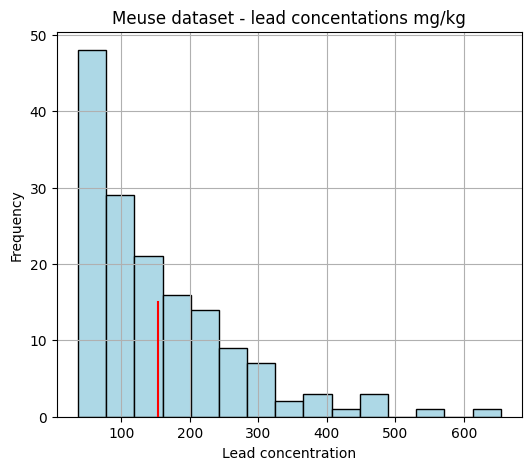

In [ ]:
# Résultat attendu ci-dessous...

- Tracez l'histogramme des concentrations en zinc dans les sols

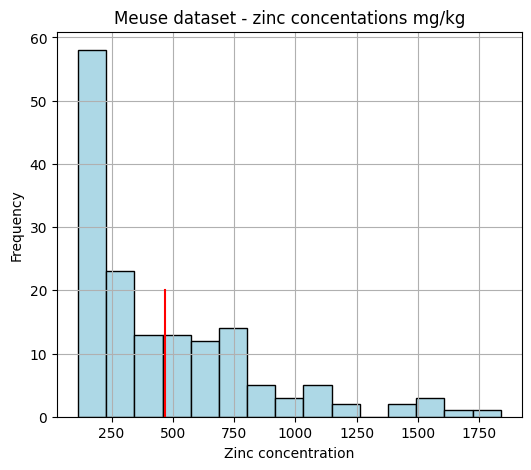

In [ ]:
# Résultat attendu ci-dessous...

In [ ]:

%%display_prompt --title Question 2.2.2: --prompt 436f6d6d656e742064c3a96372697269657a2d766f75732063657320646973747269627574696f6e73203f203c62723e0a202020205175656c6c65207472616e73666f726d6174696f6e206170706c697175657269657a2d766f7573207375722063657320646973747269627574696f6e7320706f757220717527656c6c65732073652072617070726f6368656e7420646520646973747269627574696f6e73206e6f726d616c6573203f20200a0a --answer 202020204c6120646973747269627574696f6e20657374206173796dc3a97472697175652065742064c3a963616cc3a96520c3a020676175636865206465206c61206dc3a96469616e652c20657420646f6e63206176656320756e20c3a974616c656d656e7420646573206f62736572766174696f6e732076657273206c612064726f6974652e203c62723e0a20202020556e65207472616e73666f726d6174696f6e206c6f6761726974686d697175652e203c62723e
# @info: Exécutez-moi pour afficher la question

Question 2.2.2: Comment décririez-vous ces distributions ? 
 Quelle transformation appliqueriez-vous sur ces distributions pour qu'elles se rapprochent de distributions normales ?

- Calculez le logarithme des teneurs en Pb et en Zn et ajoutez-les au jeu de donnée réduit pour obtenir un histogramme plus symétrique

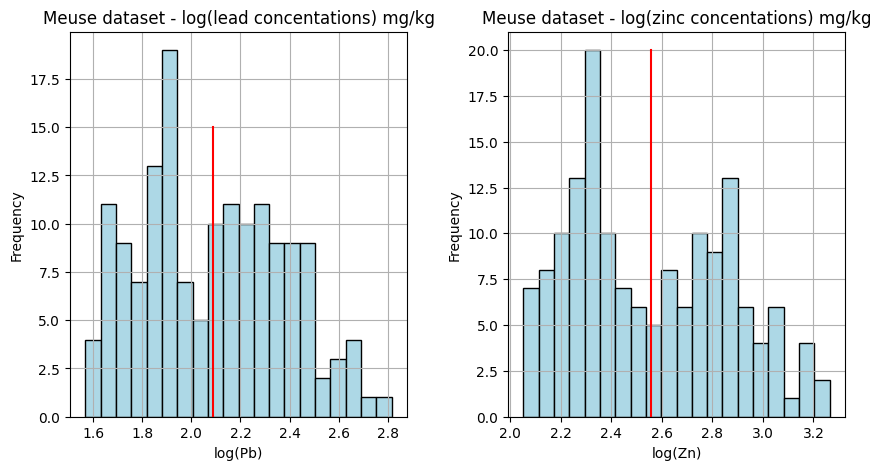

In [ ]:
# Résultat attendu ci-dessous...

- Envoyez le nouveau jeu de données dans l'espace de travail <code>R</code> avec <b>rpy2</b>

<div class="alert alert-block alert-success">
	<img align="right" src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAKQWlDQ1BJQ0MgUHJvZmlsZQAASA2dlndUU9kWh8+9N73QEiIgJfQaegkg0jtIFQRRiUmAUAKGhCZ2RAVGFBEpVmRUwAFHhyJjRRQLg4Ji1wnyEFDGwVFEReXdjGsJ7601896a/cdZ39nnt9fZZ+9917oAUPyCBMJ0WAGANKFYFO7rwVwSE8vE9wIYEAEOWAHA4WZmBEf4RALU/L09mZmoSMaz9u4ugGS72yy/UCZz1v9/kSI3QyQGAApF1TY8fiYX5QKUU7PFGTL/BMr0lSkyhjEyFqEJoqwi48SvbPan5iu7yZiXJuShGlnOGbw0noy7UN6aJeGjjAShXJgl4GejfAdlvVRJmgDl9yjT0/icTAAwFJlfzOcmoWyJMkUUGe6J8gIACJTEObxyDov5OWieAHimZ+SKBIlJYqYR15hp5ejIZvrxs1P5YjErlMNN4Yh4TM/0tAyOMBeAr2+WRQElWW2ZaJHtrRzt7VnW5mj5v9nfHn5T/T3IevtV8Sbsz55BjJ5Z32zsrC+9FgD2JFqbHbO+lVUAtG0GQOXhrE/vIADyBQC03pzzHoZsXpLE4gwnC4vs7GxzAZ9rLivoN/ufgm/Kv4Y595nL7vtWO6YXP4EjSRUzZUXlpqemS0TMzAwOl89k/fcQ/+PAOWnNycMsnJ/AF/GF6FVR6JQJhIlou4U8gViQLmQKhH/V4X8YNicHGX6daxRodV8AfYU5ULhJB8hvPQBDIwMkbj96An3rWxAxCsi+vGitka9zjzJ6/uf6Hwtcim7hTEEiU+b2DI9kciWiLBmj34RswQISkAd0oAo0gS4wAixgDRyAM3AD3iAAhIBIEAOWAy5IAmlABLJBPtgACkEx2AF2g2pwANSBetAEToI2cAZcBFfADXALDIBHQAqGwUswAd6BaQiC8BAVokGqkBakD5lC1hAbWgh5Q0FQOBQDxUOJkBCSQPnQJqgYKoOqoUNQPfQjdBq6CF2D+qAH0CA0Bv0BfYQRmALTYQ3YALaA2bA7HAhHwsvgRHgVnAcXwNvhSrgWPg63whfhG/AALIVfwpMIQMgIA9FGWAgb8URCkFgkAREha5EipAKpRZqQDqQbuY1IkXHkAwaHoWGYGBbGGeOHWYzhYlZh1mJKMNWYY5hWTBfmNmYQM4H5gqVi1bGmWCesP3YJNhGbjS3EVmCPYFuwl7ED2GHsOxwOx8AZ4hxwfrgYXDJuNa4Etw/XjLuA68MN4SbxeLwq3hTvgg/Bc/BifCG+Cn8cfx7fjx/GvyeQCVoEa4IPIZYgJGwkVBAaCOcI/YQRwjRRgahPdCKGEHnEXGIpsY7YQbxJHCZOkxRJhiQXUiQpmbSBVElqIl0mPSa9IZPJOmRHchhZQF5PriSfIF8lD5I/UJQoJhRPShxFQtlOOUq5QHlAeUOlUg2obtRYqpi6nVpPvUR9Sn0vR5Mzl/OX48mtk6uRa5Xrl3slT5TXl3eXXy6fJ18hf0r+pvy4AlHBQMFTgaOwVqFG4bTCPYVJRZqilWKIYppiiWKD4jXFUSW8koGStxJPqUDpsNIlpSEaQtOledK4tE20Otpl2jAdRzek+9OT6cX0H+i99AllJWVb5SjlHOUa5bPKUgbCMGD4M1IZpYyTjLuMj/M05rnP48/bNq9pXv+8KZX5Km4qfJUilWaVAZWPqkxVb9UU1Z2qbapP1DBqJmphatlq+9Uuq43Pp893ns+dXzT/5PyH6rC6iXq4+mr1w+o96pMamhq+GhkaVRqXNMY1GZpumsma5ZrnNMe0aFoLtQRa5VrntV4wlZnuzFRmJbOLOaGtru2nLdE+pN2rPa1jqLNYZ6NOs84TXZIuWzdBt1y3U3dCT0svWC9fr1HvoT5Rn62fpL9Hv1t/ysDQINpgi0GbwaihiqG/YZ5ho+FjI6qRq9Eqo1qjO8Y4Y7ZxivE+41smsImdSZJJjclNU9jU3lRgus+0zwxr5mgmNKs1u8eisNxZWaxG1qA5wzzIfKN5m/krCz2LWIudFt0WXyztLFMt6ywfWSlZBVhttOqw+sPaxJprXWN9x4Zq42Ozzqbd5rWtqS3fdr/tfTuaXbDdFrtOu8/2DvYi+yb7MQc9h3iHvQ732HR2KLuEfdUR6+jhuM7xjOMHJ3snsdNJp9+dWc4pzg3OowsMF/AX1C0YctFx4bgccpEuZC6MX3hwodRV25XjWuv6zE3Xjed2xG3E3dg92f24+ysPSw+RR4vHlKeT5xrPC16Il69XkVevt5L3Yu9q76c+Oj6JPo0+E752vqt9L/hh/QL9dvrd89fw5/rX+08EOASsCegKpARGBFYHPgsyCRIFdQTDwQHBu4IfL9JfJFzUFgJC/EN2hTwJNQxdFfpzGC4sNKwm7Hm4VXh+eHcELWJFREPEu0iPyNLIR4uNFksWd0bJR8VF1UdNRXtFl0VLl1gsWbPkRoxajCCmPRYfGxV7JHZyqffS3UuH4+ziCuPuLjNclrPs2nK15anLz66QX8FZcSoeGx8d3xD/iRPCqeVMrvRfuXflBNeTu4f7kufGK+eN8V34ZfyRBJeEsoTRRJfEXYljSa5JFUnjAk9BteB1sl/ygeSplJCUoykzqdGpzWmEtPi000IlYYqwK10zPSe9L8M0ozBDuspp1e5VE6JA0ZFMKHNZZruYjv5M9UiMJJslg1kLs2qy3mdHZZ/KUcwR5vTkmuRuyx3J88n7fjVmNXd1Z752/ob8wTXuaw6thdauXNu5Tnddwbrh9b7rj20gbUjZ8MtGy41lG99uit7UUaBRsL5gaLPv5sZCuUJR4b0tzlsObMVsFWzt3WazrWrblyJe0fViy+KK4k8l3JLr31l9V/ndzPaE7b2l9qX7d+B2CHfc3em681iZYlle2dCu4F2t5czyovK3u1fsvlZhW3FgD2mPZI+0MqiyvUqvakfVp+qk6oEaj5rmvep7t+2d2sfb17/fbX/TAY0DxQc+HhQcvH/I91BrrUFtxWHc4azDz+ui6rq/Z39ff0TtSPGRz0eFR6XHwo911TvU1zeoN5Q2wo2SxrHjccdv/eD1Q3sTq+lQM6O5+AQ4ITnx4sf4H++eDDzZeYp9qukn/Z/2ttBailqh1tzWibakNml7THvf6YDTnR3OHS0/m/989Iz2mZqzymdLz5HOFZybOZ93fvJCxoXxi4kXhzpXdD66tOTSna6wrt7LgZevXvG5cqnbvfv8VZerZ645XTt9nX297Yb9jdYeu56WX+x+aem172296XCz/ZbjrY6+BX3n+l37L972un3ljv+dGwOLBvruLr57/17cPel93v3RB6kPXj/Mejj9aP1j7OOiJwpPKp6qP6391fjXZqm99Oyg12DPs4hnj4a4Qy//lfmvT8MFz6nPK0a0RupHrUfPjPmM3Xqx9MXwy4yX0+OFvyn+tveV0auffnf7vWdiycTwa9HrmT9K3qi+OfrW9m3nZOjk03dp76anit6rvj/2gf2h+2P0x5Hp7E/4T5WfjT93fAn88ngmbWbm3/eE8/syOll+AAAACXBIWXMAAAE5AAABOQFgIaz4AAAWkUlEQVR4Ae1aeZxVxZWuutt7r7vZN0kQRZ0xgsaNjEswNC6DSkCM0lHjPkobzCAyyS+/kait46jRyUzi3qBmNE5mpjGAAVmM0O2SEbFbaZHWGDEgERAEpJe33HW+r+re16+bRsCZ5J90dd9769Zy6pyvTp1zqu4Tojf1ItCLQC8CvQj0ItCLwF8qAvL/IngURXL+/PnGkCFD5IQJE/xSWqx75ZWmQwxHHmaJ8MteEBxuGOZQIaMBgR8MDMOoPAxDR6AhygpSGm1Syl1hGOz2vHCbMMTGyAs+zlrRpm+dffbO7rQbGhrMysrKEH3C0rqDzVsH24HtKRwZwOAUOkhoNDauOzIQ/ilhEJ722prGkyxHHA6BhknHMTOOI4SUIgojEZqBgPC4IlIDvYQCXy1hmqHwPE+4wnczvtyyZOkLG1DTGEbha5FvvIFxt+BdAZ5MQlVVFYEopYTX/aeDAqCb4IqBNWvXjhF+NAV153ph4cRUKtXHSJlKAM91RRAAkmw2QL2Slo8QACqpkdfvBDVUebCMbCQBkAHAHNM0DwfNwyH0WaTnBu6nz/166Wohjed9N1iG8k3ooyahvr7egiYyf8BAHPASiIkrodevX+/k3OCCKAyvBaOVZeVlad/3RT6XFz70G8NjcpWQpC8hJC8loOIsyff4JAIxMKTCF0GFCSWAMQCI4UCbWJjLZncJKZYHXvREVdWUVShSqa6uzoRGFDUzKe/puV8AML7BjkCa3JhvNb9zVRD4N1m2/VVDGqIj20G19lAnwRRn1vg8Ick5xCsKSfk6r07hO8vieiwXqgYTcGFGGoZhOU5K5PM5IlSP0p9ceulFz5NfgjBt2jTaCMUOy3pKnwtA6ay/2dw8Bcv2jnQ6fQLXZy6bIxMhRDYgT8kMa4aVoF2EYzlYYFmPAOxPeE0XY5YARsWA2EJY6VRacrl5rrfCMMStl1xy0RsUeH/asE8AEuEbGxsHC9P+F6jeVUBTZLNZn8IhmRRE/SdMxYJ1KYvrdFPNPIBEx+JsAkMqEddNqGxDIqSadJSjFgAToBC2AUtLL6siEEQBKcDDzGQyBjTCwwh3b9jw7p01NTVhIoviutttLwBASLk2rqGmpuYzYYqeKi8rG7Fnzx4141JIUzGIEfhUguGp/vCKwiJjqp16V43RX+kuxzSxfCQWtIAaK5YSWmgR96fc8BTsj6cyprAztDXIkxcaVrY1cFED8WTTkHbKBs+crNfhei+/4oqqD/YFQhcASChZM2vfXl/t+d5jlmVhjeVdiGCTU7SJhT0g4RWT6GDZji1s2+YskzHS2YkZ22Ya5sdBGOyC8WyTkdEeicATWFVwpU4Q+uUAqBxM9vX9YBjaDwMHg6GNZeQLOIhCoQCP44Jc5IM1AwhwgtA0DDLpMjtfyO00pPj21VdfvhLaYOFShpyyMBUBQCfmCUDY2LzuHzNO6u629jYwKqBOkU2sIcjewseAqDrk4Yypy5wiw7Edk0J3dLSTdAvmZw1MxuuBFOtsGWxC4adwW3k895u4loFDP8PwhvqRd5QM5XEA81QIehJmeQQByeWyAk7IA5uwS5GBeg9gOdAYiGdeeP3133muuyYUAUiMBYT/fiaVvr+trVVrLNSV896j8ISDVbHqQ2iOZHAdhjBIrue1YFEvCP1wmWGEb+5L2AR8RJVFfohIy7RpkbjjDoFZUyP0hNJTTz01SNrp04H8VFiBC1Lp9KB8LselQiAs6IIPLbJhIDDb8vzp069aBnpFTVAD1tdHCCCk37R23YWWaS7I5XPgSdml/QuvjRLADkN4CAu6J3zPq8dMP5TPt66YOHFiR8J4bW2jXShsN3Yd0h5t2X1E9KWtbdH60TsiMT9psY/nNCF2tAyRlagePryP3DrgQzlwW4XctSsT1NR0huDz5tWNsm3/arByYyqVHtTe3qbCZExQQBCgmG0gceoNN1zbkoAgk5lvbm4e5YWiCUtggOu6tPSWmlvAyOkHIMzoGS95V7MeRlZFRbnI5rKNUpq3jx936tJEFNLvaa+Q1P8pnrW1dSMtq3A3lsZ3Cm4BK4+aGYYAxXbdwpuffLL5NABAwwG/FqfGt9YugNG4sLWtDQYvcvYnPIiyr4e1Z9MyG4a8syzt3DV27FgYMSG41l566aWwpuZ2wCaj0bPXzATdU2Qk2/FEtK8mJx6dDzQreeja7m3iBigG62SR7tE3ouBjYcjmwWVm42/vG8d9gkq1837xXVjTRzh5sANcnmEmUwYtzN0+Y8Z1d3JyFAAMchBUPYfgJmBgU5ztkplmmfrjMxYeBo7C7xCGecn4r5+yiqNScOzSgsSbkEmY1mj0rNUr7fIhZ/q5z4AHVlYisGK1U3id40hoxlYYj6l43+td10aBD1kL22Gylg+yokdff3DCatbU1j49DbbwP7EsTFw+dp1cpm3wvmO/973p76vNEOzVTMsiU5gWuBKOlgir8t2EB1O+k0rZvuduts3U355++tj3SgTv4mZIlAlTtcdH6B642DBIGtaSFAvFEi16XBfzod/Ui8oW23TWAyuE7NIaatjpKz91O6746xtX3Vt7sbwNhnf+o48+Odi2nUfgzukZXBjpPoVC/gYQmy3fWLv2RHjQNfDFFgQjANQthbzii8LHABAMEAjhWuhr6bfHfeMbp77NzdGYMWPcmO2uj0QDbnrtOWmlpgSFNgBkxACUCsVueC8+imLqcsWDrtZtknpNI77zwc2YY6T7ishtf/b3j55VRW186KF5C7CJuhAxSMEyrRTk3QircKKB44SJ5eXlUAtEUCXCK15KhEdWRWUw8pI+F8ZvBoXHOtq38CX8cjWTBnVBF5NXZikIn6qFKtMluk61IR+6E5sX26gXvOs6ZZOovbBfWPL5Pa5M9b14zIxV97GrJ607czkEdEKkEODRK+CApnC6gYjlDBoxUlEDkyn+c1A1MJ/xoPAj5WUZA/59yYRvfP0Z1EvsuJTR4yAHntQAqjlJFxOL9UvcgBwA6gSFeAqKfYrtS3ppEoyvzSC7W+SD4KZjpi8/6eYbr1kLTViOswVoceRBCzijf4MoMTo2X1DBGGPpeKi9hQcbTBZDTxxG/Cv5bNCnQkV+NO+fc1cmVw/CTrpj3J3FqkTVQADstXlh0wsj2vnOKE+pObhRQ6mO8WSVaBHDYhF50s7Y8BDXsSn2Wr9mnIL+koFREIXHWYinD4H6c3C14yICJK3+VFv9jkL40ZSBrfA7Qwf3+y0J0trzecBJIUxBlX1HN808n/xLEmYKKJsBZl9Bpsq5I5QGJAxThp2xAjeLbtgMaH+oabFhQhIZdJYhthZoNY5VOGpb40J9kXUCaD1CgxFc+0Wfvy/hFSCcfsvmfnstDZ7yoVIeBACcnSQpZMGsBqJTeKwpw+aBykzM0DLbEP2xJ/KjwJPCMYWEJ5eWcEIvNwmd50AZyuDhQTiOZ0qEJxBER4QAIAoOFZe+OOzII1s2vfeevRN+WU06tMu2gHYOfj1DFVcAoCcnqggGXqA24FQVYrhQBRqM7hJxDuhJ+am8qjHuKkPRdQkfKg9ZZBR8sOGR8ZvRlFdPqfmo767MCiv1b5HbATkjnE0kSRFCEZ7QGTAPGIy0KDP7nJeZubMlfKhgxHjBpOUBgPGxacmjAheBMFjsLrwiRNZQoS4eWnzBpIUlg7A8pZGg4l7dQJlmzyjjEGNq1jvrxWhfrO/cJEH7zPU1Y1xY9RWWn6dBSnGKtBaQdgJkJ9GEMmlSPo5tmtjdB3KThe1kc9pJHeUWXD1HiaDFJ7uhD95pQADYcBbs2IFNzEGluLlioKQrxyEd3ugh+aThR0pvyUViLsfGrpAJ0KcHNEGPsIhxxc2Q09V8xNRUkSqFmTdEkBO73Nb5O+4th8ansDUgCST5NkJ4+RIKObs8VdGzXPKk4FginC+JgweAEJxA388TI/bRhA70TpaSi9kiu53Coz7E6R4pNs3lvgKoMO7nhbwug/ChfxZPAtEa1gyVqFVckn5Ml9Lg2Am4yT+KhRO3b92aORTnJAMR7gls+CjLagvHBy90BNkOgMAvNRRK7QVIUNMik/jDOX0O+2zTtI7t33/wGahdSTeIZ4+hL8q7poReUloqvBqIw2nmsaNMsdnR177ap6Of4YcdsFtxssz+KTvKXwxB7onCHIXVp9BJA5JQeXoBDAKraUTeqywqeOaptmXwgIS27F3bDlYb48Z97XeAb3kGZ2hYDrEtJBXallh4hQbgx86LJzxA6SYSpBs8UC0gU5oxnSnmldBJHWYSbivyCw8cWf2bdYGdXZPqaG/KRKnGjFDXG3aYXycMZy6kq6AbpIi6N3lO6JA6OMMxXuThbEOIp1GA5tFkRvuI5KFQ8r9mz56dU5shP/J/5ndkLwIB7AdwB1H2UlkWxBcyZnt7e4gj6MnLlr14OYg8w+UA2j3vAzhql0Siirwu5SBILIkzzNEVjsT+WrVlra6L24YI9b0sbjSksV9hJ90Kd/0Cmp6R7pdyvPbH3593/up77nngRJz2ncMPTkHgbvGDaB67UN2NynHjXgGMj1VU9MHXl9AnQ+qPzGL9awCKg0S0BX4YPLZ4+fLjYQsYExCE/SQsvCKjzOBC4jhxJslhTC+I/DzmpYAYoICjYDx91w/5DPnlSTLK0061SLNIDQEUhe+bEoW214+WwSzWAM/bEP5mcBiNrZhx55w5N2/lqZCyqKqBDG7B4eWHOFNzuDHCxU9RikHyqkCgtwEtD5sHqFF56EaLFy1aOpogcDuMNsW1yobdU3dhu78rhAgDw9iI3x2wbYbGgg2d57sOcTXpWHiYb5yz8lQYTBuWZaT6OMLtWDE61TF18dzJ2R//+MEbDBlNxQYIx3X+sh/8YGYtCQCAAE5Aqg8HZ5xxxm5Ex5djn+zjxJ5H4B4WmAZBaQJsAgpjjcCewOVp0KFo8eqiRUvOxr4bhw0yqq2ttXsCQkGnhNOgamFJMMnpjAJajcS6BCLWIa/eyUVcp7I09ClLOhW2tMsAmL8x5bfP2vj4+ecufaRq2333PfhtOPyfwnjzCH0D9OcadmckSypKA8g8Z/DsysrXcI59id5/yE4QYkaS5QD+wEto5/MFD2ANgCV8YcGiJbeRaHV1tUcgSA8IYyPD4dRi1Rl1T4ToJnwiuJYWE0/vqwdPoNDdyQByOBvHHbGu9wb2BrUiLFyeSafG/m7epJ+x3f33P1wNb/E0vh+msGw/hfDfmjNn1idUfbpxtumismSaYKxseGUaYv46NsDmhwbOToRXs0CecMFr0NNguURWGbxILp9vAss106ZNWcK+TDwJrq4e6x1948vPRaY9JXQ7uBmx9pr5RHhKBgQVa3D90GpiQLvEGVOIafhwV0tOeljgHO/xTY+fpw5jf/RP80b1TeXvAn6Xqf2L525DfvIPfzi7cfr0Wnvu3GryoFIXAFjCWSQ6y5atmoiv9L8EegPbO9o9SEsG4B3oHjm2BkEBobxnFAJonsPzWHwVih5qbXVWVFdPxrZNiCNmvLwQLnRqUOjAl2QAoBIJ8R83JhJmMmQbcowvgHJYgZOkFCw/SMZBvO6keMAUSmmnhGVY4g+53NtXDduz8tgh2y6DvRtGeljSzfD5Vbfc8g/vc+ZxdYlb9gKA4yeasLy+/igY46fxoeQ0fiXC9x58bMDGA8E6mesCAgFBIAXjaeD7gMHPVtCeFtiRhf3SubpbGw67Jyud86Wb9TGnAFNJjnun8Ep+xKZlMrpsiOnVF4RZkZUi1eoat+EDbVXkdWBZqLA16aVA48jkW5r4EoW1PnnIZjGy/25RCKz/LuTE9Jqama3dZ57tmXoEgBUJCBBSPv/8C7fgDO1HDlxER3s7iuAqYZnZPwEBgiuZsCyIjAICn8Zgkx18W2wNV7w7wH1mWyr9FYc/JkBPJX834RnxAoAPt1sniIVnNpOPJA2/bsUiGLILbD/nYz3o42yCnjRAzoI3+IMnw+PT0pk0Ysv37769+ies7mnmk277BIAN6uoiLAe951+wePnxOEapAf5TGQ3yex90kj+MULEEOWFYlgCilwqBQPQkQ3vV7weKp7amomNw+lCgeUtSUQiU4Z/B/5Wjdv/yiEFtmzo8sx+0qr8l3PLWgnPksxuGH/sRvnP0gf7B8KJ5KR1aTCKDA3KrzNqS9X8q/uP8m/c188nwnwsAG0Eg9YMoGke+L1y4mPHvLCj7JCiEVcjnsbFA4KIlJhg0XbFmgCm6ZnzVJwC/2JaRX7EDUQDzamAtM0dR7wQPu3sx+6ufyaF9Cvi2iFbQKIUX4v53t1YED24eJI6wAsNTIYcGAN0UDX1XMwLNS3FJnrvx599cUVlTbzWUfEJjuyTFxih53ftJl4ZSn8Yx/slJA94b6hYuOTmfzV6DCZ6Mo7KRCDJM7rBcnBkCAERsQIRgKNnw5LdJvPCP5xQUOmafWfXGdxoXfNz0O2QW8SDxZCeKGFmHDWizz2kdIOr3GNGh+LaEpdBJA/1iQvzdHM694Maj8J9R9kJDDX7NBl5gPjhEl7RfAJLWsd+UNUBTiJfCqgu/2YS6JgBzG4LUs6B/50HicdDgv8Jegd8VGXUJHEGDDyVDCbsJH7qIbbVGMKcS7YsFTIVl6nNRbHsQ4LbnRvffvfU3ewaOorAJFdUjBjc2axY2Qb50yk8ecc2Sv//jz8UD4o4G0uziAdhPjasIHOQt1gg4ps4fKj78cF1Fv37hsdhtfg3zPxbqfwxs40j8nHBw/QeDzGe2pqOjnVDgq6QejfIzT+OHB1UdRzxixtHbZf9UG3C1tkN1NmLu3oEtaXKc8H8QzW164N1jViJYPSWgkNg7a80iSRBQicqGkfkTlCjcGVnhyVufuGiTmIbob37XX48dsAbElIuPJJKChTXGjx9v8IQIZfwlBL/Jxd/lavFJOj10QEV+8EcdziNfTjun+2GOs8CYXs+hXg16nQMFBxJta8vMHjX4k6UftQ38bM6s6/G9rygZskIc+ndL74WjWQiN5g8hulYmdLmaQt8znLJB2ETVoNs1YkzLXp/iv7AGkJHuiWCMHj1a0WxpaYnwrvwz2w2dvurZfo59kV8MhDhbittYAKUW7Cs3feacJH51zlvsx0S6ePBiwhfnmnDEtYuXwu+fF7pZHVmyplN4viHRgkBJTQdbwPCcLU9OfVFwCZcYxC+sAXqArncyVlrCwflbYmpLXzNEBEAOKThTF+HVO+0UF+VxA3N916EkdmF+TFfTrqQNwqmZNO6NfO885PmOodgzoY0S5FmGEh+7JRu/4LwLhSu18Gog1ThBlT3+3xM9SBV+rEjCAR2lllmPU8zrjMaFjEVipxspYzV39wD2VYzqTrg3wB1DIzY/MellxMl1UHEueGxsSpsp4VUXELQiRJ/Cck4ZfvVCdZIlKpVBVPV/UgCKTDMDNjFxyJA5YhHDoeRPmOcLzrGMkmP+LkTil/V6mSEqvyd0cy56YeeqIeQjzqmxVA9+avBhXsPw1i9dWTdSgUiDiPTnA4CGjwYbO0f4Y26TOTZUlLPOpIDRzDN6+LxESw4BPv73SWtB60kjVUH9x0kRaBT7leQQIGKbgk8JmYHY092hmtAgIv3ZAABvrTBYrjTNHVCGzyB3G/QAx7o8T4R1SGQGJHs5a8VxzzffkvdBxXfzIBHiaztRCoPGgQcHEltxkr7ikCt/NQHLKFRusWeyvaW9CPQi0ItALwK9CPwlIPC/yDieSTGcRMEAAAAASUVORK5CYII=" width="24"/>	<b>2.3 Définition du système de coordonnées</b>
</div>

- Définissez le système de coordonnées du jeu de données (EPSG:28992)

<div class="alert alert-block alert-info">
<b>Info:</b><br>     <b>Definir un système de coordonnées</b> <br><br>
    Pour définir un CRS, vous pouvez utiliser les fonctions <i>proj4string()</i> et <i>CRS()</i> du <b>package</b> <i>sp</i>. <br> <br>
    Pour appliquer une transformation entre deux CRS, vous pouvez utiliser la fonction <i>spTransform()</i> du <b>package</b> <i>sp</i>.
</div>

In [74]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e252552202d69206d657573653c62723e0a203c62723e0a3c62723e0a6d65757365203d205370617469616c506f696e7473446174614672616d6528636f6f726473203d206d657573655b2c63282778272c20277927295d2c2064617461203d206d657573652c3c62723e0a2020202020202020202020202020202020202020202020202020202020202070726f6a34737472696e67203d2043525328222b696e69743d657073673a32383939322229293c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions


<div class="alert alert-block alert-success">
	<img align="right" src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABmJLR0QA/wD/AP+gvaeTAAAACXBIWXMAAAbmAAAG5gFFAfPZAAAAB3RJTUUH3gwMFiIaKb3l3gAACBFJREFUeNrtW31sVWcZ/z23pSKtCYqXjW3R4DqEdpNVgzaKAXUE3ew2xRLHRKMuk3WajbQ6DW65M4jgGIiLZP5lxGmyofhBl8lWsMBWKBPWdC4zHRAj8lFoN6al68c9z88/7rnnnnPvOee+5/Z2O8a+bdP3vufet+f5Pc/v+TpvgakxNabG//OQydz85p90XDY+xuUk5wNIUpkkOZtkEqqzSU4nOUhiQKEDCYuDCgworAFR7R2aNv3Jo6mm4f8pAJpTL1UN1/S3KbEC1AaQQhLZHzhzLVzT3DV7bVjJXemE1da9YVV/7AG4aev+BbD0NySvR56QXuELBPV5n+uzyguk9bVDD32pPbYAND/xRMXwP5N/B1nLPC0bCVnwvoLPjhPaePih1cfKCUCiXBsNn0re5hZeiQNQ3CLUW0gccAsJHzAM1qZB8aulqV9MLycAleXaiMpPwhGeF6tGRj6z23ZgTandHW9UJE6DnOlvCcZrdcP/TtwAoD12FgBgDkEABIhdu13ee3eqaRjkrkINI0Tr8LcExYdjSQFSk9kbBazFIMV1UUguDtJwNFpYC2NJASEqNae9ecs3PPVg5Y/atwLAyA/a1xKcB9tC3F9AJAoAirfFEgDNi+tK3D+altaMRXBGqIZdYHgA8rMEEPF0gv5mO6O4k0Ow1vPsxfYv8QQgnMOYaAj0WEtMLUB3EjwMAqKEAlBbi2BWewQVUBD25CMErw8X3AfcOALw9Lobfxj1Mx/9zuMbYQNgnA+ovjUA3PRw5yeo2qDUBSCvAinM3kwm+QGhoNraZUbTtGjfswVQ7fBPQAmLOk+K5gPeNcfi+ltboViWd5uXkGAPVP6Ky9+xRySlEwagacu+JVTZqKqNICEej4wAhwav1xY6/ouusCcl+ANX8XIdBMsLuYjPAwqcfe0Znv3W7TLnkQslJ0JNWzpbVKWTZOPEkheftYJ8ACEUgCH3s9ZnAdBlsPQwz7VVlwRA08P7VqjiERNuolxrQfmAiefPCk51gWC9D+mhByMDcOvWv8wkEjtATZjk7xMscIzADdd6geCu1+l7+I875kYCwFL5MqkzvAmIqTZR1nwg1PQdITVPaIcGALUSSH8hEgBKfMMvAfHwFZNBi0KAfMZFW0szMwKGad+ei5oDcOPmve8ltc5IgEC+locC/gYvRzPVl7XIK6iP4Llri3iq+e1GAKhILVzaKFnDUQocn7UQs3+ep9ZeCdUrHMHhIzg8oAhGE1cbAZBQrTXOy8tW4Jimutzf8+ia/UiMLc8J7RIcIdYAvcYoESJZSzv/fjMLHINw90ZC9A6euyuJtGxyAHBif/5c7ejhXKs1o4CidvJjP6KGu1dILj22/e7jsPAoYL07hO8BlEhfY0YBYa1HHyVRoLS1PFu8APApCL+v1TMaetb1vch/rdkO1c8FJD1FKOFvAZWFFsC5Hs3Bx6EV0zB4VIh2Jbp1RI8c+dlXBidUap+5+4PQ9K9Bne8x9ayZO/MAGkT0Aa+DrA51aPn5QM7Dj4G8v6u6bzNSKeX5lhqkqxvwQOssI0kty56kAWA2yEbQaoQ1Ph9Q8XDaM88HpYD/AHW2WTVIniB5RQlcv2Apb+jevKqXZ9uWYk3rNiiuRUITRVP57M3CRKshjs4jdME+rxr5AJInS3NyaOnevKqX59rWQ7gXwAeM2u6FMTvPkUVxdGEJkQ6Y+QDihER2aPp4149v/y37W1eDXGfI7ADzLWrKAdrXkD0VIM8aASAZCkQqcNLpigd4/tuXg7rN8DlaOGcjOTpTUNhlRAELOBEx9g8e2fLFPlBvBfFOI62jSP5uWuQUpYTrtaY7jSygSiteGUeaAMUTAgMooGS3Ldsic5PP12oE7Yc6ukBKDKOm8rCRBexJffpVwudxNgILnJecHp1xt0Z9tGYFa7/A0Rns4/mb/L3M7Rwx7gfQ4mPGBY4y23mtit6t8RGGJYASBm5GWTsiNUQqx8Z2guw3a26qYbcmhMOBaWxEUPKtIzP6cG1XRyQAOjatfJ3AnSb5QGGSw4AbNIjZxUzZNPa7b0oSLSLQyF3hA+tX/EmATUXzAc/eNNRaEKcNQQkD1xPT5adSf3Bvyc8FDmxo/q5SP0vwdGA+oDbcWmJ4oiEoRSnhMcX/gPJ1qX/2ngk/GeradNuTAK5afN+O94xbFQ1UzrFzxsy38IWSw5xaf0CCezL3rs6enrrASZzUaVhk5pbrtWOBQ6hAD/525cuycqf1ph6T45lv9oBcaFiaZo+7fE+u3rkRb+EoHwCn78oA4CtoIChDIC8FJjlgTuPZfUT3Sd3BVTE8IBGlNHXmNaDWRCpxFe+K6QkRg8ZEaWms6zpR7uPN5QXAvDQt5icswPojyFkAl3jDW3mPiJQPAFg5jU6syBkDWS/1+48DAF/82DIInnYH93ICUL6ToqoDZYn90N9JfedxR9zrnnsGwAsuCxiMJwBId0V6UhMISnrUp6YadTGgO6YWgA7zfD4s88NKHvt40pG3d/GHIGjM3TEPxjIPAACebP45qHdG6+W53+eMIYA7IDIrc+YH0+x+3Tap77o3pk4QwDTci1F9P6hLojU4Cxx7DSAtect/xvmqtthmgjmKphLoO7YWYq0HdXqRXr3JlpcAuQ/1z24XKfdB2Un8rzGevPkyjI6sBvhVwD5wka/98NEL4S+RxmOysOt87GuBUDBe/tQsaLoOYB2gCzK/UQciCeAiBK9B0Q/weQgOoVIOyfznzmBqTI2pMTUmefwX5Mz8p5zVbn8AAAAASUVORK5CYII=" width="24"/>	<b>2.4 Affichage du jeu de données sur un fond de carte</b>
</div>

- Avec contextily, affichez la carte des concentrations en Plomb

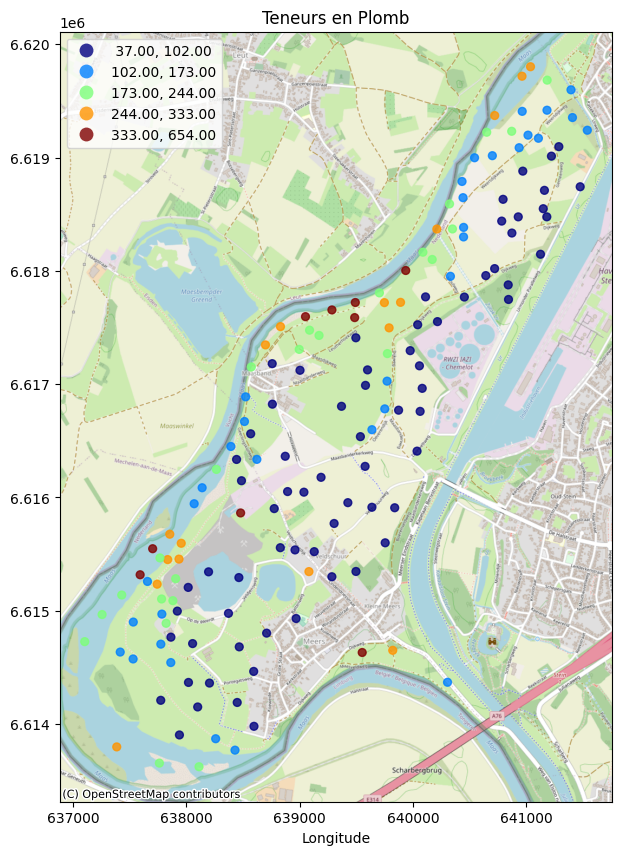

In [ ]:
# Résultat attendu ci-dessous...

<div class="alert alert-block alert-success">
	<img align="right" src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAKQWlDQ1BJQ0MgUHJvZmlsZQAASA2dlndUU9kWh8+9N73QEiIgJfQaegkg0jtIFQRRiUmAUAKGhCZ2RAVGFBEpVmRUwAFHhyJjRRQLg4Ji1wnyEFDGwVFEReXdjGsJ7601896a/cdZ39nnt9fZZ+9917oAUPyCBMJ0WAGANKFYFO7rwVwSE8vE9wIYEAEOWAHA4WZmBEf4RALU/L09mZmoSMaz9u4ugGS72yy/UCZz1v9/kSI3QyQGAApF1TY8fiYX5QKUU7PFGTL/BMr0lSkyhjEyFqEJoqwi48SvbPan5iu7yZiXJuShGlnOGbw0noy7UN6aJeGjjAShXJgl4GejfAdlvVRJmgDl9yjT0/icTAAwFJlfzOcmoWyJMkUUGe6J8gIACJTEObxyDov5OWieAHimZ+SKBIlJYqYR15hp5ejIZvrxs1P5YjErlMNN4Yh4TM/0tAyOMBeAr2+WRQElWW2ZaJHtrRzt7VnW5mj5v9nfHn5T/T3IevtV8Sbsz55BjJ5Z32zsrC+9FgD2JFqbHbO+lVUAtG0GQOXhrE/vIADyBQC03pzzHoZsXpLE4gwnC4vs7GxzAZ9rLivoN/ufgm/Kv4Y595nL7vtWO6YXP4EjSRUzZUXlpqemS0TMzAwOl89k/fcQ/+PAOWnNycMsnJ/AF/GF6FVR6JQJhIlou4U8gViQLmQKhH/V4X8YNicHGX6daxRodV8AfYU5ULhJB8hvPQBDIwMkbj96An3rWxAxCsi+vGitka9zjzJ6/uf6Hwtcim7hTEEiU+b2DI9kciWiLBmj34RswQISkAd0oAo0gS4wAixgDRyAM3AD3iAAhIBIEAOWAy5IAmlABLJBPtgACkEx2AF2g2pwANSBetAEToI2cAZcBFfADXALDIBHQAqGwUswAd6BaQiC8BAVokGqkBakD5lC1hAbWgh5Q0FQOBQDxUOJkBCSQPnQJqgYKoOqoUNQPfQjdBq6CF2D+qAH0CA0Bv0BfYQRmALTYQ3YALaA2bA7HAhHwsvgRHgVnAcXwNvhSrgWPg63whfhG/AALIVfwpMIQMgIA9FGWAgb8URCkFgkAREha5EipAKpRZqQDqQbuY1IkXHkAwaHoWGYGBbGGeOHWYzhYlZh1mJKMNWYY5hWTBfmNmYQM4H5gqVi1bGmWCesP3YJNhGbjS3EVmCPYFuwl7ED2GHsOxwOx8AZ4hxwfrgYXDJuNa4Etw/XjLuA68MN4SbxeLwq3hTvgg/Bc/BifCG+Cn8cfx7fjx/GvyeQCVoEa4IPIZYgJGwkVBAaCOcI/YQRwjRRgahPdCKGEHnEXGIpsY7YQbxJHCZOkxRJhiQXUiQpmbSBVElqIl0mPSa9IZPJOmRHchhZQF5PriSfIF8lD5I/UJQoJhRPShxFQtlOOUq5QHlAeUOlUg2obtRYqpi6nVpPvUR9Sn0vR5Mzl/OX48mtk6uRa5Xrl3slT5TXl3eXXy6fJ18hf0r+pvy4AlHBQMFTgaOwVqFG4bTCPYVJRZqilWKIYppiiWKD4jXFUSW8koGStxJPqUDpsNIlpSEaQtOledK4tE20Otpl2jAdRzek+9OT6cX0H+i99AllJWVb5SjlHOUa5bPKUgbCMGD4M1IZpYyTjLuMj/M05rnP48/bNq9pXv+8KZX5Km4qfJUilWaVAZWPqkxVb9UU1Z2qbapP1DBqJmphatlq+9Uuq43Pp893ns+dXzT/5PyH6rC6iXq4+mr1w+o96pMamhq+GhkaVRqXNMY1GZpumsma5ZrnNMe0aFoLtQRa5VrntV4wlZnuzFRmJbOLOaGtru2nLdE+pN2rPa1jqLNYZ6NOs84TXZIuWzdBt1y3U3dCT0svWC9fr1HvoT5Rn62fpL9Hv1t/ysDQINpgi0GbwaihiqG/YZ5ho+FjI6qRq9Eqo1qjO8Y4Y7ZxivE+41smsImdSZJJjclNU9jU3lRgus+0zwxr5mgmNKs1u8eisNxZWaxG1qA5wzzIfKN5m/krCz2LWIudFt0WXyztLFMt6ywfWSlZBVhttOqw+sPaxJprXWN9x4Zq42Ozzqbd5rWtqS3fdr/tfTuaXbDdFrtOu8/2DvYi+yb7MQc9h3iHvQ732HR2KLuEfdUR6+jhuM7xjOMHJ3snsdNJp9+dWc4pzg3OowsMF/AX1C0YctFx4bgccpEuZC6MX3hwodRV25XjWuv6zE3Xjed2xG3E3dg92f24+ysPSw+RR4vHlKeT5xrPC16Il69XkVevt5L3Yu9q76c+Oj6JPo0+E752vqt9L/hh/QL9dvrd89fw5/rX+08EOASsCegKpARGBFYHPgsyCRIFdQTDwQHBu4IfL9JfJFzUFgJC/EN2hTwJNQxdFfpzGC4sNKwm7Hm4VXh+eHcELWJFREPEu0iPyNLIR4uNFksWd0bJR8VF1UdNRXtFl0VLl1gsWbPkRoxajCCmPRYfGxV7JHZyqffS3UuH4+ziCuPuLjNclrPs2nK15anLz66QX8FZcSoeGx8d3xD/iRPCqeVMrvRfuXflBNeTu4f7kufGK+eN8V34ZfyRBJeEsoTRRJfEXYljSa5JFUnjAk9BteB1sl/ygeSplJCUoykzqdGpzWmEtPi000IlYYqwK10zPSe9L8M0ozBDuspp1e5VE6JA0ZFMKHNZZruYjv5M9UiMJJslg1kLs2qy3mdHZZ/KUcwR5vTkmuRuyx3J88n7fjVmNXd1Z752/ob8wTXuaw6thdauXNu5Tnddwbrh9b7rj20gbUjZ8MtGy41lG99uit7UUaBRsL5gaLPv5sZCuUJR4b0tzlsObMVsFWzt3WazrWrblyJe0fViy+KK4k8l3JLr31l9V/ndzPaE7b2l9qX7d+B2CHfc3em681iZYlle2dCu4F2t5czyovK3u1fsvlZhW3FgD2mPZI+0MqiyvUqvakfVp+qk6oEaj5rmvep7t+2d2sfb17/fbX/TAY0DxQc+HhQcvH/I91BrrUFtxWHc4azDz+ui6rq/Z39ff0TtSPGRz0eFR6XHwo911TvU1zeoN5Q2wo2SxrHjccdv/eD1Q3sTq+lQM6O5+AQ4ITnx4sf4H++eDDzZeYp9qukn/Z/2ttBailqh1tzWibakNml7THvf6YDTnR3OHS0/m/989Iz2mZqzymdLz5HOFZybOZ93fvJCxoXxi4kXhzpXdD66tOTSna6wrt7LgZevXvG5cqnbvfv8VZerZ645XTt9nX297Yb9jdYeu56WX+x+aem172296XCz/ZbjrY6+BX3n+l37L972un3ljv+dGwOLBvruLr57/17cPel93v3RB6kPXj/Mejj9aP1j7OOiJwpPKp6qP6391fjXZqm99Oyg12DPs4hnj4a4Qy//lfmvT8MFz6nPK0a0RupHrUfPjPmM3Xqx9MXwy4yX0+OFvyn+tveV0auffnf7vWdiycTwa9HrmT9K3qi+OfrW9m3nZOjk03dp76anit6rvj/2gf2h+2P0x5Hp7E/4T5WfjT93fAn88ngmbWbm3/eE8/syOll+AAAACXBIWXMAAAE5AAABOQFgIaz4AAAWkUlEQVR4Ae1aeZxVxZWuutt7r7vZN0kQRZ0xgsaNjEswNC6DSkCM0lHjPkobzCAyyS+/kait46jRyUzi3qBmNE5mpjGAAVmM0O2SEbFbaZHWGDEgERAEpJe33HW+r+re16+bRsCZ5J90dd9769Zy6pyvTp1zqu4Tojf1ItCLQC8CvQj0ItCLwF8qAvL/IngURXL+/PnGkCFD5IQJE/xSWqx75ZWmQwxHHmaJ8MteEBxuGOZQIaMBgR8MDMOoPAxDR6AhygpSGm1Syl1hGOz2vHCbMMTGyAs+zlrRpm+dffbO7rQbGhrMysrKEH3C0rqDzVsH24HtKRwZwOAUOkhoNDauOzIQ/ilhEJ722prGkyxHHA6BhknHMTOOI4SUIgojEZqBgPC4IlIDvYQCXy1hmqHwPE+4wnczvtyyZOkLG1DTGEbha5FvvIFxt+BdAZ5MQlVVFYEopYTX/aeDAqCb4IqBNWvXjhF+NAV153ph4cRUKtXHSJlKAM91RRAAkmw2QL2Slo8QACqpkdfvBDVUebCMbCQBkAHAHNM0DwfNwyH0WaTnBu6nz/166Wohjed9N1iG8k3ooyahvr7egiYyf8BAHPASiIkrodevX+/k3OCCKAyvBaOVZeVlad/3RT6XFz70G8NjcpWQpC8hJC8loOIsyff4JAIxMKTCF0GFCSWAMQCI4UCbWJjLZncJKZYHXvREVdWUVShSqa6uzoRGFDUzKe/puV8AML7BjkCa3JhvNb9zVRD4N1m2/VVDGqIj20G19lAnwRRn1vg8Ick5xCsKSfk6r07hO8vieiwXqgYTcGFGGoZhOU5K5PM5IlSP0p9ceulFz5NfgjBt2jTaCMUOy3pKnwtA6ay/2dw8Bcv2jnQ6fQLXZy6bIxMhRDYgT8kMa4aVoF2EYzlYYFmPAOxPeE0XY5YARsWA2EJY6VRacrl5rrfCMMStl1xy0RsUeH/asE8AEuEbGxsHC9P+F6jeVUBTZLNZn8IhmRRE/SdMxYJ1KYvrdFPNPIBEx+JsAkMqEddNqGxDIqSadJSjFgAToBC2AUtLL6siEEQBKcDDzGQyBjTCwwh3b9jw7p01NTVhIoviutttLwBASLk2rqGmpuYzYYqeKi8rG7Fnzx4141JIUzGIEfhUguGp/vCKwiJjqp16V43RX+kuxzSxfCQWtIAaK5YSWmgR96fc8BTsj6cyprAztDXIkxcaVrY1cFED8WTTkHbKBs+crNfhei+/4oqqD/YFQhcASChZM2vfXl/t+d5jlmVhjeVdiGCTU7SJhT0g4RWT6GDZji1s2+YskzHS2YkZ22Ya5sdBGOyC8WyTkdEeicATWFVwpU4Q+uUAqBxM9vX9YBjaDwMHg6GNZeQLOIhCoQCP44Jc5IM1AwhwgtA0DDLpMjtfyO00pPj21VdfvhLaYOFShpyyMBUBQCfmCUDY2LzuHzNO6u629jYwKqBOkU2sIcjewseAqDrk4Yypy5wiw7Edk0J3dLSTdAvmZw1MxuuBFOtsGWxC4adwW3k895u4loFDP8PwhvqRd5QM5XEA81QIehJmeQQByeWyAk7IA5uwS5GBeg9gOdAYiGdeeP3133muuyYUAUiMBYT/fiaVvr+trVVrLNSV896j8ISDVbHqQ2iOZHAdhjBIrue1YFEvCP1wmWGEb+5L2AR8RJVFfohIy7RpkbjjDoFZUyP0hNJTTz01SNrp04H8VFiBC1Lp9KB8LselQiAs6IIPLbJhIDDb8vzp069aBnpFTVAD1tdHCCCk37R23YWWaS7I5XPgSdml/QuvjRLADkN4CAu6J3zPq8dMP5TPt66YOHFiR8J4bW2jXShsN3Yd0h5t2X1E9KWtbdH60TsiMT9psY/nNCF2tAyRlagePryP3DrgQzlwW4XctSsT1NR0huDz5tWNsm3/arByYyqVHtTe3qbCZExQQBCgmG0gceoNN1zbkoAgk5lvbm4e5YWiCUtggOu6tPSWmlvAyOkHIMzoGS95V7MeRlZFRbnI5rKNUpq3jx936tJEFNLvaa+Q1P8pnrW1dSMtq3A3lsZ3Cm4BK4+aGYYAxXbdwpuffLL5NABAwwG/FqfGt9YugNG4sLWtDQYvcvYnPIiyr4e1Z9MyG4a8syzt3DV27FgYMSG41l566aWwpuZ2wCaj0bPXzATdU2Qk2/FEtK8mJx6dDzQreeja7m3iBigG62SR7tE3ouBjYcjmwWVm42/vG8d9gkq1837xXVjTRzh5sANcnmEmUwYtzN0+Y8Z1d3JyFAAMchBUPYfgJmBgU5ztkplmmfrjMxYeBo7C7xCGecn4r5+yiqNScOzSgsSbkEmY1mj0rNUr7fIhZ/q5z4AHVlYisGK1U3id40hoxlYYj6l43+td10aBD1kL22Gylg+yokdff3DCatbU1j49DbbwP7EsTFw+dp1cpm3wvmO/973p76vNEOzVTMsiU5gWuBKOlgir8t2EB1O+k0rZvuduts3U355++tj3SgTv4mZIlAlTtcdH6B642DBIGtaSFAvFEi16XBfzod/Ui8oW23TWAyuE7NIaatjpKz91O6746xtX3Vt7sbwNhnf+o48+Odi2nUfgzukZXBjpPoVC/gYQmy3fWLv2RHjQNfDFFgQjANQthbzii8LHABAMEAjhWuhr6bfHfeMbp77NzdGYMWPcmO2uj0QDbnrtOWmlpgSFNgBkxACUCsVueC8+imLqcsWDrtZtknpNI77zwc2YY6T7ishtf/b3j55VRW186KF5C7CJuhAxSMEyrRTk3QircKKB44SJ5eXlUAtEUCXCK15KhEdWRWUw8pI+F8ZvBoXHOtq38CX8cjWTBnVBF5NXZikIn6qFKtMluk61IR+6E5sX26gXvOs6ZZOovbBfWPL5Pa5M9b14zIxV97GrJ607czkEdEKkEODRK+CApnC6gYjlDBoxUlEDkyn+c1A1MJ/xoPAj5WUZA/59yYRvfP0Z1EvsuJTR4yAHntQAqjlJFxOL9UvcgBwA6gSFeAqKfYrtS3ppEoyvzSC7W+SD4KZjpi8/6eYbr1kLTViOswVoceRBCzijf4MoMTo2X1DBGGPpeKi9hQcbTBZDTxxG/Cv5bNCnQkV+NO+fc1cmVw/CTrpj3J3FqkTVQADstXlh0wsj2vnOKE+pObhRQ6mO8WSVaBHDYhF50s7Y8BDXsSn2Wr9mnIL+koFREIXHWYinD4H6c3C14yICJK3+VFv9jkL40ZSBrfA7Qwf3+y0J0trzecBJIUxBlX1HN808n/xLEmYKKJsBZl9Bpsq5I5QGJAxThp2xAjeLbtgMaH+oabFhQhIZdJYhthZoNY5VOGpb40J9kXUCaD1CgxFc+0Wfvy/hFSCcfsvmfnstDZ7yoVIeBACcnSQpZMGsBqJTeKwpw+aBykzM0DLbEP2xJ/KjwJPCMYWEJ5eWcEIvNwmd50AZyuDhQTiOZ0qEJxBER4QAIAoOFZe+OOzII1s2vfeevRN+WU06tMu2gHYOfj1DFVcAoCcnqggGXqA24FQVYrhQBRqM7hJxDuhJ+am8qjHuKkPRdQkfKg9ZZBR8sOGR8ZvRlFdPqfmo767MCiv1b5HbATkjnE0kSRFCEZ7QGTAPGIy0KDP7nJeZubMlfKhgxHjBpOUBgPGxacmjAheBMFjsLrwiRNZQoS4eWnzBpIUlg7A8pZGg4l7dQJlmzyjjEGNq1jvrxWhfrO/cJEH7zPU1Y1xY9RWWn6dBSnGKtBaQdgJkJ9GEMmlSPo5tmtjdB3KThe1kc9pJHeUWXD1HiaDFJ7uhD95pQADYcBbs2IFNzEGluLlioKQrxyEd3ugh+aThR0pvyUViLsfGrpAJ0KcHNEGPsIhxxc2Q09V8xNRUkSqFmTdEkBO73Nb5O+4th8ansDUgCST5NkJ4+RIKObs8VdGzXPKk4FginC+JgweAEJxA388TI/bRhA70TpaSi9kiu53Coz7E6R4pNs3lvgKoMO7nhbwug/ChfxZPAtEa1gyVqFVckn5Ml9Lg2Am4yT+KhRO3b92aORTnJAMR7gls+CjLagvHBy90BNkOgMAvNRRK7QVIUNMik/jDOX0O+2zTtI7t33/wGahdSTeIZ4+hL8q7poReUloqvBqIw2nmsaNMsdnR177ap6Of4YcdsFtxssz+KTvKXwxB7onCHIXVp9BJA5JQeXoBDAKraUTeqywqeOaptmXwgIS27F3bDlYb48Z97XeAb3kGZ2hYDrEtJBXallh4hQbgx86LJzxA6SYSpBs8UC0gU5oxnSnmldBJHWYSbivyCw8cWf2bdYGdXZPqaG/KRKnGjFDXG3aYXycMZy6kq6AbpIi6N3lO6JA6OMMxXuThbEOIp1GA5tFkRvuI5KFQ8r9mz56dU5shP/J/5ndkLwIB7AdwB1H2UlkWxBcyZnt7e4gj6MnLlr14OYg8w+UA2j3vAzhql0Siirwu5SBILIkzzNEVjsT+WrVlra6L24YI9b0sbjSksV9hJ90Kd/0Cmp6R7pdyvPbH3593/up77nngRJz2ncMPTkHgbvGDaB67UN2NynHjXgGMj1VU9MHXl9AnQ+qPzGL9awCKg0S0BX4YPLZ4+fLjYQsYExCE/SQsvCKjzOBC4jhxJslhTC+I/DzmpYAYoICjYDx91w/5DPnlSTLK0061SLNIDQEUhe+bEoW214+WwSzWAM/bEP5mcBiNrZhx55w5N2/lqZCyqKqBDG7B4eWHOFNzuDHCxU9RikHyqkCgtwEtD5sHqFF56EaLFy1aOpogcDuMNsW1yobdU3dhu78rhAgDw9iI3x2wbYbGgg2d57sOcTXpWHiYb5yz8lQYTBuWZaT6OMLtWDE61TF18dzJ2R//+MEbDBlNxQYIx3X+sh/8YGYtCQCAAE5Aqg8HZ5xxxm5Ex5djn+zjxJ5H4B4WmAZBaQJsAgpjjcCewOVp0KFo8eqiRUvOxr4bhw0yqq2ttXsCQkGnhNOgamFJMMnpjAJajcS6BCLWIa/eyUVcp7I09ClLOhW2tMsAmL8x5bfP2vj4+ecufaRq2333PfhtOPyfwnjzCH0D9OcadmckSypKA8g8Z/DsysrXcI59id5/yE4QYkaS5QD+wEto5/MFD2ANgCV8YcGiJbeRaHV1tUcgSA8IYyPD4dRi1Rl1T4ToJnwiuJYWE0/vqwdPoNDdyQByOBvHHbGu9wb2BrUiLFyeSafG/m7epJ+x3f33P1wNb/E0vh+msGw/hfDfmjNn1idUfbpxtumismSaYKxseGUaYv46NsDmhwbOToRXs0CecMFr0NNguURWGbxILp9vAss106ZNWcK+TDwJrq4e6x1948vPRaY9JXQ7uBmx9pr5RHhKBgQVa3D90GpiQLvEGVOIafhwV0tOeljgHO/xTY+fpw5jf/RP80b1TeXvAn6Xqf2L525DfvIPfzi7cfr0Wnvu3GryoFIXAFjCWSQ6y5atmoiv9L8EegPbO9o9SEsG4B3oHjm2BkEBobxnFAJonsPzWHwVih5qbXVWVFdPxrZNiCNmvLwQLnRqUOjAl2QAoBIJ8R83JhJmMmQbcowvgHJYgZOkFCw/SMZBvO6keMAUSmmnhGVY4g+53NtXDduz8tgh2y6DvRtGeljSzfD5Vbfc8g/vc+ZxdYlb9gKA4yeasLy+/igY46fxoeQ0fiXC9x58bMDGA8E6mesCAgFBIAXjaeD7gMHPVtCeFtiRhf3SubpbGw67Jyud86Wb9TGnAFNJjnun8Ep+xKZlMrpsiOnVF4RZkZUi1eoat+EDbVXkdWBZqLA16aVA48jkW5r4EoW1PnnIZjGy/25RCKz/LuTE9Jqama3dZ57tmXoEgBUJCBBSPv/8C7fgDO1HDlxER3s7iuAqYZnZPwEBgiuZsCyIjAICn8Zgkx18W2wNV7w7wH1mWyr9FYc/JkBPJX834RnxAoAPt1sniIVnNpOPJA2/bsUiGLILbD/nYz3o42yCnjRAzoI3+IMnw+PT0pk0Ysv37769+ies7mnmk277BIAN6uoiLAe951+wePnxOEapAf5TGQ3yex90kj+MULEEOWFYlgCilwqBQPQkQ3vV7weKp7amomNw+lCgeUtSUQiU4Z/B/5Wjdv/yiEFtmzo8sx+0qr8l3PLWgnPksxuGH/sRvnP0gf7B8KJ5KR1aTCKDA3KrzNqS9X8q/uP8m/c188nwnwsAG0Eg9YMoGke+L1y4mPHvLCj7JCiEVcjnsbFA4KIlJhg0XbFmgCm6ZnzVJwC/2JaRX7EDUQDzamAtM0dR7wQPu3sx+6ufyaF9Cvi2iFbQKIUX4v53t1YED24eJI6wAsNTIYcGAN0UDX1XMwLNS3FJnrvx599cUVlTbzWUfEJjuyTFxih53ftJl4ZSn8Yx/slJA94b6hYuOTmfzV6DCZ6Mo7KRCDJM7rBcnBkCAERsQIRgKNnw5LdJvPCP5xQUOmafWfXGdxoXfNz0O2QW8SDxZCeKGFmHDWizz2kdIOr3GNGh+LaEpdBJA/1iQvzdHM694Maj8J9R9kJDDX7NBl5gPjhEl7RfAJLWsd+UNUBTiJfCqgu/2YS6JgBzG4LUs6B/50HicdDgv8Jegd8VGXUJHEGDDyVDCbsJH7qIbbVGMKcS7YsFTIVl6nNRbHsQ4LbnRvffvfU3ewaOorAJFdUjBjc2axY2Qb50yk8ecc2Sv//jz8UD4o4G0uziAdhPjasIHOQt1gg4ps4fKj78cF1Fv37hsdhtfg3zPxbqfwxs40j8nHBw/QeDzGe2pqOjnVDgq6QejfIzT+OHB1UdRzxixtHbZf9UG3C1tkN1NmLu3oEtaXKc8H8QzW164N1jViJYPSWgkNg7a80iSRBQicqGkfkTlCjcGVnhyVufuGiTmIbob37XX48dsAbElIuPJJKChTXGjx9v8IQIZfwlBL/Jxd/lavFJOj10QEV+8EcdziNfTjun+2GOs8CYXs+hXg16nQMFBxJta8vMHjX4k6UftQ38bM6s6/G9rygZskIc+ndL74WjWQiN5g8hulYmdLmaQt8znLJB2ETVoNs1YkzLXp/iv7AGkJHuiWCMHj1a0WxpaYnwrvwz2w2dvurZfo59kV8MhDhbittYAKUW7Cs3feacJH51zlvsx0S6ePBiwhfnmnDEtYuXwu+fF7pZHVmyplN4viHRgkBJTQdbwPCcLU9OfVFwCZcYxC+sAXqArncyVlrCwflbYmpLXzNEBEAOKThTF+HVO+0UF+VxA3N916EkdmF+TFfTrqQNwqmZNO6NfO885PmOodgzoY0S5FmGEh+7JRu/4LwLhSu18Gog1ThBlT3+3xM9SBV+rEjCAR2lllmPU8zrjMaFjEVipxspYzV39wD2VYzqTrg3wB1DIzY/MellxMl1UHEueGxsSpsp4VUXELQiRJ/Cck4ZfvVCdZIlKpVBVPV/UgCKTDMDNjFxyJA5YhHDoeRPmOcLzrGMkmP+LkTil/V6mSEqvyd0cy56YeeqIeQjzqmxVA9+avBhXsPw1i9dWTdSgUiDiPTnA4CGjwYbO0f4Y26TOTZUlLPOpIDRzDN6+LxESw4BPv73SWtB60kjVUH9x0kRaBT7leQQIGKbgk8JmYHY092hmtAgIv3ZAABvrTBYrjTNHVCGzyB3G/QAx7o8T4R1SGQGJHs5a8VxzzffkvdBxXfzIBHiaztRCoPGgQcHEltxkr7ikCt/NQHLKFRusWeyvaW9CPQi0ItALwK9CPwlIPC/yDieSTGcRMEAAAAASUVORK5CYII=" width="24"/>	<b>2.5 Intégration de la grille d'évaluation</b>
</div>

- Chargez la grille <i>meuse.grid</i> associée au jeu de donnée <i>meuse</i> inclu dans le <i>package</i> <b>sp</b>. Transformez ensuite cette grille en un SpatialPointsDataFrame puis, en un SpatialPixelsDataFrame avec la fonction <code>gridded</code>.

<div class="alert alert-block alert-info">
<b>Info:</b><br>     <b>Pour mener des prédictions, il faut définir les endroits où l'on souhaite estimer les variables</b> <br>
<br>
    Cette grille servira à définir les endroits <b>x<sub>0</sub></b> où mener les estimations. Il existe une grille prédéfinie pour le jeu de données meuse. Elle se nomme meuse.grid et est également définie dans le système EPSG:28992.
</div>

<div class="alert alert-block alert-warning">
<b>Remarque: Si l'on voulait reprojeter ensuite le jeu de donnée (ex. en WGS84), il faudrait définir la transformation comme suit:</b> 
<code>
df_WGS84 &lt;- spTransform(df, CRS('+init=epsg:4326'))
df &lt;- df_WGS84
df_WGS84.grid &lt;- spTransform(meuse.grid, CRS('+init=epsg:4326'))
df.grid &lt;- df_WGS84.grid
</code>
</div>

In [ ]:
# Résultat attendu ci-dessous...

Object of class SpatialPixelsDataFrame
Coordinates:
     min    max
 178440 181560
 329600 333760
Is projected: TRUE 
proj4string : [+init=epsg:28992]
Number of points: 3103
Grid attributes:
  cellcentre.offset cellsize cells.dim
            178460       40        78
            329620       40       104
Data attributes:
       x                y              part.a           part.b      
 Min.   :178460   Min.   :329620   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:179420   1st Qu.:330460   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :179980   Median :331220   Median :0.0000   Median :1.0000  
 Mean   :179985   Mean   :331348   Mean   :0.3986   Mean   :0.6014  
 3rd Qu.:180580   3rd Qu.:332140   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :181540   Max.   :333740   Max.   :1.0000   Max.   :1.0000  
      dist        soil     ffreq   
 Min.   :0.0000   1:1665   1: 779  
 1st Qu.:0.1193   2:1084   2:1335  
 Median :0.2715   3: 354   3: 989  
 Mean   :0.2971                    
 3rd Qu.:0.440

- Affichez les distances à la meuse stockées dans la grille

<div class="alert alert-block alert-info">
<b>Info:</b><br>     Vous pouvez utiliser les fonctions suivantes: <br> <br>
    - <code>image</code><br>  <br>
    - <code>spplot</code><br>
</div>

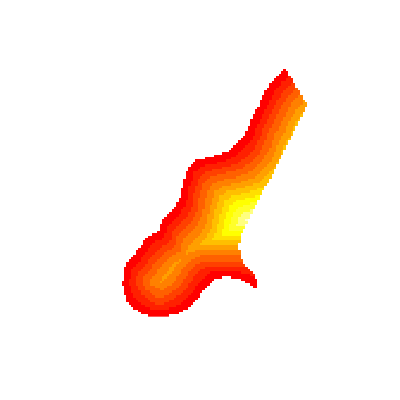

In [ ]:
# Résultat attendu ci-dessous...

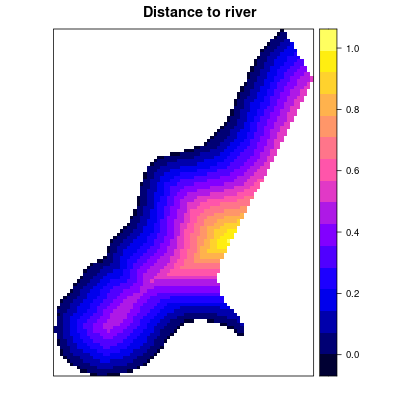

In [ ]:
# Résultat attendu ci-dessous...

***
## 3. Géostatistique univariée : résoudre les équations du krigeage et afficher les résultats sur la grille

<div class="alert alert-block alert-success">
	<img align="right" src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABmJLR0QA/wD/AP+gvaeTAAAACXBIWXMAAAbmAAAG5gFFAfPZAAAAB3RJTUUH3gwMFiIaKb3l3gAACBFJREFUeNrtW31sVWcZ/z23pSKtCYqXjW3R4DqEdpNVgzaKAXUE3ew2xRLHRKMuk3WajbQ6DW65M4jgGIiLZP5lxGmyofhBl8lWsMBWKBPWdC4zHRAj8lFoN6al68c9z88/7rnnnnPvOee+5/Z2O8a+bdP3vufet+f5Pc/v+TpvgakxNabG//OQydz85p90XDY+xuUk5wNIUpkkOZtkEqqzSU4nOUhiQKEDCYuDCgworAFR7R2aNv3Jo6mm4f8pAJpTL1UN1/S3KbEC1AaQQhLZHzhzLVzT3DV7bVjJXemE1da9YVV/7AG4aev+BbD0NySvR56QXuELBPV5n+uzyguk9bVDD32pPbYAND/xRMXwP5N/B1nLPC0bCVnwvoLPjhPaePih1cfKCUCiXBsNn0re5hZeiQNQ3CLUW0gccAsJHzAM1qZB8aulqV9MLycAleXaiMpPwhGeF6tGRj6z23ZgTandHW9UJE6DnOlvCcZrdcP/TtwAoD12FgBgDkEABIhdu13ee3eqaRjkrkINI0Tr8LcExYdjSQFSk9kbBazFIMV1UUguDtJwNFpYC2NJASEqNae9ecs3PPVg5Y/atwLAyA/a1xKcB9tC3F9AJAoAirfFEgDNi+tK3D+altaMRXBGqIZdYHgA8rMEEPF0gv5mO6O4k0Ow1vPsxfYv8QQgnMOYaAj0WEtMLUB3EjwMAqKEAlBbi2BWewQVUBD25CMErw8X3AfcOALw9Lobfxj1Mx/9zuMbYQNgnA+ovjUA3PRw5yeo2qDUBSCvAinM3kwm+QGhoNraZUbTtGjfswVQ7fBPQAmLOk+K5gPeNcfi+ltboViWd5uXkGAPVP6Ky9+xRySlEwagacu+JVTZqKqNICEej4wAhwav1xY6/ouusCcl+ANX8XIdBMsLuYjPAwqcfe0Znv3W7TLnkQslJ0JNWzpbVKWTZOPEkheftYJ8ACEUgCH3s9ZnAdBlsPQwz7VVlwRA08P7VqjiERNuolxrQfmAiefPCk51gWC9D+mhByMDcOvWv8wkEjtATZjk7xMscIzADdd6geCu1+l7+I875kYCwFL5MqkzvAmIqTZR1nwg1PQdITVPaIcGALUSSH8hEgBKfMMvAfHwFZNBi0KAfMZFW0szMwKGad+ei5oDcOPmve8ltc5IgEC+locC/gYvRzPVl7XIK6iP4Llri3iq+e1GAKhILVzaKFnDUQocn7UQs3+ep9ZeCdUrHMHhIzg8oAhGE1cbAZBQrTXOy8tW4Jimutzf8+ia/UiMLc8J7RIcIdYAvcYoESJZSzv/fjMLHINw90ZC9A6euyuJtGxyAHBif/5c7ejhXKs1o4CidvJjP6KGu1dILj22/e7jsPAoYL07hO8BlEhfY0YBYa1HHyVRoLS1PFu8APApCL+v1TMaetb1vch/rdkO1c8FJD1FKOFvAZWFFsC5Hs3Bx6EV0zB4VIh2Jbp1RI8c+dlXBidUap+5+4PQ9K9Bne8x9ayZO/MAGkT0Aa+DrA51aPn5QM7Dj4G8v6u6bzNSKeX5lhqkqxvwQOssI0kty56kAWA2yEbQaoQ1Ph9Q8XDaM88HpYD/AHW2WTVIniB5RQlcv2Apb+jevKqXZ9uWYk3rNiiuRUITRVP57M3CRKshjs4jdME+rxr5AJInS3NyaOnevKqX59rWQ7gXwAeM2u6FMTvPkUVxdGEJkQ6Y+QDihER2aPp4149v/y37W1eDXGfI7ADzLWrKAdrXkD0VIM8aASAZCkQqcNLpigd4/tuXg7rN8DlaOGcjOTpTUNhlRAELOBEx9g8e2fLFPlBvBfFOI62jSP5uWuQUpYTrtaY7jSygSiteGUeaAMUTAgMooGS3Ldsic5PP12oE7Yc6ukBKDKOm8rCRBexJffpVwudxNgILnJecHp1xt0Z9tGYFa7/A0Rns4/mb/L3M7Rwx7gfQ4mPGBY4y23mtit6t8RGGJYASBm5GWTsiNUQqx8Z2guw3a26qYbcmhMOBaWxEUPKtIzP6cG1XRyQAOjatfJ3AnSb5QGGSw4AbNIjZxUzZNPa7b0oSLSLQyF3hA+tX/EmATUXzAc/eNNRaEKcNQQkD1xPT5adSf3Bvyc8FDmxo/q5SP0vwdGA+oDbcWmJ4oiEoRSnhMcX/gPJ1qX/2ngk/GeradNuTAK5afN+O94xbFQ1UzrFzxsy38IWSw5xaf0CCezL3rs6enrrASZzUaVhk5pbrtWOBQ6hAD/525cuycqf1ph6T45lv9oBcaFiaZo+7fE+u3rkRb+EoHwCn78oA4CtoIChDIC8FJjlgTuPZfUT3Sd3BVTE8IBGlNHXmNaDWRCpxFe+K6QkRg8ZEaWms6zpR7uPN5QXAvDQt5icswPojyFkAl3jDW3mPiJQPAFg5jU6syBkDWS/1+48DAF/82DIInnYH93ICUL6ToqoDZYn90N9JfedxR9zrnnsGwAsuCxiMJwBId0V6UhMISnrUp6YadTGgO6YWgA7zfD4s88NKHvt40pG3d/GHIGjM3TEPxjIPAACebP45qHdG6+W53+eMIYA7IDIrc+YH0+x+3Tap77o3pk4QwDTci1F9P6hLojU4Cxx7DSAtect/xvmqtthmgjmKphLoO7YWYq0HdXqRXr3JlpcAuQ/1z24XKfdB2Un8rzGevPkyjI6sBvhVwD5wka/98NEL4S+RxmOysOt87GuBUDBe/tQsaLoOYB2gCzK/UQciCeAiBK9B0Q/weQgOoVIOyfznzmBqTI2pMTUmefwX5Mz8p5zVbn8AAAAASUVORK5CYII=" width="24"/>	<b>3.1 Préparation de l'affichage des résultats</b>
</div>

- Voici une fonction **plot_krige_results** pour afficher les résultats (prédiction et variance des erreurs d'estimation) sous forme de carte en y superposant les points d'échantillonnage sur un fond de carte géographique avec contextily, utilisez une image géoréférencée multi-bandes pour stocker les prédictions et la variance sur les prédictions.

In [80]:
def plot_krige_results(image_file, gdf, **kwargs):
    fig, ax = plt.subplots(figsize=(20,10), ncols=2)
    cmaps = kwargs.pop('cmaps', ['hsv', 'hot'])
    ax_titles = kwargs.pop('titles', ['predictions', 'variance'])
    fig_title = kwargs.pop('fig_title', '')
    data = [None, None]
    im = [None, None]
    for i in range(2):
        ax[i].set_title(ax_titles[i])
        gdf.plot(ax=ax[i], marker='x', color='grey')
        ctx.add_basemap(ax=ax[i], source=ctx.providers.OpenStreetMap.CH, crs="epsg:28992")
    with rio.open(image_file, 'r') as out:
        spatial_extent = [out.bounds.left, out.bounds.right, out.bounds.bottom, out.bounds.top]
        for i in range(2):
            data[i] = out.read(i+1, masked=True)
    for i in range(2):
        im[i] = ax[i].imshow(data[i], cmap=cmaps[i], extent=spatial_extent, **kwargs)
        fig.colorbar(im[i], ax=ax[i])  
    if fig_title!='':
        plt.savefig(fig_title+'.png')    
        fig.suptitle(fig_title, fontsize=20)

<div class="alert alert-block alert-success">
	<img align="right" src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAKQWlDQ1BJQ0MgUHJvZmlsZQAASA2dlndUU9kWh8+9N73QEiIgJfQaegkg0jtIFQRRiUmAUAKGhCZ2RAVGFBEpVmRUwAFHhyJjRRQLg4Ji1wnyEFDGwVFEReXdjGsJ7601896a/cdZ39nnt9fZZ+9917oAUPyCBMJ0WAGANKFYFO7rwVwSE8vE9wIYEAEOWAHA4WZmBEf4RALU/L09mZmoSMaz9u4ugGS72yy/UCZz1v9/kSI3QyQGAApF1TY8fiYX5QKUU7PFGTL/BMr0lSkyhjEyFqEJoqwi48SvbPan5iu7yZiXJuShGlnOGbw0noy7UN6aJeGjjAShXJgl4GejfAdlvVRJmgDl9yjT0/icTAAwFJlfzOcmoWyJMkUUGe6J8gIACJTEObxyDov5OWieAHimZ+SKBIlJYqYR15hp5ejIZvrxs1P5YjErlMNN4Yh4TM/0tAyOMBeAr2+WRQElWW2ZaJHtrRzt7VnW5mj5v9nfHn5T/T3IevtV8Sbsz55BjJ5Z32zsrC+9FgD2JFqbHbO+lVUAtG0GQOXhrE/vIADyBQC03pzzHoZsXpLE4gwnC4vs7GxzAZ9rLivoN/ufgm/Kv4Y595nL7vtWO6YXP4EjSRUzZUXlpqemS0TMzAwOl89k/fcQ/+PAOWnNycMsnJ/AF/GF6FVR6JQJhIlou4U8gViQLmQKhH/V4X8YNicHGX6daxRodV8AfYU5ULhJB8hvPQBDIwMkbj96An3rWxAxCsi+vGitka9zjzJ6/uf6Hwtcim7hTEEiU+b2DI9kciWiLBmj34RswQISkAd0oAo0gS4wAixgDRyAM3AD3iAAhIBIEAOWAy5IAmlABLJBPtgACkEx2AF2g2pwANSBetAEToI2cAZcBFfADXALDIBHQAqGwUswAd6BaQiC8BAVokGqkBakD5lC1hAbWgh5Q0FQOBQDxUOJkBCSQPnQJqgYKoOqoUNQPfQjdBq6CF2D+qAH0CA0Bv0BfYQRmALTYQ3YALaA2bA7HAhHwsvgRHgVnAcXwNvhSrgWPg63whfhG/AALIVfwpMIQMgIA9FGWAgb8URCkFgkAREha5EipAKpRZqQDqQbuY1IkXHkAwaHoWGYGBbGGeOHWYzhYlZh1mJKMNWYY5hWTBfmNmYQM4H5gqVi1bGmWCesP3YJNhGbjS3EVmCPYFuwl7ED2GHsOxwOx8AZ4hxwfrgYXDJuNa4Etw/XjLuA68MN4SbxeLwq3hTvgg/Bc/BifCG+Cn8cfx7fjx/GvyeQCVoEa4IPIZYgJGwkVBAaCOcI/YQRwjRRgahPdCKGEHnEXGIpsY7YQbxJHCZOkxRJhiQXUiQpmbSBVElqIl0mPSa9IZPJOmRHchhZQF5PriSfIF8lD5I/UJQoJhRPShxFQtlOOUq5QHlAeUOlUg2obtRYqpi6nVpPvUR9Sn0vR5Mzl/OX48mtk6uRa5Xrl3slT5TXl3eXXy6fJ18hf0r+pvy4AlHBQMFTgaOwVqFG4bTCPYVJRZqilWKIYppiiWKD4jXFUSW8koGStxJPqUDpsNIlpSEaQtOledK4tE20Otpl2jAdRzek+9OT6cX0H+i99AllJWVb5SjlHOUa5bPKUgbCMGD4M1IZpYyTjLuMj/M05rnP48/bNq9pXv+8KZX5Km4qfJUilWaVAZWPqkxVb9UU1Z2qbapP1DBqJmphatlq+9Uuq43Pp893ns+dXzT/5PyH6rC6iXq4+mr1w+o96pMamhq+GhkaVRqXNMY1GZpumsma5ZrnNMe0aFoLtQRa5VrntV4wlZnuzFRmJbOLOaGtru2nLdE+pN2rPa1jqLNYZ6NOs84TXZIuWzdBt1y3U3dCT0svWC9fr1HvoT5Rn62fpL9Hv1t/ysDQINpgi0GbwaihiqG/YZ5ho+FjI6qRq9Eqo1qjO8Y4Y7ZxivE+41smsImdSZJJjclNU9jU3lRgus+0zwxr5mgmNKs1u8eisNxZWaxG1qA5wzzIfKN5m/krCz2LWIudFt0WXyztLFMt6ywfWSlZBVhttOqw+sPaxJprXWN9x4Zq42Ozzqbd5rWtqS3fdr/tfTuaXbDdFrtOu8/2DvYi+yb7MQc9h3iHvQ732HR2KLuEfdUR6+jhuM7xjOMHJ3snsdNJp9+dWc4pzg3OowsMF/AX1C0YctFx4bgccpEuZC6MX3hwodRV25XjWuv6zE3Xjed2xG3E3dg92f24+ysPSw+RR4vHlKeT5xrPC16Il69XkVevt5L3Yu9q76c+Oj6JPo0+E752vqt9L/hh/QL9dvrd89fw5/rX+08EOASsCegKpARGBFYHPgsyCRIFdQTDwQHBu4IfL9JfJFzUFgJC/EN2hTwJNQxdFfpzGC4sNKwm7Hm4VXh+eHcELWJFREPEu0iPyNLIR4uNFksWd0bJR8VF1UdNRXtFl0VLl1gsWbPkRoxajCCmPRYfGxV7JHZyqffS3UuH4+ziCuPuLjNclrPs2nK15anLz66QX8FZcSoeGx8d3xD/iRPCqeVMrvRfuXflBNeTu4f7kufGK+eN8V34ZfyRBJeEsoTRRJfEXYljSa5JFUnjAk9BteB1sl/ygeSplJCUoykzqdGpzWmEtPi000IlYYqwK10zPSe9L8M0ozBDuspp1e5VE6JA0ZFMKHNZZruYjv5M9UiMJJslg1kLs2qy3mdHZZ/KUcwR5vTkmuRuyx3J88n7fjVmNXd1Z752/ob8wTXuaw6thdauXNu5Tnddwbrh9b7rj20gbUjZ8MtGy41lG99uit7UUaBRsL5gaLPv5sZCuUJR4b0tzlsObMVsFWzt3WazrWrblyJe0fViy+KK4k8l3JLr31l9V/ndzPaE7b2l9qX7d+B2CHfc3em681iZYlle2dCu4F2t5czyovK3u1fsvlZhW3FgD2mPZI+0MqiyvUqvakfVp+qk6oEaj5rmvep7t+2d2sfb17/fbX/TAY0DxQc+HhQcvH/I91BrrUFtxWHc4azDz+ui6rq/Z39ff0TtSPGRz0eFR6XHwo911TvU1zeoN5Q2wo2SxrHjccdv/eD1Q3sTq+lQM6O5+AQ4ITnx4sf4H++eDDzZeYp9qukn/Z/2ttBailqh1tzWibakNml7THvf6YDTnR3OHS0/m/989Iz2mZqzymdLz5HOFZybOZ93fvJCxoXxi4kXhzpXdD66tOTSna6wrt7LgZevXvG5cqnbvfv8VZerZ645XTt9nX297Yb9jdYeu56WX+x+aem172296XCz/ZbjrY6+BX3n+l37L972un3ljv+dGwOLBvruLr57/17cPel93v3RB6kPXj/Mejj9aP1j7OOiJwpPKp6qP6391fjXZqm99Oyg12DPs4hnj4a4Qy//lfmvT8MFz6nPK0a0RupHrUfPjPmM3Xqx9MXwy4yX0+OFvyn+tveV0auffnf7vWdiycTwa9HrmT9K3qi+OfrW9m3nZOjk03dp76anit6rvj/2gf2h+2P0x5Hp7E/4T5WfjT93fAn88ngmbWbm3/eE8/syOll+AAAACXBIWXMAAAE5AAABOQFgIaz4AAAWkUlEQVR4Ae1aeZxVxZWuutt7r7vZN0kQRZ0xgsaNjEswNC6DSkCM0lHjPkobzCAyyS+/kait46jRyUzi3qBmNE5mpjGAAVmM0O2SEbFbaZHWGDEgERAEpJe33HW+r+re16+bRsCZ5J90dd9769Zy6pyvTp1zqu4Tojf1ItCLQC8CvQj0ItCLwF8qAvL/IngURXL+/PnGkCFD5IQJE/xSWqx75ZWmQwxHHmaJ8MteEBxuGOZQIaMBgR8MDMOoPAxDR6AhygpSGm1Syl1hGOz2vHCbMMTGyAs+zlrRpm+dffbO7rQbGhrMysrKEH3C0rqDzVsH24HtKRwZwOAUOkhoNDauOzIQ/ilhEJ722prGkyxHHA6BhknHMTOOI4SUIgojEZqBgPC4IlIDvYQCXy1hmqHwPE+4wnczvtyyZOkLG1DTGEbha5FvvIFxt+BdAZ5MQlVVFYEopYTX/aeDAqCb4IqBNWvXjhF+NAV153ph4cRUKtXHSJlKAM91RRAAkmw2QL2Slo8QACqpkdfvBDVUebCMbCQBkAHAHNM0DwfNwyH0WaTnBu6nz/166Wohjed9N1iG8k3ooyahvr7egiYyf8BAHPASiIkrodevX+/k3OCCKAyvBaOVZeVlad/3RT6XFz70G8NjcpWQpC8hJC8loOIsyff4JAIxMKTCF0GFCSWAMQCI4UCbWJjLZncJKZYHXvREVdWUVShSqa6uzoRGFDUzKe/puV8AML7BjkCa3JhvNb9zVRD4N1m2/VVDGqIj20G19lAnwRRn1vg8Ick5xCsKSfk6r07hO8vieiwXqgYTcGFGGoZhOU5K5PM5IlSP0p9ceulFz5NfgjBt2jTaCMUOy3pKnwtA6ay/2dw8Bcv2jnQ6fQLXZy6bIxMhRDYgT8kMa4aVoF2EYzlYYFmPAOxPeE0XY5YARsWA2EJY6VRacrl5rrfCMMStl1xy0RsUeH/asE8AEuEbGxsHC9P+F6jeVUBTZLNZn8IhmRRE/SdMxYJ1KYvrdFPNPIBEx+JsAkMqEddNqGxDIqSadJSjFgAToBC2AUtLL6siEEQBKcDDzGQyBjTCwwh3b9jw7p01NTVhIoviutttLwBASLk2rqGmpuYzYYqeKi8rG7Fnzx4141JIUzGIEfhUguGp/vCKwiJjqp16V43RX+kuxzSxfCQWtIAaK5YSWmgR96fc8BTsj6cyprAztDXIkxcaVrY1cFED8WTTkHbKBs+crNfhei+/4oqqD/YFQhcASChZM2vfXl/t+d5jlmVhjeVdiGCTU7SJhT0g4RWT6GDZji1s2+YskzHS2YkZ22Ya5sdBGOyC8WyTkdEeicATWFVwpU4Q+uUAqBxM9vX9YBjaDwMHg6GNZeQLOIhCoQCP44Jc5IM1AwhwgtA0DDLpMjtfyO00pPj21VdfvhLaYOFShpyyMBUBQCfmCUDY2LzuHzNO6u629jYwKqBOkU2sIcjewseAqDrk4Yypy5wiw7Edk0J3dLSTdAvmZw1MxuuBFOtsGWxC4adwW3k895u4loFDP8PwhvqRd5QM5XEA81QIehJmeQQByeWyAk7IA5uwS5GBeg9gOdAYiGdeeP3133muuyYUAUiMBYT/fiaVvr+trVVrLNSV896j8ISDVbHqQ2iOZHAdhjBIrue1YFEvCP1wmWGEb+5L2AR8RJVFfohIy7RpkbjjDoFZUyP0hNJTTz01SNrp04H8VFiBC1Lp9KB8LselQiAs6IIPLbJhIDDb8vzp069aBnpFTVAD1tdHCCCk37R23YWWaS7I5XPgSdml/QuvjRLADkN4CAu6J3zPq8dMP5TPt66YOHFiR8J4bW2jXShsN3Yd0h5t2X1E9KWtbdH60TsiMT9psY/nNCF2tAyRlagePryP3DrgQzlwW4XctSsT1NR0huDz5tWNsm3/arByYyqVHtTe3qbCZExQQBCgmG0gceoNN1zbkoAgk5lvbm4e5YWiCUtggOu6tPSWmlvAyOkHIMzoGS95V7MeRlZFRbnI5rKNUpq3jx936tJEFNLvaa+Q1P8pnrW1dSMtq3A3lsZ3Cm4BK4+aGYYAxXbdwpuffLL5NABAwwG/FqfGt9YugNG4sLWtDQYvcvYnPIiyr4e1Z9MyG4a8syzt3DV27FgYMSG41l566aWwpuZ2wCaj0bPXzATdU2Qk2/FEtK8mJx6dDzQreeja7m3iBigG62SR7tE3ouBjYcjmwWVm42/vG8d9gkq1837xXVjTRzh5sANcnmEmUwYtzN0+Y8Z1d3JyFAAMchBUPYfgJmBgU5ztkplmmfrjMxYeBo7C7xCGecn4r5+yiqNScOzSgsSbkEmY1mj0rNUr7fIhZ/q5z4AHVlYisGK1U3id40hoxlYYj6l43+td10aBD1kL22Gylg+yokdff3DCatbU1j49DbbwP7EsTFw+dp1cpm3wvmO/973p76vNEOzVTMsiU5gWuBKOlgir8t2EB1O+k0rZvuduts3U355++tj3SgTv4mZIlAlTtcdH6B642DBIGtaSFAvFEi16XBfzod/Ui8oW23TWAyuE7NIaatjpKz91O6746xtX3Vt7sbwNhnf+o48+Odi2nUfgzukZXBjpPoVC/gYQmy3fWLv2RHjQNfDFFgQjANQthbzii8LHABAMEAjhWuhr6bfHfeMbp77NzdGYMWPcmO2uj0QDbnrtOWmlpgSFNgBkxACUCsVueC8+imLqcsWDrtZtknpNI77zwc2YY6T7ishtf/b3j55VRW186KF5C7CJuhAxSMEyrRTk3QircKKB44SJ5eXlUAtEUCXCK15KhEdWRWUw8pI+F8ZvBoXHOtq38CX8cjWTBnVBF5NXZikIn6qFKtMluk61IR+6E5sX26gXvOs6ZZOovbBfWPL5Pa5M9b14zIxV97GrJ607czkEdEKkEODRK+CApnC6gYjlDBoxUlEDkyn+c1A1MJ/xoPAj5WUZA/59yYRvfP0Z1EvsuJTR4yAHntQAqjlJFxOL9UvcgBwA6gSFeAqKfYrtS3ppEoyvzSC7W+SD4KZjpi8/6eYbr1kLTViOswVoceRBCzijf4MoMTo2X1DBGGPpeKi9hQcbTBZDTxxG/Cv5bNCnQkV+NO+fc1cmVw/CTrpj3J3FqkTVQADstXlh0wsj2vnOKE+pObhRQ6mO8WSVaBHDYhF50s7Y8BDXsSn2Wr9mnIL+koFREIXHWYinD4H6c3C14yICJK3+VFv9jkL40ZSBrfA7Qwf3+y0J0trzecBJIUxBlX1HN808n/xLEmYKKJsBZl9Bpsq5I5QGJAxThp2xAjeLbtgMaH+oabFhQhIZdJYhthZoNY5VOGpb40J9kXUCaD1CgxFc+0Wfvy/hFSCcfsvmfnstDZ7yoVIeBACcnSQpZMGsBqJTeKwpw+aBykzM0DLbEP2xJ/KjwJPCMYWEJ5eWcEIvNwmd50AZyuDhQTiOZ0qEJxBER4QAIAoOFZe+OOzII1s2vfeevRN+WU06tMu2gHYOfj1DFVcAoCcnqggGXqA24FQVYrhQBRqM7hJxDuhJ+am8qjHuKkPRdQkfKg9ZZBR8sOGR8ZvRlFdPqfmo767MCiv1b5HbATkjnE0kSRFCEZ7QGTAPGIy0KDP7nJeZubMlfKhgxHjBpOUBgPGxacmjAheBMFjsLrwiRNZQoS4eWnzBpIUlg7A8pZGg4l7dQJlmzyjjEGNq1jvrxWhfrO/cJEH7zPU1Y1xY9RWWn6dBSnGKtBaQdgJkJ9GEMmlSPo5tmtjdB3KThe1kc9pJHeUWXD1HiaDFJ7uhD95pQADYcBbs2IFNzEGluLlioKQrxyEd3ugh+aThR0pvyUViLsfGrpAJ0KcHNEGPsIhxxc2Q09V8xNRUkSqFmTdEkBO73Nb5O+4th8ansDUgCST5NkJ4+RIKObs8VdGzXPKk4FginC+JgweAEJxA388TI/bRhA70TpaSi9kiu53Coz7E6R4pNs3lvgKoMO7nhbwug/ChfxZPAtEa1gyVqFVckn5Ml9Lg2Am4yT+KhRO3b92aORTnJAMR7gls+CjLagvHBy90BNkOgMAvNRRK7QVIUNMik/jDOX0O+2zTtI7t33/wGahdSTeIZ4+hL8q7poReUloqvBqIw2nmsaNMsdnR177ap6Of4YcdsFtxssz+KTvKXwxB7onCHIXVp9BJA5JQeXoBDAKraUTeqywqeOaptmXwgIS27F3bDlYb48Z97XeAb3kGZ2hYDrEtJBXallh4hQbgx86LJzxA6SYSpBs8UC0gU5oxnSnmldBJHWYSbivyCw8cWf2bdYGdXZPqaG/KRKnGjFDXG3aYXycMZy6kq6AbpIi6N3lO6JA6OMMxXuThbEOIp1GA5tFkRvuI5KFQ8r9mz56dU5shP/J/5ndkLwIB7AdwB1H2UlkWxBcyZnt7e4gj6MnLlr14OYg8w+UA2j3vAzhql0Siirwu5SBILIkzzNEVjsT+WrVlra6L24YI9b0sbjSksV9hJ90Kd/0Cmp6R7pdyvPbH3593/up77nngRJz2ncMPTkHgbvGDaB67UN2NynHjXgGMj1VU9MHXl9AnQ+qPzGL9awCKg0S0BX4YPLZ4+fLjYQsYExCE/SQsvCKjzOBC4jhxJslhTC+I/DzmpYAYoICjYDx91w/5DPnlSTLK0061SLNIDQEUhe+bEoW214+WwSzWAM/bEP5mcBiNrZhx55w5N2/lqZCyqKqBDG7B4eWHOFNzuDHCxU9RikHyqkCgtwEtD5sHqFF56EaLFy1aOpogcDuMNsW1yobdU3dhu78rhAgDw9iI3x2wbYbGgg2d57sOcTXpWHiYb5yz8lQYTBuWZaT6OMLtWDE61TF18dzJ2R//+MEbDBlNxQYIx3X+sh/8YGYtCQCAAE5Aqg8HZ5xxxm5Ex5djn+zjxJ5H4B4WmAZBaQJsAgpjjcCewOVp0KFo8eqiRUvOxr4bhw0yqq2ttXsCQkGnhNOgamFJMMnpjAJajcS6BCLWIa/eyUVcp7I09ClLOhW2tMsAmL8x5bfP2vj4+ecufaRq2333PfhtOPyfwnjzCH0D9OcadmckSypKA8g8Z/DsysrXcI59id5/yE4QYkaS5QD+wEto5/MFD2ANgCV8YcGiJbeRaHV1tUcgSA8IYyPD4dRi1Rl1T4ToJnwiuJYWE0/vqwdPoNDdyQByOBvHHbGu9wb2BrUiLFyeSafG/m7epJ+x3f33P1wNb/E0vh+msGw/hfDfmjNn1idUfbpxtumismSaYKxseGUaYv46NsDmhwbOToRXs0CecMFr0NNguURWGbxILp9vAss106ZNWcK+TDwJrq4e6x1948vPRaY9JXQ7uBmx9pr5RHhKBgQVa3D90GpiQLvEGVOIafhwV0tOeljgHO/xTY+fpw5jf/RP80b1TeXvAn6Xqf2L525DfvIPfzi7cfr0Wnvu3GryoFIXAFjCWSQ6y5atmoiv9L8EegPbO9o9SEsG4B3oHjm2BkEBobxnFAJonsPzWHwVih5qbXVWVFdPxrZNiCNmvLwQLnRqUOjAl2QAoBIJ8R83JhJmMmQbcowvgHJYgZOkFCw/SMZBvO6keMAUSmmnhGVY4g+53NtXDduz8tgh2y6DvRtGeljSzfD5Vbfc8g/vc+ZxdYlb9gKA4yeasLy+/igY46fxoeQ0fiXC9x58bMDGA8E6mesCAgFBIAXjaeD7gMHPVtCeFtiRhf3SubpbGw67Jyud86Wb9TGnAFNJjnun8Ep+xKZlMrpsiOnVF4RZkZUi1eoat+EDbVXkdWBZqLA16aVA48jkW5r4EoW1PnnIZjGy/25RCKz/LuTE9Jqama3dZ57tmXoEgBUJCBBSPv/8C7fgDO1HDlxER3s7iuAqYZnZPwEBgiuZsCyIjAICn8Zgkx18W2wNV7w7wH1mWyr9FYc/JkBPJX834RnxAoAPt1sniIVnNpOPJA2/bsUiGLILbD/nYz3o42yCnjRAzoI3+IMnw+PT0pk0Ysv37769+ies7mnmk277BIAN6uoiLAe951+wePnxOEapAf5TGQ3yex90kj+MULEEOWFYlgCilwqBQPQkQ3vV7weKp7amomNw+lCgeUtSUQiU4Z/B/5Wjdv/yiEFtmzo8sx+0qr8l3PLWgnPksxuGH/sRvnP0gf7B8KJ5KR1aTCKDA3KrzNqS9X8q/uP8m/c188nwnwsAG0Eg9YMoGke+L1y4mPHvLCj7JCiEVcjnsbFA4KIlJhg0XbFmgCm6ZnzVJwC/2JaRX7EDUQDzamAtM0dR7wQPu3sx+6ufyaF9Cvi2iFbQKIUX4v53t1YED24eJI6wAsNTIYcGAN0UDX1XMwLNS3FJnrvx599cUVlTbzWUfEJjuyTFxih53ftJl4ZSn8Yx/slJA94b6hYuOTmfzV6DCZ6Mo7KRCDJM7rBcnBkCAERsQIRgKNnw5LdJvPCP5xQUOmafWfXGdxoXfNz0O2QW8SDxZCeKGFmHDWizz2kdIOr3GNGh+LaEpdBJA/1iQvzdHM694Maj8J9R9kJDDX7NBl5gPjhEl7RfAJLWsd+UNUBTiJfCqgu/2YS6JgBzG4LUs6B/50HicdDgv8Jegd8VGXUJHEGDDyVDCbsJH7qIbbVGMKcS7YsFTIVl6nNRbHsQ4LbnRvffvfU3ewaOorAJFdUjBjc2axY2Qb50yk8ecc2Sv//jz8UD4o4G0uziAdhPjasIHOQt1gg4ps4fKj78cF1Fv37hsdhtfg3zPxbqfwxs40j8nHBw/QeDzGe2pqOjnVDgq6QejfIzT+OHB1UdRzxixtHbZf9UG3C1tkN1NmLu3oEtaXKc8H8QzW164N1jViJYPSWgkNg7a80iSRBQicqGkfkTlCjcGVnhyVufuGiTmIbob37XX48dsAbElIuPJJKChTXGjx9v8IQIZfwlBL/Jxd/lavFJOj10QEV+8EcdziNfTjun+2GOs8CYXs+hXg16nQMFBxJta8vMHjX4k6UftQ38bM6s6/G9rygZskIc+ndL74WjWQiN5g8hulYmdLmaQt8znLJB2ETVoNs1YkzLXp/iv7AGkJHuiWCMHj1a0WxpaYnwrvwz2w2dvurZfo59kV8MhDhbittYAKUW7Cs3feacJH51zlvsx0S6ePBiwhfnmnDEtYuXwu+fF7pZHVmyplN4viHRgkBJTQdbwPCcLU9OfVFwCZcYxC+sAXqArncyVlrCwflbYmpLXzNEBEAOKThTF+HVO+0UF+VxA3N916EkdmF+TFfTrqQNwqmZNO6NfO885PmOodgzoY0S5FmGEh+7JRu/4LwLhSu18Gog1ThBlT3+3xM9SBV+rEjCAR2lllmPU8zrjMaFjEVipxspYzV39wD2VYzqTrg3wB1DIzY/MellxMl1UHEueGxsSpsp4VUXELQiRJ/Cck4ZfvVCdZIlKpVBVPV/UgCKTDMDNjFxyJA5YhHDoeRPmOcLzrGMkmP+LkTil/V6mSEqvyd0cy56YeeqIeQjzqmxVA9+avBhXsPw1i9dWTdSgUiDiPTnA4CGjwYbO0f4Y26TOTZUlLPOpIDRzDN6+LxESw4BPv73SWtB60kjVUH9x0kRaBT7leQQIGKbgk8JmYHY092hmtAgIv3ZAABvrTBYrjTNHVCGzyB3G/QAx7o8T4R1SGQGJHs5a8VxzzffkvdBxXfzIBHiaztRCoPGgQcHEltxkr7ikCt/NQHLKFRusWeyvaW9CPQi0ItALwK9CPwlIPC/yDieSTGcRMEAAAAASUVORK5CYII=" width="24"/>	<b>3.2 Krigeage ordinaire du Pb</b>
</div>

- Ajustez un modèle variographique

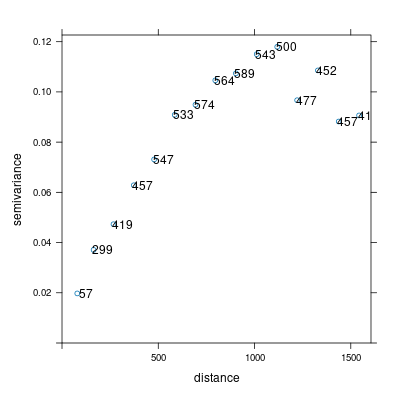

In [ ]:
# Résultat attendu ci-dessous...

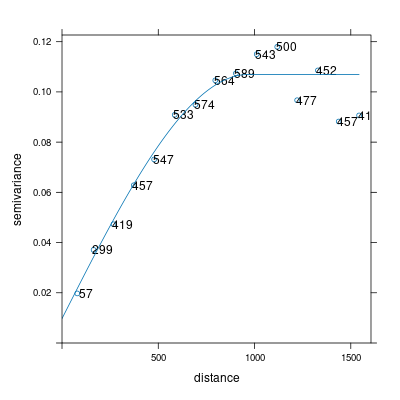

In [ ]:
# Résultat attendu ci-dessous...

- Menez l'estimation de la teneur à l'aide du krigeage ordinaire sur la grille 

In [ ]:
# Résultat attendu ci-dessous...

[using ordinary kriging]


- Affichez les résultats sous forme de cartes

In [84]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e2525523c62723e0a203c62723e0a3c62723e0a696d6167655f66696c65203c2d20272e2f6d657573655f70625f6f6b2e746966273c62723e0a6d5f70625f6f6b203c2d20737461636b286173286d657573652e70625f6f6b5b27766172312e70726564275d2c20225261737465724c6179657222292c206173286d657573652e70625f6f6b5b27766172312e766172275d2c20225261737465724c617965722229293c62723e0a7772697465526173746572286d5f70625f6f6b2c20696d6167655f66696c652c206f76657277726974653d54525545293c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions


/home/q/.local/share/virtualenvs/ModGeo-1d7LMbOH/lib/python3.8/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/home/q/.local/share/virtualenvs/ModGeo-1d7LMbOH/lib/python3.8/site-packages/matplotlib/image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


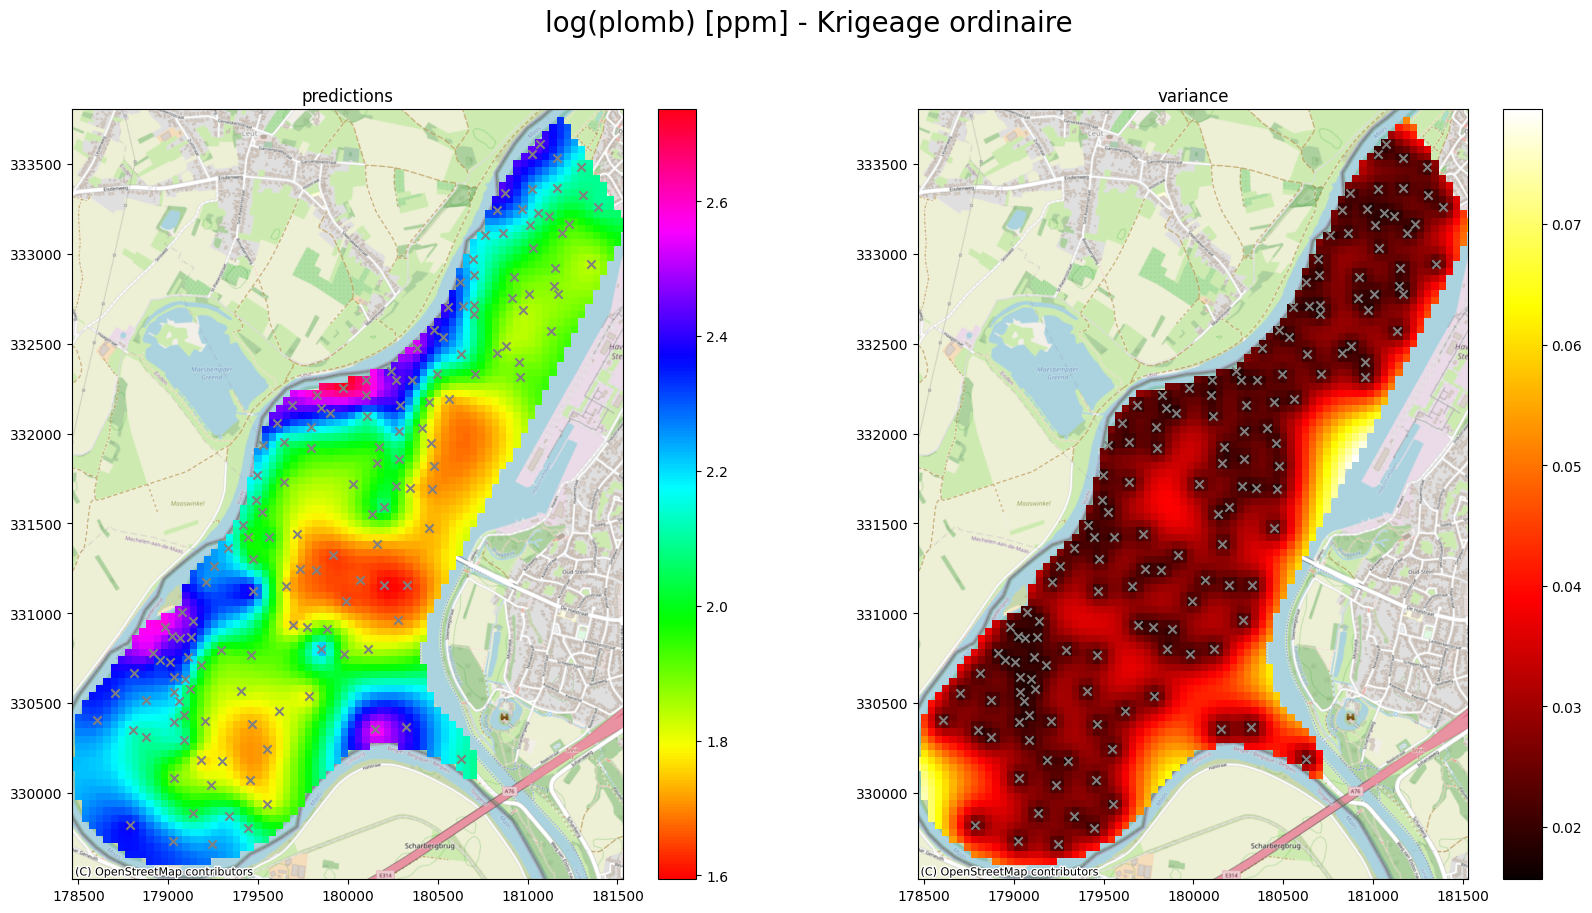

In [ ]:
# Résultat attendu ci-dessous...

<div class="alert alert-block alert-success">
	<img align="right" src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAKQWlDQ1BJQ0MgUHJvZmlsZQAASA2dlndUU9kWh8+9N73QEiIgJfQaegkg0jtIFQRRiUmAUAKGhCZ2RAVGFBEpVmRUwAFHhyJjRRQLg4Ji1wnyEFDGwVFEReXdjGsJ7601896a/cdZ39nnt9fZZ+9917oAUPyCBMJ0WAGANKFYFO7rwVwSE8vE9wIYEAEOWAHA4WZmBEf4RALU/L09mZmoSMaz9u4ugGS72yy/UCZz1v9/kSI3QyQGAApF1TY8fiYX5QKUU7PFGTL/BMr0lSkyhjEyFqEJoqwi48SvbPan5iu7yZiXJuShGlnOGbw0noy7UN6aJeGjjAShXJgl4GejfAdlvVRJmgDl9yjT0/icTAAwFJlfzOcmoWyJMkUUGe6J8gIACJTEObxyDov5OWieAHimZ+SKBIlJYqYR15hp5ejIZvrxs1P5YjErlMNN4Yh4TM/0tAyOMBeAr2+WRQElWW2ZaJHtrRzt7VnW5mj5v9nfHn5T/T3IevtV8Sbsz55BjJ5Z32zsrC+9FgD2JFqbHbO+lVUAtG0GQOXhrE/vIADyBQC03pzzHoZsXpLE4gwnC4vs7GxzAZ9rLivoN/ufgm/Kv4Y595nL7vtWO6YXP4EjSRUzZUXlpqemS0TMzAwOl89k/fcQ/+PAOWnNycMsnJ/AF/GF6FVR6JQJhIlou4U8gViQLmQKhH/V4X8YNicHGX6daxRodV8AfYU5ULhJB8hvPQBDIwMkbj96An3rWxAxCsi+vGitka9zjzJ6/uf6Hwtcim7hTEEiU+b2DI9kciWiLBmj34RswQISkAd0oAo0gS4wAixgDRyAM3AD3iAAhIBIEAOWAy5IAmlABLJBPtgACkEx2AF2g2pwANSBetAEToI2cAZcBFfADXALDIBHQAqGwUswAd6BaQiC8BAVokGqkBakD5lC1hAbWgh5Q0FQOBQDxUOJkBCSQPnQJqgYKoOqoUNQPfQjdBq6CF2D+qAH0CA0Bv0BfYQRmALTYQ3YALaA2bA7HAhHwsvgRHgVnAcXwNvhSrgWPg63whfhG/AALIVfwpMIQMgIA9FGWAgb8URCkFgkAREha5EipAKpRZqQDqQbuY1IkXHkAwaHoWGYGBbGGeOHWYzhYlZh1mJKMNWYY5hWTBfmNmYQM4H5gqVi1bGmWCesP3YJNhGbjS3EVmCPYFuwl7ED2GHsOxwOx8AZ4hxwfrgYXDJuNa4Etw/XjLuA68MN4SbxeLwq3hTvgg/Bc/BifCG+Cn8cfx7fjx/GvyeQCVoEa4IPIZYgJGwkVBAaCOcI/YQRwjRRgahPdCKGEHnEXGIpsY7YQbxJHCZOkxRJhiQXUiQpmbSBVElqIl0mPSa9IZPJOmRHchhZQF5PriSfIF8lD5I/UJQoJhRPShxFQtlOOUq5QHlAeUOlUg2obtRYqpi6nVpPvUR9Sn0vR5Mzl/OX48mtk6uRa5Xrl3slT5TXl3eXXy6fJ18hf0r+pvy4AlHBQMFTgaOwVqFG4bTCPYVJRZqilWKIYppiiWKD4jXFUSW8koGStxJPqUDpsNIlpSEaQtOledK4tE20Otpl2jAdRzek+9OT6cX0H+i99AllJWVb5SjlHOUa5bPKUgbCMGD4M1IZpYyTjLuMj/M05rnP48/bNq9pXv+8KZX5Km4qfJUilWaVAZWPqkxVb9UU1Z2qbapP1DBqJmphatlq+9Uuq43Pp893ns+dXzT/5PyH6rC6iXq4+mr1w+o96pMamhq+GhkaVRqXNMY1GZpumsma5ZrnNMe0aFoLtQRa5VrntV4wlZnuzFRmJbOLOaGtru2nLdE+pN2rPa1jqLNYZ6NOs84TXZIuWzdBt1y3U3dCT0svWC9fr1HvoT5Rn62fpL9Hv1t/ysDQINpgi0GbwaihiqG/YZ5ho+FjI6qRq9Eqo1qjO8Y4Y7ZxivE+41smsImdSZJJjclNU9jU3lRgus+0zwxr5mgmNKs1u8eisNxZWaxG1qA5wzzIfKN5m/krCz2LWIudFt0WXyztLFMt6ywfWSlZBVhttOqw+sPaxJprXWN9x4Zq42Ozzqbd5rWtqS3fdr/tfTuaXbDdFrtOu8/2DvYi+yb7MQc9h3iHvQ732HR2KLuEfdUR6+jhuM7xjOMHJ3snsdNJp9+dWc4pzg3OowsMF/AX1C0YctFx4bgccpEuZC6MX3hwodRV25XjWuv6zE3Xjed2xG3E3dg92f24+ysPSw+RR4vHlKeT5xrPC16Il69XkVevt5L3Yu9q76c+Oj6JPo0+E752vqt9L/hh/QL9dvrd89fw5/rX+08EOASsCegKpARGBFYHPgsyCRIFdQTDwQHBu4IfL9JfJFzUFgJC/EN2hTwJNQxdFfpzGC4sNKwm7Hm4VXh+eHcELWJFREPEu0iPyNLIR4uNFksWd0bJR8VF1UdNRXtFl0VLl1gsWbPkRoxajCCmPRYfGxV7JHZyqffS3UuH4+ziCuPuLjNclrPs2nK15anLz66QX8FZcSoeGx8d3xD/iRPCqeVMrvRfuXflBNeTu4f7kufGK+eN8V34ZfyRBJeEsoTRRJfEXYljSa5JFUnjAk9BteB1sl/ygeSplJCUoykzqdGpzWmEtPi000IlYYqwK10zPSe9L8M0ozBDuspp1e5VE6JA0ZFMKHNZZruYjv5M9UiMJJslg1kLs2qy3mdHZZ/KUcwR5vTkmuRuyx3J88n7fjVmNXd1Z752/ob8wTXuaw6thdauXNu5Tnddwbrh9b7rj20gbUjZ8MtGy41lG99uit7UUaBRsL5gaLPv5sZCuUJR4b0tzlsObMVsFWzt3WazrWrblyJe0fViy+KK4k8l3JLr31l9V/ndzPaE7b2l9qX7d+B2CHfc3em681iZYlle2dCu4F2t5czyovK3u1fsvlZhW3FgD2mPZI+0MqiyvUqvakfVp+qk6oEaj5rmvep7t+2d2sfb17/fbX/TAY0DxQc+HhQcvH/I91BrrUFtxWHc4azDz+ui6rq/Z39ff0TtSPGRz0eFR6XHwo911TvU1zeoN5Q2wo2SxrHjccdv/eD1Q3sTq+lQM6O5+AQ4ITnx4sf4H++eDDzZeYp9qukn/Z/2ttBailqh1tzWibakNml7THvf6YDTnR3OHS0/m/989Iz2mZqzymdLz5HOFZybOZ93fvJCxoXxi4kXhzpXdD66tOTSna6wrt7LgZevXvG5cqnbvfv8VZerZ645XTt9nX297Yb9jdYeu56WX+x+aem172296XCz/ZbjrY6+BX3n+l37L972un3ljv+dGwOLBvruLr57/17cPel93v3RB6kPXj/Mejj9aP1j7OOiJwpPKp6qP6391fjXZqm99Oyg12DPs4hnj4a4Qy//lfmvT8MFz6nPK0a0RupHrUfPjPmM3Xqx9MXwy4yX0+OFvyn+tveV0auffnf7vWdiycTwa9HrmT9K3qi+OfrW9m3nZOjk03dp76anit6rvj/2gf2h+2P0x5Hp7E/4T5WfjT93fAn88ngmbWbm3/eE8/syOll+AAAACXBIWXMAAAE5AAABOQFgIaz4AAAWkUlEQVR4Ae1aeZxVxZWuutt7r7vZN0kQRZ0xgsaNjEswNC6DSkCM0lHjPkobzCAyyS+/kait46jRyUzi3qBmNE5mpjGAAVmM0O2SEbFbaZHWGDEgERAEpJe33HW+r+re16+bRsCZ5J90dd9769Zy6pyvTp1zqu4Tojf1ItCLQC8CvQj0ItCLwF8qAvL/IngURXL+/PnGkCFD5IQJE/xSWqx75ZWmQwxHHmaJ8MteEBxuGOZQIaMBgR8MDMOoPAxDR6AhygpSGm1Syl1hGOz2vHCbMMTGyAs+zlrRpm+dffbO7rQbGhrMysrKEH3C0rqDzVsH24HtKRwZwOAUOkhoNDauOzIQ/ilhEJ722prGkyxHHA6BhknHMTOOI4SUIgojEZqBgPC4IlIDvYQCXy1hmqHwPE+4wnczvtyyZOkLG1DTGEbha5FvvIFxt+BdAZ5MQlVVFYEopYTX/aeDAqCb4IqBNWvXjhF+NAV153ph4cRUKtXHSJlKAM91RRAAkmw2QL2Slo8QACqpkdfvBDVUebCMbCQBkAHAHNM0DwfNwyH0WaTnBu6nz/166Wohjed9N1iG8k3ooyahvr7egiYyf8BAHPASiIkrodevX+/k3OCCKAyvBaOVZeVlad/3RT6XFz70G8NjcpWQpC8hJC8loOIsyff4JAIxMKTCF0GFCSWAMQCI4UCbWJjLZncJKZYHXvREVdWUVShSqa6uzoRGFDUzKe/puV8AML7BjkCa3JhvNb9zVRD4N1m2/VVDGqIj20G19lAnwRRn1vg8Ick5xCsKSfk6r07hO8vieiwXqgYTcGFGGoZhOU5K5PM5IlSP0p9ceulFz5NfgjBt2jTaCMUOy3pKnwtA6ay/2dw8Bcv2jnQ6fQLXZy6bIxMhRDYgT8kMa4aVoF2EYzlYYFmPAOxPeE0XY5YARsWA2EJY6VRacrl5rrfCMMStl1xy0RsUeH/asE8AEuEbGxsHC9P+F6jeVUBTZLNZn8IhmRRE/SdMxYJ1KYvrdFPNPIBEx+JsAkMqEddNqGxDIqSadJSjFgAToBC2AUtLL6siEEQBKcDDzGQyBjTCwwh3b9jw7p01NTVhIoviutttLwBASLk2rqGmpuYzYYqeKi8rG7Fnzx4141JIUzGIEfhUguGp/vCKwiJjqp16V43RX+kuxzSxfCQWtIAaK5YSWmgR96fc8BTsj6cyprAztDXIkxcaVrY1cFED8WTTkHbKBs+crNfhei+/4oqqD/YFQhcASChZM2vfXl/t+d5jlmVhjeVdiGCTU7SJhT0g4RWT6GDZji1s2+YskzHS2YkZ22Ya5sdBGOyC8WyTkdEeicATWFVwpU4Q+uUAqBxM9vX9YBjaDwMHg6GNZeQLOIhCoQCP44Jc5IM1AwhwgtA0DDLpMjtfyO00pPj21VdfvhLaYOFShpyyMBUBQCfmCUDY2LzuHzNO6u629jYwKqBOkU2sIcjewseAqDrk4Yypy5wiw7Edk0J3dLSTdAvmZw1MxuuBFOtsGWxC4adwW3k895u4loFDP8PwhvqRd5QM5XEA81QIehJmeQQByeWyAk7IA5uwS5GBeg9gOdAYiGdeeP3133muuyYUAUiMBYT/fiaVvr+trVVrLNSV896j8ISDVbHqQ2iOZHAdhjBIrue1YFEvCP1wmWGEb+5L2AR8RJVFfohIy7RpkbjjDoFZUyP0hNJTTz01SNrp04H8VFiBC1Lp9KB8LselQiAs6IIPLbJhIDDb8vzp069aBnpFTVAD1tdHCCCk37R23YWWaS7I5XPgSdml/QuvjRLADkN4CAu6J3zPq8dMP5TPt66YOHFiR8J4bW2jXShsN3Yd0h5t2X1E9KWtbdH60TsiMT9psY/nNCF2tAyRlagePryP3DrgQzlwW4XctSsT1NR0huDz5tWNsm3/arByYyqVHtTe3qbCZExQQBCgmG0gceoNN1zbkoAgk5lvbm4e5YWiCUtggOu6tPSWmlvAyOkHIMzoGS95V7MeRlZFRbnI5rKNUpq3jx936tJEFNLvaa+Q1P8pnrW1dSMtq3A3lsZ3Cm4BK4+aGYYAxXbdwpuffLL5NABAwwG/FqfGt9YugNG4sLWtDQYvcvYnPIiyr4e1Z9MyG4a8syzt3DV27FgYMSG41l566aWwpuZ2wCaj0bPXzATdU2Qk2/FEtK8mJx6dDzQreeja7m3iBigG62SR7tE3ouBjYcjmwWVm42/vG8d9gkq1837xXVjTRzh5sANcnmEmUwYtzN0+Y8Z1d3JyFAAMchBUPYfgJmBgU5ztkplmmfrjMxYeBo7C7xCGecn4r5+yiqNScOzSgsSbkEmY1mj0rNUr7fIhZ/q5z4AHVlYisGK1U3id40hoxlYYj6l43+td10aBD1kL22Gylg+yokdff3DCatbU1j49DbbwP7EsTFw+dp1cpm3wvmO/973p76vNEOzVTMsiU5gWuBKOlgir8t2EB1O+k0rZvuduts3U355++tj3SgTv4mZIlAlTtcdH6B642DBIGtaSFAvFEi16XBfzod/Ui8oW23TWAyuE7NIaatjpKz91O6746xtX3Vt7sbwNhnf+o48+Odi2nUfgzukZXBjpPoVC/gYQmy3fWLv2RHjQNfDFFgQjANQthbzii8LHABAMEAjhWuhr6bfHfeMbp77NzdGYMWPcmO2uj0QDbnrtOWmlpgSFNgBkxACUCsVueC8+imLqcsWDrtZtknpNI77zwc2YY6T7ishtf/b3j55VRW186KF5C7CJuhAxSMEyrRTk3QircKKB44SJ5eXlUAtEUCXCK15KhEdWRWUw8pI+F8ZvBoXHOtq38CX8cjWTBnVBF5NXZikIn6qFKtMluk61IR+6E5sX26gXvOs6ZZOovbBfWPL5Pa5M9b14zIxV97GrJ607czkEdEKkEODRK+CApnC6gYjlDBoxUlEDkyn+c1A1MJ/xoPAj5WUZA/59yYRvfP0Z1EvsuJTR4yAHntQAqjlJFxOL9UvcgBwA6gSFeAqKfYrtS3ppEoyvzSC7W+SD4KZjpi8/6eYbr1kLTViOswVoceRBCzijf4MoMTo2X1DBGGPpeKi9hQcbTBZDTxxG/Cv5bNCnQkV+NO+fc1cmVw/CTrpj3J3FqkTVQADstXlh0wsj2vnOKE+pObhRQ6mO8WSVaBHDYhF50s7Y8BDXsSn2Wr9mnIL+koFREIXHWYinD4H6c3C14yICJK3+VFv9jkL40ZSBrfA7Qwf3+y0J0trzecBJIUxBlX1HN808n/xLEmYKKJsBZl9Bpsq5I5QGJAxThp2xAjeLbtgMaH+oabFhQhIZdJYhthZoNY5VOGpb40J9kXUCaD1CgxFc+0Wfvy/hFSCcfsvmfnstDZ7yoVIeBACcnSQpZMGsBqJTeKwpw+aBykzM0DLbEP2xJ/KjwJPCMYWEJ5eWcEIvNwmd50AZyuDhQTiOZ0qEJxBER4QAIAoOFZe+OOzII1s2vfeevRN+WU06tMu2gHYOfj1DFVcAoCcnqggGXqA24FQVYrhQBRqM7hJxDuhJ+am8qjHuKkPRdQkfKg9ZZBR8sOGR8ZvRlFdPqfmo767MCiv1b5HbATkjnE0kSRFCEZ7QGTAPGIy0KDP7nJeZubMlfKhgxHjBpOUBgPGxacmjAheBMFjsLrwiRNZQoS4eWnzBpIUlg7A8pZGg4l7dQJlmzyjjEGNq1jvrxWhfrO/cJEH7zPU1Y1xY9RWWn6dBSnGKtBaQdgJkJ9GEMmlSPo5tmtjdB3KThe1kc9pJHeUWXD1HiaDFJ7uhD95pQADYcBbs2IFNzEGluLlioKQrxyEd3ugh+aThR0pvyUViLsfGrpAJ0KcHNEGPsIhxxc2Q09V8xNRUkSqFmTdEkBO73Nb5O+4th8ansDUgCST5NkJ4+RIKObs8VdGzXPKk4FginC+JgweAEJxA388TI/bRhA70TpaSi9kiu53Coz7E6R4pNs3lvgKoMO7nhbwug/ChfxZPAtEa1gyVqFVckn5Ml9Lg2Am4yT+KhRO3b92aORTnJAMR7gls+CjLagvHBy90BNkOgMAvNRRK7QVIUNMik/jDOX0O+2zTtI7t33/wGahdSTeIZ4+hL8q7poReUloqvBqIw2nmsaNMsdnR177ap6Of4YcdsFtxssz+KTvKXwxB7onCHIXVp9BJA5JQeXoBDAKraUTeqywqeOaptmXwgIS27F3bDlYb48Z97XeAb3kGZ2hYDrEtJBXallh4hQbgx86LJzxA6SYSpBs8UC0gU5oxnSnmldBJHWYSbivyCw8cWf2bdYGdXZPqaG/KRKnGjFDXG3aYXycMZy6kq6AbpIi6N3lO6JA6OMMxXuThbEOIp1GA5tFkRvuI5KFQ8r9mz56dU5shP/J/5ndkLwIB7AdwB1H2UlkWxBcyZnt7e4gj6MnLlr14OYg8w+UA2j3vAzhql0Siirwu5SBILIkzzNEVjsT+WrVlra6L24YI9b0sbjSksV9hJ90Kd/0Cmp6R7pdyvPbH3593/up77nngRJz2ncMPTkHgbvGDaB67UN2NynHjXgGMj1VU9MHXl9AnQ+qPzGL9awCKg0S0BX4YPLZ4+fLjYQsYExCE/SQsvCKjzOBC4jhxJslhTC+I/DzmpYAYoICjYDx91w/5DPnlSTLK0061SLNIDQEUhe+bEoW214+WwSzWAM/bEP5mcBiNrZhx55w5N2/lqZCyqKqBDG7B4eWHOFNzuDHCxU9RikHyqkCgtwEtD5sHqFF56EaLFy1aOpogcDuMNsW1yobdU3dhu78rhAgDw9iI3x2wbYbGgg2d57sOcTXpWHiYb5yz8lQYTBuWZaT6OMLtWDE61TF18dzJ2R//+MEbDBlNxQYIx3X+sh/8YGYtCQCAAE5Aqg8HZ5xxxm5Ex5djn+zjxJ5H4B4WmAZBaQJsAgpjjcCewOVp0KFo8eqiRUvOxr4bhw0yqq2ttXsCQkGnhNOgamFJMMnpjAJajcS6BCLWIa/eyUVcp7I09ClLOhW2tMsAmL8x5bfP2vj4+ecufaRq2333PfhtOPyfwnjzCH0D9OcadmckSypKA8g8Z/DsysrXcI59id5/yE4QYkaS5QD+wEto5/MFD2ANgCV8YcGiJbeRaHV1tUcgSA8IYyPD4dRi1Rl1T4ToJnwiuJYWE0/vqwdPoNDdyQByOBvHHbGu9wb2BrUiLFyeSafG/m7epJ+x3f33P1wNb/E0vh+msGw/hfDfmjNn1idUfbpxtumismSaYKxseGUaYv46NsDmhwbOToRXs0CecMFr0NNguURWGbxILp9vAss106ZNWcK+TDwJrq4e6x1948vPRaY9JXQ7uBmx9pr5RHhKBgQVa3D90GpiQLvEGVOIafhwV0tOeljgHO/xTY+fpw5jf/RP80b1TeXvAn6Xqf2L525DfvIPfzi7cfr0Wnvu3GryoFIXAFjCWSQ6y5atmoiv9L8EegPbO9o9SEsG4B3oHjm2BkEBobxnFAJonsPzWHwVih5qbXVWVFdPxrZNiCNmvLwQLnRqUOjAl2QAoBIJ8R83JhJmMmQbcowvgHJYgZOkFCw/SMZBvO6keMAUSmmnhGVY4g+53NtXDduz8tgh2y6DvRtGeljSzfD5Vbfc8g/vc+ZxdYlb9gKA4yeasLy+/igY46fxoeQ0fiXC9x58bMDGA8E6mesCAgFBIAXjaeD7gMHPVtCeFtiRhf3SubpbGw67Jyud86Wb9TGnAFNJjnun8Ep+xKZlMrpsiOnVF4RZkZUi1eoat+EDbVXkdWBZqLA16aVA48jkW5r4EoW1PnnIZjGy/25RCKz/LuTE9Jqama3dZ57tmXoEgBUJCBBSPv/8C7fgDO1HDlxER3s7iuAqYZnZPwEBgiuZsCyIjAICn8Zgkx18W2wNV7w7wH1mWyr9FYc/JkBPJX834RnxAoAPt1sniIVnNpOPJA2/bsUiGLILbD/nYz3o42yCnjRAzoI3+IMnw+PT0pk0Ysv37769+ies7mnmk277BIAN6uoiLAe951+wePnxOEapAf5TGQ3yex90kj+MULEEOWFYlgCilwqBQPQkQ3vV7weKp7amomNw+lCgeUtSUQiU4Z/B/5Wjdv/yiEFtmzo8sx+0qr8l3PLWgnPksxuGH/sRvnP0gf7B8KJ5KR1aTCKDA3KrzNqS9X8q/uP8m/c188nwnwsAG0Eg9YMoGke+L1y4mPHvLCj7JCiEVcjnsbFA4KIlJhg0XbFmgCm6ZnzVJwC/2JaRX7EDUQDzamAtM0dR7wQPu3sx+6ufyaF9Cvi2iFbQKIUX4v53t1YED24eJI6wAsNTIYcGAN0UDX1XMwLNS3FJnrvx599cUVlTbzWUfEJjuyTFxih53ftJl4ZSn8Yx/slJA94b6hYuOTmfzV6DCZ6Mo7KRCDJM7rBcnBkCAERsQIRgKNnw5LdJvPCP5xQUOmafWfXGdxoXfNz0O2QW8SDxZCeKGFmHDWizz2kdIOr3GNGh+LaEpdBJA/1iQvzdHM694Maj8J9R9kJDDX7NBl5gPjhEl7RfAJLWsd+UNUBTiJfCqgu/2YS6JgBzG4LUs6B/50HicdDgv8Jegd8VGXUJHEGDDyVDCbsJH7qIbbVGMKcS7YsFTIVl6nNRbHsQ4LbnRvffvfU3ewaOorAJFdUjBjc2axY2Qb50yk8ecc2Sv//jz8UD4o4G0uziAdhPjasIHOQt1gg4ps4fKj78cF1Fv37hsdhtfg3zPxbqfwxs40j8nHBw/QeDzGe2pqOjnVDgq6QejfIzT+OHB1UdRzxixtHbZf9UG3C1tkN1NmLu3oEtaXKc8H8QzW164N1jViJYPSWgkNg7a80iSRBQicqGkfkTlCjcGVnhyVufuGiTmIbob37XX48dsAbElIuPJJKChTXGjx9v8IQIZfwlBL/Jxd/lavFJOj10QEV+8EcdziNfTjun+2GOs8CYXs+hXg16nQMFBxJta8vMHjX4k6UftQ38bM6s6/G9rygZskIc+ndL74WjWQiN5g8hulYmdLmaQt8znLJB2ETVoNs1YkzLXp/iv7AGkJHuiWCMHj1a0WxpaYnwrvwz2w2dvurZfo59kV8MhDhbittYAKUW7Cs3feacJH51zlvsx0S6ePBiwhfnmnDEtYuXwu+fF7pZHVmyplN4viHRgkBJTQdbwPCcLU9OfVFwCZcYxC+sAXqArncyVlrCwflbYmpLXzNEBEAOKThTF+HVO+0UF+VxA3N916EkdmF+TFfTrqQNwqmZNO6NfO885PmOodgzoY0S5FmGEh+7JRu/4LwLhSu18Gog1ThBlT3+3xM9SBV+rEjCAR2lllmPU8zrjMaFjEVipxspYzV39wD2VYzqTrg3wB1DIzY/MellxMl1UHEueGxsSpsp4VUXELQiRJ/Cck4ZfvVCdZIlKpVBVPV/UgCKTDMDNjFxyJA5YhHDoeRPmOcLzrGMkmP+LkTil/V6mSEqvyd0cy56YeeqIeQjzqmxVA9+avBhXsPw1i9dWTdSgUiDiPTnA4CGjwYbO0f4Y26TOTZUlLPOpIDRzDN6+LxESw4BPv73SWtB60kjVUH9x0kRaBT7leQQIGKbgk8JmYHY092hmtAgIv3ZAABvrTBYrjTNHVCGzyB3G/QAx7o8T4R1SGQGJHs5a8VxzzffkvdBxXfzIBHiaztRCoPGgQcHEltxkr7ikCt/NQHLKFRusWeyvaW9CPQi0ItALwK9CPwlIPC/yDieSTGcRMEAAAAASUVORK5CYII=" width="24"/>	<b>3.3 Krigeage ordinaire du Zn</b>
</div>

- Ajustez un modèle variographique

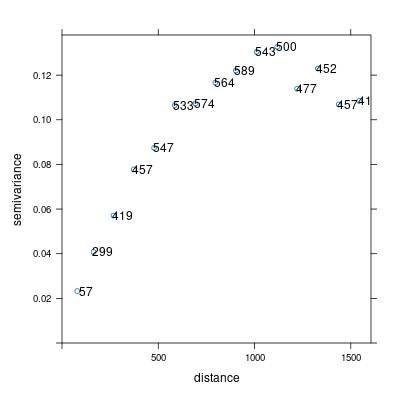

In [ ]:
# Résultat attendu ci-dessous...

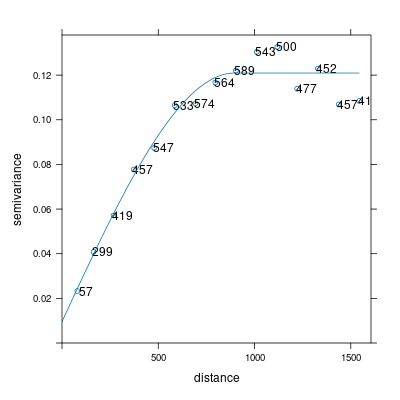

In [ ]:
# Résultat attendu ci-dessous...

- Menez l'estimation de la teneur à l'aide du krigeage ordinaire sur la grille 

In [ ]:
# Résultat attendu ci-dessous...

[using ordinary kriging]


- Affichez les résultats sous forme de cartes

/home/q/.local/share/virtualenvs/ModGeo-1d7LMbOH/lib/python3.8/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/home/q/.local/share/virtualenvs/ModGeo-1d7LMbOH/lib/python3.8/site-packages/matplotlib/image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


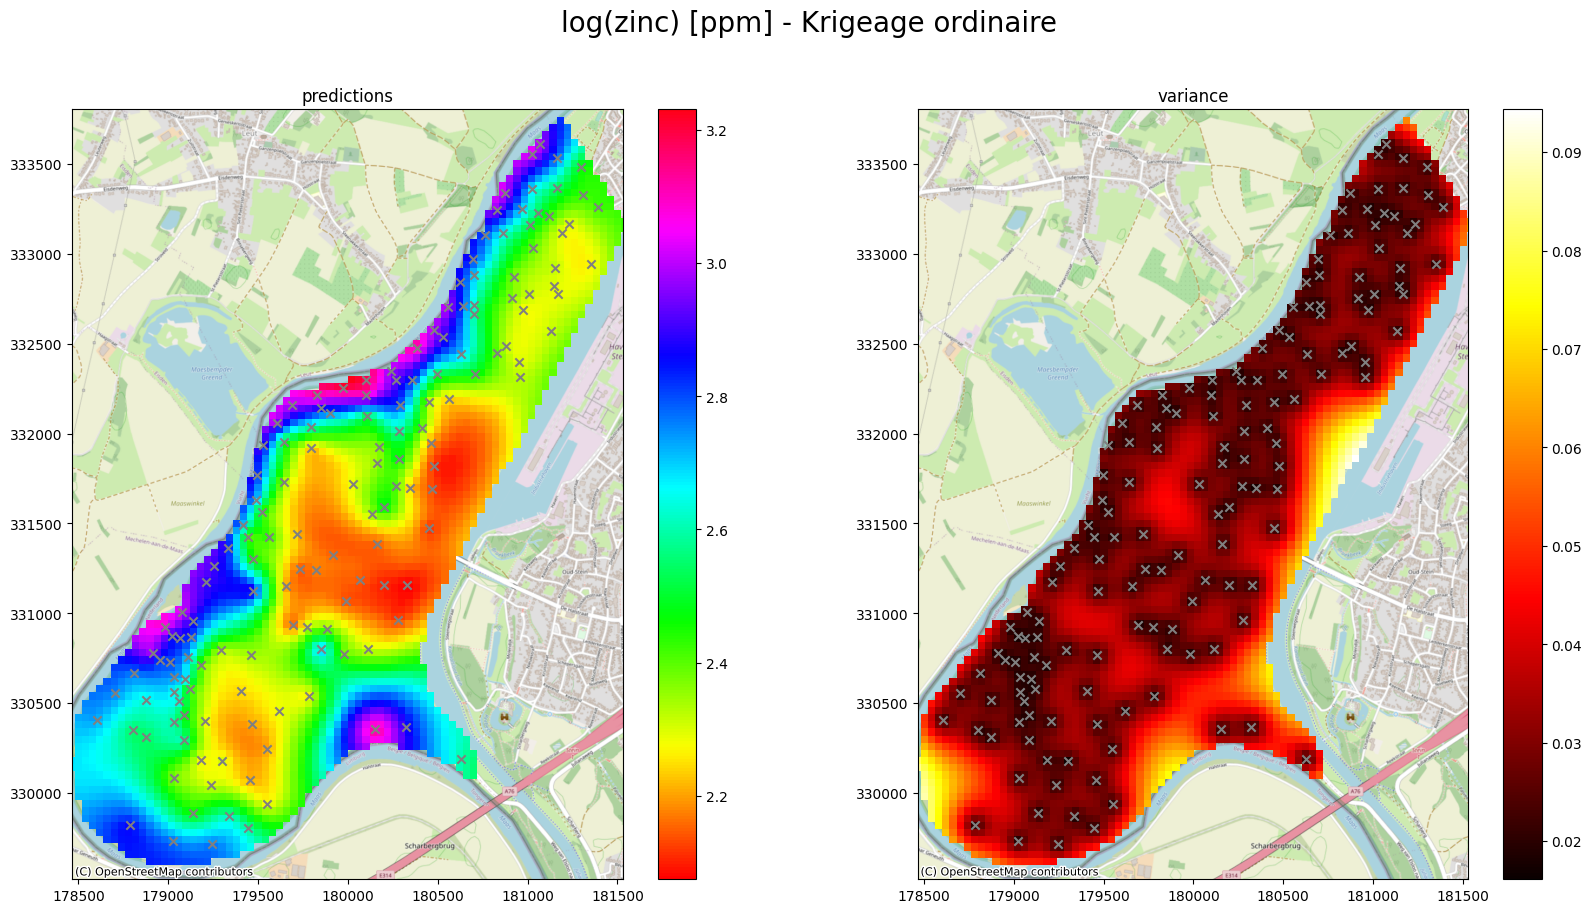

In [ ]:
# Résultat attendu ci-dessous...

***
## 4. Géostatistique multivariée : résoudre les équations du co-krigeage du Pb et du Zn et afficher les résultats sur la grille

<div class="alert alert-block alert-success">
	<img align="right" src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAKQWlDQ1BJQ0MgUHJvZmlsZQAASA2dlndUU9kWh8+9N73QEiIgJfQaegkg0jtIFQRRiUmAUAKGhCZ2RAVGFBEpVmRUwAFHhyJjRRQLg4Ji1wnyEFDGwVFEReXdjGsJ7601896a/cdZ39nnt9fZZ+9917oAUPyCBMJ0WAGANKFYFO7rwVwSE8vE9wIYEAEOWAHA4WZmBEf4RALU/L09mZmoSMaz9u4ugGS72yy/UCZz1v9/kSI3QyQGAApF1TY8fiYX5QKUU7PFGTL/BMr0lSkyhjEyFqEJoqwi48SvbPan5iu7yZiXJuShGlnOGbw0noy7UN6aJeGjjAShXJgl4GejfAdlvVRJmgDl9yjT0/icTAAwFJlfzOcmoWyJMkUUGe6J8gIACJTEObxyDov5OWieAHimZ+SKBIlJYqYR15hp5ejIZvrxs1P5YjErlMNN4Yh4TM/0tAyOMBeAr2+WRQElWW2ZaJHtrRzt7VnW5mj5v9nfHn5T/T3IevtV8Sbsz55BjJ5Z32zsrC+9FgD2JFqbHbO+lVUAtG0GQOXhrE/vIADyBQC03pzzHoZsXpLE4gwnC4vs7GxzAZ9rLivoN/ufgm/Kv4Y595nL7vtWO6YXP4EjSRUzZUXlpqemS0TMzAwOl89k/fcQ/+PAOWnNycMsnJ/AF/GF6FVR6JQJhIlou4U8gViQLmQKhH/V4X8YNicHGX6daxRodV8AfYU5ULhJB8hvPQBDIwMkbj96An3rWxAxCsi+vGitka9zjzJ6/uf6Hwtcim7hTEEiU+b2DI9kciWiLBmj34RswQISkAd0oAo0gS4wAixgDRyAM3AD3iAAhIBIEAOWAy5IAmlABLJBPtgACkEx2AF2g2pwANSBetAEToI2cAZcBFfADXALDIBHQAqGwUswAd6BaQiC8BAVokGqkBakD5lC1hAbWgh5Q0FQOBQDxUOJkBCSQPnQJqgYKoOqoUNQPfQjdBq6CF2D+qAH0CA0Bv0BfYQRmALTYQ3YALaA2bA7HAhHwsvgRHgVnAcXwNvhSrgWPg63whfhG/AALIVfwpMIQMgIA9FGWAgb8URCkFgkAREha5EipAKpRZqQDqQbuY1IkXHkAwaHoWGYGBbGGeOHWYzhYlZh1mJKMNWYY5hWTBfmNmYQM4H5gqVi1bGmWCesP3YJNhGbjS3EVmCPYFuwl7ED2GHsOxwOx8AZ4hxwfrgYXDJuNa4Etw/XjLuA68MN4SbxeLwq3hTvgg/Bc/BifCG+Cn8cfx7fjx/GvyeQCVoEa4IPIZYgJGwkVBAaCOcI/YQRwjRRgahPdCKGEHnEXGIpsY7YQbxJHCZOkxRJhiQXUiQpmbSBVElqIl0mPSa9IZPJOmRHchhZQF5PriSfIF8lD5I/UJQoJhRPShxFQtlOOUq5QHlAeUOlUg2obtRYqpi6nVpPvUR9Sn0vR5Mzl/OX48mtk6uRa5Xrl3slT5TXl3eXXy6fJ18hf0r+pvy4AlHBQMFTgaOwVqFG4bTCPYVJRZqilWKIYppiiWKD4jXFUSW8koGStxJPqUDpsNIlpSEaQtOledK4tE20Otpl2jAdRzek+9OT6cX0H+i99AllJWVb5SjlHOUa5bPKUgbCMGD4M1IZpYyTjLuMj/M05rnP48/bNq9pXv+8KZX5Km4qfJUilWaVAZWPqkxVb9UU1Z2qbapP1DBqJmphatlq+9Uuq43Pp893ns+dXzT/5PyH6rC6iXq4+mr1w+o96pMamhq+GhkaVRqXNMY1GZpumsma5ZrnNMe0aFoLtQRa5VrntV4wlZnuzFRmJbOLOaGtru2nLdE+pN2rPa1jqLNYZ6NOs84TXZIuWzdBt1y3U3dCT0svWC9fr1HvoT5Rn62fpL9Hv1t/ysDQINpgi0GbwaihiqG/YZ5ho+FjI6qRq9Eqo1qjO8Y4Y7ZxivE+41smsImdSZJJjclNU9jU3lRgus+0zwxr5mgmNKs1u8eisNxZWaxG1qA5wzzIfKN5m/krCz2LWIudFt0WXyztLFMt6ywfWSlZBVhttOqw+sPaxJprXWN9x4Zq42Ozzqbd5rWtqS3fdr/tfTuaXbDdFrtOu8/2DvYi+yb7MQc9h3iHvQ732HR2KLuEfdUR6+jhuM7xjOMHJ3snsdNJp9+dWc4pzg3OowsMF/AX1C0YctFx4bgccpEuZC6MX3hwodRV25XjWuv6zE3Xjed2xG3E3dg92f24+ysPSw+RR4vHlKeT5xrPC16Il69XkVevt5L3Yu9q76c+Oj6JPo0+E752vqt9L/hh/QL9dvrd89fw5/rX+08EOASsCegKpARGBFYHPgsyCRIFdQTDwQHBu4IfL9JfJFzUFgJC/EN2hTwJNQxdFfpzGC4sNKwm7Hm4VXh+eHcELWJFREPEu0iPyNLIR4uNFksWd0bJR8VF1UdNRXtFl0VLl1gsWbPkRoxajCCmPRYfGxV7JHZyqffS3UuH4+ziCuPuLjNclrPs2nK15anLz66QX8FZcSoeGx8d3xD/iRPCqeVMrvRfuXflBNeTu4f7kufGK+eN8V34ZfyRBJeEsoTRRJfEXYljSa5JFUnjAk9BteB1sl/ygeSplJCUoykzqdGpzWmEtPi000IlYYqwK10zPSe9L8M0ozBDuspp1e5VE6JA0ZFMKHNZZruYjv5M9UiMJJslg1kLs2qy3mdHZZ/KUcwR5vTkmuRuyx3J88n7fjVmNXd1Z752/ob8wTXuaw6thdauXNu5Tnddwbrh9b7rj20gbUjZ8MtGy41lG99uit7UUaBRsL5gaLPv5sZCuUJR4b0tzlsObMVsFWzt3WazrWrblyJe0fViy+KK4k8l3JLr31l9V/ndzPaE7b2l9qX7d+B2CHfc3em681iZYlle2dCu4F2t5czyovK3u1fsvlZhW3FgD2mPZI+0MqiyvUqvakfVp+qk6oEaj5rmvep7t+2d2sfb17/fbX/TAY0DxQc+HhQcvH/I91BrrUFtxWHc4azDz+ui6rq/Z39ff0TtSPGRz0eFR6XHwo911TvU1zeoN5Q2wo2SxrHjccdv/eD1Q3sTq+lQM6O5+AQ4ITnx4sf4H++eDDzZeYp9qukn/Z/2ttBailqh1tzWibakNml7THvf6YDTnR3OHS0/m/989Iz2mZqzymdLz5HOFZybOZ93fvJCxoXxi4kXhzpXdD66tOTSna6wrt7LgZevXvG5cqnbvfv8VZerZ645XTt9nX297Yb9jdYeu56WX+x+aem172296XCz/ZbjrY6+BX3n+l37L972un3ljv+dGwOLBvruLr57/17cPel93v3RB6kPXj/Mejj9aP1j7OOiJwpPKp6qP6391fjXZqm99Oyg12DPs4hnj4a4Qy//lfmvT8MFz6nPK0a0RupHrUfPjPmM3Xqx9MXwy4yX0+OFvyn+tveV0auffnf7vWdiycTwa9HrmT9K3qi+OfrW9m3nZOjk03dp76anit6rvj/2gf2h+2P0x5Hp7E/4T5WfjT93fAn88ngmbWbm3/eE8/syOll+AAAACXBIWXMAAAE5AAABOQFgIaz4AAAWkUlEQVR4Ae1aeZxVxZWuutt7r7vZN0kQRZ0xgsaNjEswNC6DSkCM0lHjPkobzCAyyS+/kait46jRyUzi3qBmNE5mpjGAAVmM0O2SEbFbaZHWGDEgERAEpJe33HW+r+re16+bRsCZ5J90dd9769Zy6pyvTp1zqu4Tojf1ItCLQC8CvQj0ItCLwF8qAvL/IngURXL+/PnGkCFD5IQJE/xSWqx75ZWmQwxHHmaJ8MteEBxuGOZQIaMBgR8MDMOoPAxDR6AhygpSGm1Syl1hGOz2vHCbMMTGyAs+zlrRpm+dffbO7rQbGhrMysrKEH3C0rqDzVsH24HtKRwZwOAUOkhoNDauOzIQ/ilhEJ722prGkyxHHA6BhknHMTOOI4SUIgojEZqBgPC4IlIDvYQCXy1hmqHwPE+4wnczvtyyZOkLG1DTGEbha5FvvIFxt+BdAZ5MQlVVFYEopYTX/aeDAqCb4IqBNWvXjhF+NAV153ph4cRUKtXHSJlKAM91RRAAkmw2QL2Slo8QACqpkdfvBDVUebCMbCQBkAHAHNM0DwfNwyH0WaTnBu6nz/166Wohjed9N1iG8k3ooyahvr7egiYyf8BAHPASiIkrodevX+/k3OCCKAyvBaOVZeVlad/3RT6XFz70G8NjcpWQpC8hJC8loOIsyff4JAIxMKTCF0GFCSWAMQCI4UCbWJjLZncJKZYHXvREVdWUVShSqa6uzoRGFDUzKe/puV8AML7BjkCa3JhvNb9zVRD4N1m2/VVDGqIj20G19lAnwRRn1vg8Ick5xCsKSfk6r07hO8vieiwXqgYTcGFGGoZhOU5K5PM5IlSP0p9ceulFz5NfgjBt2jTaCMUOy3pKnwtA6ay/2dw8Bcv2jnQ6fQLXZy6bIxMhRDYgT8kMa4aVoF2EYzlYYFmPAOxPeE0XY5YARsWA2EJY6VRacrl5rrfCMMStl1xy0RsUeH/asE8AEuEbGxsHC9P+F6jeVUBTZLNZn8IhmRRE/SdMxYJ1KYvrdFPNPIBEx+JsAkMqEddNqGxDIqSadJSjFgAToBC2AUtLL6siEEQBKcDDzGQyBjTCwwh3b9jw7p01NTVhIoviutttLwBASLk2rqGmpuYzYYqeKi8rG7Fnzx4141JIUzGIEfhUguGp/vCKwiJjqp16V43RX+kuxzSxfCQWtIAaK5YSWmgR96fc8BTsj6cyprAztDXIkxcaVrY1cFED8WTTkHbKBs+crNfhei+/4oqqD/YFQhcASChZM2vfXl/t+d5jlmVhjeVdiGCTU7SJhT0g4RWT6GDZji1s2+YskzHS2YkZ22Ya5sdBGOyC8WyTkdEeicATWFVwpU4Q+uUAqBxM9vX9YBjaDwMHg6GNZeQLOIhCoQCP44Jc5IM1AwhwgtA0DDLpMjtfyO00pPj21VdfvhLaYOFShpyyMBUBQCfmCUDY2LzuHzNO6u629jYwKqBOkU2sIcjewseAqDrk4Yypy5wiw7Edk0J3dLSTdAvmZw1MxuuBFOtsGWxC4adwW3k895u4loFDP8PwhvqRd5QM5XEA81QIehJmeQQByeWyAk7IA5uwS5GBeg9gOdAYiGdeeP3133muuyYUAUiMBYT/fiaVvr+trVVrLNSV896j8ISDVbHqQ2iOZHAdhjBIrue1YFEvCP1wmWGEb+5L2AR8RJVFfohIy7RpkbjjDoFZUyP0hNJTTz01SNrp04H8VFiBC1Lp9KB8LselQiAs6IIPLbJhIDDb8vzp069aBnpFTVAD1tdHCCCk37R23YWWaS7I5XPgSdml/QuvjRLADkN4CAu6J3zPq8dMP5TPt66YOHFiR8J4bW2jXShsN3Yd0h5t2X1E9KWtbdH60TsiMT9psY/nNCF2tAyRlagePryP3DrgQzlwW4XctSsT1NR0huDz5tWNsm3/arByYyqVHtTe3qbCZExQQBCgmG0gceoNN1zbkoAgk5lvbm4e5YWiCUtggOu6tPSWmlvAyOkHIMzoGS95V7MeRlZFRbnI5rKNUpq3jx936tJEFNLvaa+Q1P8pnrW1dSMtq3A3lsZ3Cm4BK4+aGYYAxXbdwpuffLL5NABAwwG/FqfGt9YugNG4sLWtDQYvcvYnPIiyr4e1Z9MyG4a8syzt3DV27FgYMSG41l566aWwpuZ2wCaj0bPXzATdU2Qk2/FEtK8mJx6dDzQreeja7m3iBigG62SR7tE3ouBjYcjmwWVm42/vG8d9gkq1837xXVjTRzh5sANcnmEmUwYtzN0+Y8Z1d3JyFAAMchBUPYfgJmBgU5ztkplmmfrjMxYeBo7C7xCGecn4r5+yiqNScOzSgsSbkEmY1mj0rNUr7fIhZ/q5z4AHVlYisGK1U3id40hoxlYYj6l43+td10aBD1kL22Gylg+yokdff3DCatbU1j49DbbwP7EsTFw+dp1cpm3wvmO/973p76vNEOzVTMsiU5gWuBKOlgir8t2EB1O+k0rZvuduts3U355++tj3SgTv4mZIlAlTtcdH6B642DBIGtaSFAvFEi16XBfzod/Ui8oW23TWAyuE7NIaatjpKz91O6746xtX3Vt7sbwNhnf+o48+Odi2nUfgzukZXBjpPoVC/gYQmy3fWLv2RHjQNfDFFgQjANQthbzii8LHABAMEAjhWuhr6bfHfeMbp77NzdGYMWPcmO2uj0QDbnrtOWmlpgSFNgBkxACUCsVueC8+imLqcsWDrtZtknpNI77zwc2YY6T7ishtf/b3j55VRW186KF5C7CJuhAxSMEyrRTk3QircKKB44SJ5eXlUAtEUCXCK15KhEdWRWUw8pI+F8ZvBoXHOtq38CX8cjWTBnVBF5NXZikIn6qFKtMluk61IR+6E5sX26gXvOs6ZZOovbBfWPL5Pa5M9b14zIxV97GrJ607czkEdEKkEODRK+CApnC6gYjlDBoxUlEDkyn+c1A1MJ/xoPAj5WUZA/59yYRvfP0Z1EvsuJTR4yAHntQAqjlJFxOL9UvcgBwA6gSFeAqKfYrtS3ppEoyvzSC7W+SD4KZjpi8/6eYbr1kLTViOswVoceRBCzijf4MoMTo2X1DBGGPpeKi9hQcbTBZDTxxG/Cv5bNCnQkV+NO+fc1cmVw/CTrpj3J3FqkTVQADstXlh0wsj2vnOKE+pObhRQ6mO8WSVaBHDYhF50s7Y8BDXsSn2Wr9mnIL+koFREIXHWYinD4H6c3C14yICJK3+VFv9jkL40ZSBrfA7Qwf3+y0J0trzecBJIUxBlX1HN808n/xLEmYKKJsBZl9Bpsq5I5QGJAxThp2xAjeLbtgMaH+oabFhQhIZdJYhthZoNY5VOGpb40J9kXUCaD1CgxFc+0Wfvy/hFSCcfsvmfnstDZ7yoVIeBACcnSQpZMGsBqJTeKwpw+aBykzM0DLbEP2xJ/KjwJPCMYWEJ5eWcEIvNwmd50AZyuDhQTiOZ0qEJxBER4QAIAoOFZe+OOzII1s2vfeevRN+WU06tMu2gHYOfj1DFVcAoCcnqggGXqA24FQVYrhQBRqM7hJxDuhJ+am8qjHuKkPRdQkfKg9ZZBR8sOGR8ZvRlFdPqfmo767MCiv1b5HbATkjnE0kSRFCEZ7QGTAPGIy0KDP7nJeZubMlfKhgxHjBpOUBgPGxacmjAheBMFjsLrwiRNZQoS4eWnzBpIUlg7A8pZGg4l7dQJlmzyjjEGNq1jvrxWhfrO/cJEH7zPU1Y1xY9RWWn6dBSnGKtBaQdgJkJ9GEMmlSPo5tmtjdB3KThe1kc9pJHeUWXD1HiaDFJ7uhD95pQADYcBbs2IFNzEGluLlioKQrxyEd3ugh+aThR0pvyUViLsfGrpAJ0KcHNEGPsIhxxc2Q09V8xNRUkSqFmTdEkBO73Nb5O+4th8ansDUgCST5NkJ4+RIKObs8VdGzXPKk4FginC+JgweAEJxA388TI/bRhA70TpaSi9kiu53Coz7E6R4pNs3lvgKoMO7nhbwug/ChfxZPAtEa1gyVqFVckn5Ml9Lg2Am4yT+KhRO3b92aORTnJAMR7gls+CjLagvHBy90BNkOgMAvNRRK7QVIUNMik/jDOX0O+2zTtI7t33/wGahdSTeIZ4+hL8q7poReUloqvBqIw2nmsaNMsdnR177ap6Of4YcdsFtxssz+KTvKXwxB7onCHIXVp9BJA5JQeXoBDAKraUTeqywqeOaptmXwgIS27F3bDlYb48Z97XeAb3kGZ2hYDrEtJBXallh4hQbgx86LJzxA6SYSpBs8UC0gU5oxnSnmldBJHWYSbivyCw8cWf2bdYGdXZPqaG/KRKnGjFDXG3aYXycMZy6kq6AbpIi6N3lO6JA6OMMxXuThbEOIp1GA5tFkRvuI5KFQ8r9mz56dU5shP/J/5ndkLwIB7AdwB1H2UlkWxBcyZnt7e4gj6MnLlr14OYg8w+UA2j3vAzhql0Siirwu5SBILIkzzNEVjsT+WrVlra6L24YI9b0sbjSksV9hJ90Kd/0Cmp6R7pdyvPbH3593/up77nngRJz2ncMPTkHgbvGDaB67UN2NynHjXgGMj1VU9MHXl9AnQ+qPzGL9awCKg0S0BX4YPLZ4+fLjYQsYExCE/SQsvCKjzOBC4jhxJslhTC+I/DzmpYAYoICjYDx91w/5DPnlSTLK0061SLNIDQEUhe+bEoW214+WwSzWAM/bEP5mcBiNrZhx55w5N2/lqZCyqKqBDG7B4eWHOFNzuDHCxU9RikHyqkCgtwEtD5sHqFF56EaLFy1aOpogcDuMNsW1yobdU3dhu78rhAgDw9iI3x2wbYbGgg2d57sOcTXpWHiYb5yz8lQYTBuWZaT6OMLtWDE61TF18dzJ2R//+MEbDBlNxQYIx3X+sh/8YGYtCQCAAE5Aqg8HZ5xxxm5Ex5djn+zjxJ5H4B4WmAZBaQJsAgpjjcCewOVp0KFo8eqiRUvOxr4bhw0yqq2ttXsCQkGnhNOgamFJMMnpjAJajcS6BCLWIa/eyUVcp7I09ClLOhW2tMsAmL8x5bfP2vj4+ecufaRq2333PfhtOPyfwnjzCH0D9OcadmckSypKA8g8Z/DsysrXcI59id5/yE4QYkaS5QD+wEto5/MFD2ANgCV8YcGiJbeRaHV1tUcgSA8IYyPD4dRi1Rl1T4ToJnwiuJYWE0/vqwdPoNDdyQByOBvHHbGu9wb2BrUiLFyeSafG/m7epJ+x3f33P1wNb/E0vh+msGw/hfDfmjNn1idUfbpxtumismSaYKxseGUaYv46NsDmhwbOToRXs0CecMFr0NNguURWGbxILp9vAss106ZNWcK+TDwJrq4e6x1948vPRaY9JXQ7uBmx9pr5RHhKBgQVa3D90GpiQLvEGVOIafhwV0tOeljgHO/xTY+fpw5jf/RP80b1TeXvAn6Xqf2L525DfvIPfzi7cfr0Wnvu3GryoFIXAFjCWSQ6y5atmoiv9L8EegPbO9o9SEsG4B3oHjm2BkEBobxnFAJonsPzWHwVih5qbXVWVFdPxrZNiCNmvLwQLnRqUOjAl2QAoBIJ8R83JhJmMmQbcowvgHJYgZOkFCw/SMZBvO6keMAUSmmnhGVY4g+53NtXDduz8tgh2y6DvRtGeljSzfD5Vbfc8g/vc+ZxdYlb9gKA4yeasLy+/igY46fxoeQ0fiXC9x58bMDGA8E6mesCAgFBIAXjaeD7gMHPVtCeFtiRhf3SubpbGw67Jyud86Wb9TGnAFNJjnun8Ep+xKZlMrpsiOnVF4RZkZUi1eoat+EDbVXkdWBZqLA16aVA48jkW5r4EoW1PnnIZjGy/25RCKz/LuTE9Jqama3dZ57tmXoEgBUJCBBSPv/8C7fgDO1HDlxER3s7iuAqYZnZPwEBgiuZsCyIjAICn8Zgkx18W2wNV7w7wH1mWyr9FYc/JkBPJX834RnxAoAPt1sniIVnNpOPJA2/bsUiGLILbD/nYz3o42yCnjRAzoI3+IMnw+PT0pk0Ysv37769+ies7mnmk277BIAN6uoiLAe951+wePnxOEapAf5TGQ3yex90kj+MULEEOWFYlgCilwqBQPQkQ3vV7weKp7amomNw+lCgeUtSUQiU4Z/B/5Wjdv/yiEFtmzo8sx+0qr8l3PLWgnPksxuGH/sRvnP0gf7B8KJ5KR1aTCKDA3KrzNqS9X8q/uP8m/c188nwnwsAG0Eg9YMoGke+L1y4mPHvLCj7JCiEVcjnsbFA4KIlJhg0XbFmgCm6ZnzVJwC/2JaRX7EDUQDzamAtM0dR7wQPu3sx+6ufyaF9Cvi2iFbQKIUX4v53t1YED24eJI6wAsNTIYcGAN0UDX1XMwLNS3FJnrvx599cUVlTbzWUfEJjuyTFxih53ftJl4ZSn8Yx/slJA94b6hYuOTmfzV6DCZ6Mo7KRCDJM7rBcnBkCAERsQIRgKNnw5LdJvPCP5xQUOmafWfXGdxoXfNz0O2QW8SDxZCeKGFmHDWizz2kdIOr3GNGh+LaEpdBJA/1iQvzdHM694Maj8J9R9kJDDX7NBl5gPjhEl7RfAJLWsd+UNUBTiJfCqgu/2YS6JgBzG4LUs6B/50HicdDgv8Jegd8VGXUJHEGDDyVDCbsJH7qIbbVGMKcS7YsFTIVl6nNRbHsQ4LbnRvffvfU3ewaOorAJFdUjBjc2axY2Qb50yk8ecc2Sv//jz8UD4o4G0uziAdhPjasIHOQt1gg4ps4fKj78cF1Fv37hsdhtfg3zPxbqfwxs40j8nHBw/QeDzGe2pqOjnVDgq6QejfIzT+OHB1UdRzxixtHbZf9UG3C1tkN1NmLu3oEtaXKc8H8QzW164N1jViJYPSWgkNg7a80iSRBQicqGkfkTlCjcGVnhyVufuGiTmIbob37XX48dsAbElIuPJJKChTXGjx9v8IQIZfwlBL/Jxd/lavFJOj10QEV+8EcdziNfTjun+2GOs8CYXs+hXg16nQMFBxJta8vMHjX4k6UftQ38bM6s6/G9rygZskIc+ndL74WjWQiN5g8hulYmdLmaQt8znLJB2ETVoNs1YkzLXp/iv7AGkJHuiWCMHj1a0WxpaYnwrvwz2w2dvurZfo59kV8MhDhbittYAKUW7Cs3feacJH51zlvsx0S6ePBiwhfnmnDEtYuXwu+fF7pZHVmyplN4viHRgkBJTQdbwPCcLU9OfVFwCZcYxC+sAXqArncyVlrCwflbYmpLXzNEBEAOKThTF+HVO+0UF+VxA3N916EkdmF+TFfTrqQNwqmZNO6NfO885PmOodgzoY0S5FmGEh+7JRu/4LwLhSu18Gog1ThBlT3+3xM9SBV+rEjCAR2lllmPU8zrjMaFjEVipxspYzV39wD2VYzqTrg3wB1DIzY/MellxMl1UHEueGxsSpsp4VUXELQiRJ/Cck4ZfvVCdZIlKpVBVPV/UgCKTDMDNjFxyJA5YhHDoeRPmOcLzrGMkmP+LkTil/V6mSEqvyd0cy56YeeqIeQjzqmxVA9+avBhXsPw1i9dWTdSgUiDiPTnA4CGjwYbO0f4Y26TOTZUlLPOpIDRzDN6+LxESw4BPv73SWtB60kjVUH9x0kRaBT7leQQIGKbgk8JmYHY092hmtAgIv3ZAABvrTBYrjTNHVCGzyB3G/QAx7o8T4R1SGQGJHs5a8VxzzffkvdBxXfzIBHiaztRCoPGgQcHEltxkr7ikCt/NQHLKFRusWeyvaW9CPQi0ItALwK9CPwlIPC/yDieSTGcRMEAAAAASUVORK5CYII=" width="24"/>	<b>4.1 Construire le modèle linéaire de co-régionalisation</b>
</div>

- Calculez le variogramme expérimental pour le jeu de données robena et affichez-le

<div class="alert alert-block alert-info">
<b>Info:</b><br>     <b>Pour construire les variogrammes expérimentaux simples et croisés, il faut définir un objet <code>gstat</code> comprenant les deux structures simples et l'employer ensuite dans la fonction <code>variogram</code>. </b> 
</div>

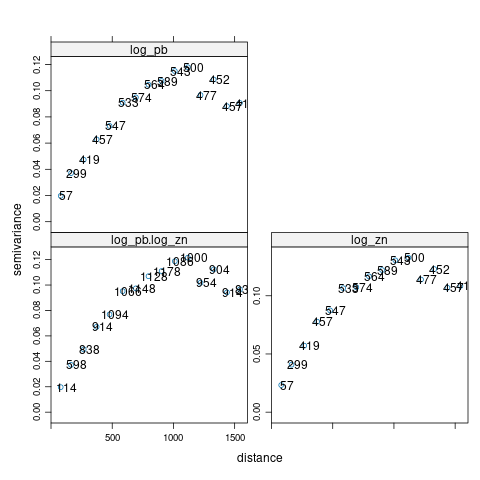

In [ ]:
# Résultat attendu ci-dessous...

- Ajustez un modèle linéaire de co-régionalisation au variogramme expérimental à l'aide de la fonction <code>fit.lmc</code>

In [114]:
%%R
?fit.lmc

File: /tmp/RtmpNRS6bV/Rtxt1469412637131
fit.lmc                 package:gstat                  R Documentation



Fit a Linear Model of Coregionalization to a Multivariable Sample

Variogram



Description:



     Fit a Linear Model of Coregionalization to a Multivariable Sample

     Variogram; in case of a single variogram model (i.e., no nugget)

     this is equivalent to Intrinsic Correlation



Usage:



     fit.lmc(v, g, model, fit.ranges = FALSE, fit.lmc = !fit.ranges, 

     correct.diagonal = 1.0, ...) 

     

Arguments:



       v: multivariable sample variogram, output of variogram



       g: gstat object, output of gstat



   model: variogram model, output of vgm; if supplied this value is

          used as initial value for each fit



fit.ranges: logical; determines whether the range coefficients

          (excluding that of the nugget component) should be fitted; or

          logical vector: determines for each range parameter of the

          variogram model

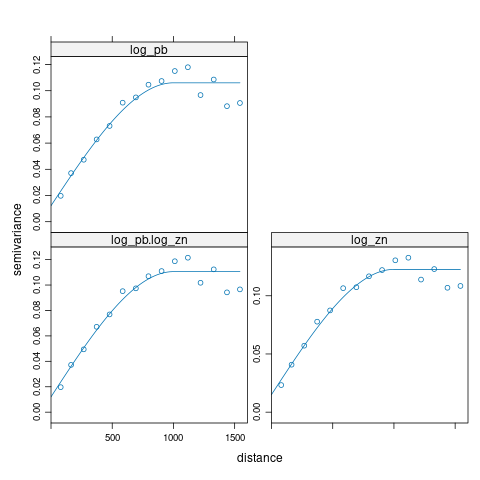

In [ ]:
# Résultat attendu ci-dessous...

<div class="alert alert-block alert-success">
	<img align="right" src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAKQWlDQ1BJQ0MgUHJvZmlsZQAASA2dlndUU9kWh8+9N73QEiIgJfQaegkg0jtIFQRRiUmAUAKGhCZ2RAVGFBEpVmRUwAFHhyJjRRQLg4Ji1wnyEFDGwVFEReXdjGsJ7601896a/cdZ39nnt9fZZ+9917oAUPyCBMJ0WAGANKFYFO7rwVwSE8vE9wIYEAEOWAHA4WZmBEf4RALU/L09mZmoSMaz9u4ugGS72yy/UCZz1v9/kSI3QyQGAApF1TY8fiYX5QKUU7PFGTL/BMr0lSkyhjEyFqEJoqwi48SvbPan5iu7yZiXJuShGlnOGbw0noy7UN6aJeGjjAShXJgl4GejfAdlvVRJmgDl9yjT0/icTAAwFJlfzOcmoWyJMkUUGe6J8gIACJTEObxyDov5OWieAHimZ+SKBIlJYqYR15hp5ejIZvrxs1P5YjErlMNN4Yh4TM/0tAyOMBeAr2+WRQElWW2ZaJHtrRzt7VnW5mj5v9nfHn5T/T3IevtV8Sbsz55BjJ5Z32zsrC+9FgD2JFqbHbO+lVUAtG0GQOXhrE/vIADyBQC03pzzHoZsXpLE4gwnC4vs7GxzAZ9rLivoN/ufgm/Kv4Y595nL7vtWO6YXP4EjSRUzZUXlpqemS0TMzAwOl89k/fcQ/+PAOWnNycMsnJ/AF/GF6FVR6JQJhIlou4U8gViQLmQKhH/V4X8YNicHGX6daxRodV8AfYU5ULhJB8hvPQBDIwMkbj96An3rWxAxCsi+vGitka9zjzJ6/uf6Hwtcim7hTEEiU+b2DI9kciWiLBmj34RswQISkAd0oAo0gS4wAixgDRyAM3AD3iAAhIBIEAOWAy5IAmlABLJBPtgACkEx2AF2g2pwANSBetAEToI2cAZcBFfADXALDIBHQAqGwUswAd6BaQiC8BAVokGqkBakD5lC1hAbWgh5Q0FQOBQDxUOJkBCSQPnQJqgYKoOqoUNQPfQjdBq6CF2D+qAH0CA0Bv0BfYQRmALTYQ3YALaA2bA7HAhHwsvgRHgVnAcXwNvhSrgWPg63whfhG/AALIVfwpMIQMgIA9FGWAgb8URCkFgkAREha5EipAKpRZqQDqQbuY1IkXHkAwaHoWGYGBbGGeOHWYzhYlZh1mJKMNWYY5hWTBfmNmYQM4H5gqVi1bGmWCesP3YJNhGbjS3EVmCPYFuwl7ED2GHsOxwOx8AZ4hxwfrgYXDJuNa4Etw/XjLuA68MN4SbxeLwq3hTvgg/Bc/BifCG+Cn8cfx7fjx/GvyeQCVoEa4IPIZYgJGwkVBAaCOcI/YQRwjRRgahPdCKGEHnEXGIpsY7YQbxJHCZOkxRJhiQXUiQpmbSBVElqIl0mPSa9IZPJOmRHchhZQF5PriSfIF8lD5I/UJQoJhRPShxFQtlOOUq5QHlAeUOlUg2obtRYqpi6nVpPvUR9Sn0vR5Mzl/OX48mtk6uRa5Xrl3slT5TXl3eXXy6fJ18hf0r+pvy4AlHBQMFTgaOwVqFG4bTCPYVJRZqilWKIYppiiWKD4jXFUSW8koGStxJPqUDpsNIlpSEaQtOledK4tE20Otpl2jAdRzek+9OT6cX0H+i99AllJWVb5SjlHOUa5bPKUgbCMGD4M1IZpYyTjLuMj/M05rnP48/bNq9pXv+8KZX5Km4qfJUilWaVAZWPqkxVb9UU1Z2qbapP1DBqJmphatlq+9Uuq43Pp893ns+dXzT/5PyH6rC6iXq4+mr1w+o96pMamhq+GhkaVRqXNMY1GZpumsma5ZrnNMe0aFoLtQRa5VrntV4wlZnuzFRmJbOLOaGtru2nLdE+pN2rPa1jqLNYZ6NOs84TXZIuWzdBt1y3U3dCT0svWC9fr1HvoT5Rn62fpL9Hv1t/ysDQINpgi0GbwaihiqG/YZ5ho+FjI6qRq9Eqo1qjO8Y4Y7ZxivE+41smsImdSZJJjclNU9jU3lRgus+0zwxr5mgmNKs1u8eisNxZWaxG1qA5wzzIfKN5m/krCz2LWIudFt0WXyztLFMt6ywfWSlZBVhttOqw+sPaxJprXWN9x4Zq42Ozzqbd5rWtqS3fdr/tfTuaXbDdFrtOu8/2DvYi+yb7MQc9h3iHvQ732HR2KLuEfdUR6+jhuM7xjOMHJ3snsdNJp9+dWc4pzg3OowsMF/AX1C0YctFx4bgccpEuZC6MX3hwodRV25XjWuv6zE3Xjed2xG3E3dg92f24+ysPSw+RR4vHlKeT5xrPC16Il69XkVevt5L3Yu9q76c+Oj6JPo0+E752vqt9L/hh/QL9dvrd89fw5/rX+08EOASsCegKpARGBFYHPgsyCRIFdQTDwQHBu4IfL9JfJFzUFgJC/EN2hTwJNQxdFfpzGC4sNKwm7Hm4VXh+eHcELWJFREPEu0iPyNLIR4uNFksWd0bJR8VF1UdNRXtFl0VLl1gsWbPkRoxajCCmPRYfGxV7JHZyqffS3UuH4+ziCuPuLjNclrPs2nK15anLz66QX8FZcSoeGx8d3xD/iRPCqeVMrvRfuXflBNeTu4f7kufGK+eN8V34ZfyRBJeEsoTRRJfEXYljSa5JFUnjAk9BteB1sl/ygeSplJCUoykzqdGpzWmEtPi000IlYYqwK10zPSe9L8M0ozBDuspp1e5VE6JA0ZFMKHNZZruYjv5M9UiMJJslg1kLs2qy3mdHZZ/KUcwR5vTkmuRuyx3J88n7fjVmNXd1Z752/ob8wTXuaw6thdauXNu5Tnddwbrh9b7rj20gbUjZ8MtGy41lG99uit7UUaBRsL5gaLPv5sZCuUJR4b0tzlsObMVsFWzt3WazrWrblyJe0fViy+KK4k8l3JLr31l9V/ndzPaE7b2l9qX7d+B2CHfc3em681iZYlle2dCu4F2t5czyovK3u1fsvlZhW3FgD2mPZI+0MqiyvUqvakfVp+qk6oEaj5rmvep7t+2d2sfb17/fbX/TAY0DxQc+HhQcvH/I91BrrUFtxWHc4azDz+ui6rq/Z39ff0TtSPGRz0eFR6XHwo911TvU1zeoN5Q2wo2SxrHjccdv/eD1Q3sTq+lQM6O5+AQ4ITnx4sf4H++eDDzZeYp9qukn/Z/2ttBailqh1tzWibakNml7THvf6YDTnR3OHS0/m/989Iz2mZqzymdLz5HOFZybOZ93fvJCxoXxi4kXhzpXdD66tOTSna6wrt7LgZevXvG5cqnbvfv8VZerZ645XTt9nX297Yb9jdYeu56WX+x+aem172296XCz/ZbjrY6+BX3n+l37L972un3ljv+dGwOLBvruLr57/17cPel93v3RB6kPXj/Mejj9aP1j7OOiJwpPKp6qP6391fjXZqm99Oyg12DPs4hnj4a4Qy//lfmvT8MFz6nPK0a0RupHrUfPjPmM3Xqx9MXwy4yX0+OFvyn+tveV0auffnf7vWdiycTwa9HrmT9K3qi+OfrW9m3nZOjk03dp76anit6rvj/2gf2h+2P0x5Hp7E/4T5WfjT93fAn88ngmbWbm3/eE8/syOll+AAAACXBIWXMAAAE5AAABOQFgIaz4AAAWkUlEQVR4Ae1aeZxVxZWuutt7r7vZN0kQRZ0xgsaNjEswNC6DSkCM0lHjPkobzCAyyS+/kait46jRyUzi3qBmNE5mpjGAAVmM0O2SEbFbaZHWGDEgERAEpJe33HW+r+re16+bRsCZ5J90dd9769Zy6pyvTp1zqu4Tojf1ItCLQC8CvQj0ItCLwF8qAvL/IngURXL+/PnGkCFD5IQJE/xSWqx75ZWmQwxHHmaJ8MteEBxuGOZQIaMBgR8MDMOoPAxDR6AhygpSGm1Syl1hGOz2vHCbMMTGyAs+zlrRpm+dffbO7rQbGhrMysrKEH3C0rqDzVsH24HtKRwZwOAUOkhoNDauOzIQ/ilhEJ722prGkyxHHA6BhknHMTOOI4SUIgojEZqBgPC4IlIDvYQCXy1hmqHwPE+4wnczvtyyZOkLG1DTGEbha5FvvIFxt+BdAZ5MQlVVFYEopYTX/aeDAqCb4IqBNWvXjhF+NAV153ph4cRUKtXHSJlKAM91RRAAkmw2QL2Slo8QACqpkdfvBDVUebCMbCQBkAHAHNM0DwfNwyH0WaTnBu6nz/166Wohjed9N1iG8k3ooyahvr7egiYyf8BAHPASiIkrodevX+/k3OCCKAyvBaOVZeVlad/3RT6XFz70G8NjcpWQpC8hJC8loOIsyff4JAIxMKTCF0GFCSWAMQCI4UCbWJjLZncJKZYHXvREVdWUVShSqa6uzoRGFDUzKe/puV8AML7BjkCa3JhvNb9zVRD4N1m2/VVDGqIj20G19lAnwRRn1vg8Ick5xCsKSfk6r07hO8vieiwXqgYTcGFGGoZhOU5K5PM5IlSP0p9ceulFz5NfgjBt2jTaCMUOy3pKnwtA6ay/2dw8Bcv2jnQ6fQLXZy6bIxMhRDYgT8kMa4aVoF2EYzlYYFmPAOxPeE0XY5YARsWA2EJY6VRacrl5rrfCMMStl1xy0RsUeH/asE8AEuEbGxsHC9P+F6jeVUBTZLNZn8IhmRRE/SdMxYJ1KYvrdFPNPIBEx+JsAkMqEddNqGxDIqSadJSjFgAToBC2AUtLL6siEEQBKcDDzGQyBjTCwwh3b9jw7p01NTVhIoviutttLwBASLk2rqGmpuYzYYqeKi8rG7Fnzx4141JIUzGIEfhUguGp/vCKwiJjqp16V43RX+kuxzSxfCQWtIAaK5YSWmgR96fc8BTsj6cyprAztDXIkxcaVrY1cFED8WTTkHbKBs+crNfhei+/4oqqD/YFQhcASChZM2vfXl/t+d5jlmVhjeVdiGCTU7SJhT0g4RWT6GDZji1s2+YskzHS2YkZ22Ya5sdBGOyC8WyTkdEeicATWFVwpU4Q+uUAqBxM9vX9YBjaDwMHg6GNZeQLOIhCoQCP44Jc5IM1AwhwgtA0DDLpMjtfyO00pPj21VdfvhLaYOFShpyyMBUBQCfmCUDY2LzuHzNO6u629jYwKqBOkU2sIcjewseAqDrk4Yypy5wiw7Edk0J3dLSTdAvmZw1MxuuBFOtsGWxC4adwW3k895u4loFDP8PwhvqRd5QM5XEA81QIehJmeQQByeWyAk7IA5uwS5GBeg9gOdAYiGdeeP3133muuyYUAUiMBYT/fiaVvr+trVVrLNSV896j8ISDVbHqQ2iOZHAdhjBIrue1YFEvCP1wmWGEb+5L2AR8RJVFfohIy7RpkbjjDoFZUyP0hNJTTz01SNrp04H8VFiBC1Lp9KB8LselQiAs6IIPLbJhIDDb8vzp069aBnpFTVAD1tdHCCCk37R23YWWaS7I5XPgSdml/QuvjRLADkN4CAu6J3zPq8dMP5TPt66YOHFiR8J4bW2jXShsN3Yd0h5t2X1E9KWtbdH60TsiMT9psY/nNCF2tAyRlagePryP3DrgQzlwW4XctSsT1NR0huDz5tWNsm3/arByYyqVHtTe3qbCZExQQBCgmG0gceoNN1zbkoAgk5lvbm4e5YWiCUtggOu6tPSWmlvAyOkHIMzoGS95V7MeRlZFRbnI5rKNUpq3jx936tJEFNLvaa+Q1P8pnrW1dSMtq3A3lsZ3Cm4BK4+aGYYAxXbdwpuffLL5NABAwwG/FqfGt9YugNG4sLWtDQYvcvYnPIiyr4e1Z9MyG4a8syzt3DV27FgYMSG41l566aWwpuZ2wCaj0bPXzATdU2Qk2/FEtK8mJx6dDzQreeja7m3iBigG62SR7tE3ouBjYcjmwWVm42/vG8d9gkq1837xXVjTRzh5sANcnmEmUwYtzN0+Y8Z1d3JyFAAMchBUPYfgJmBgU5ztkplmmfrjMxYeBo7C7xCGecn4r5+yiqNScOzSgsSbkEmY1mj0rNUr7fIhZ/q5z4AHVlYisGK1U3id40hoxlYYj6l43+td10aBD1kL22Gylg+yokdff3DCatbU1j49DbbwP7EsTFw+dp1cpm3wvmO/973p76vNEOzVTMsiU5gWuBKOlgir8t2EB1O+k0rZvuduts3U355++tj3SgTv4mZIlAlTtcdH6B642DBIGtaSFAvFEi16XBfzod/Ui8oW23TWAyuE7NIaatjpKz91O6746xtX3Vt7sbwNhnf+o48+Odi2nUfgzukZXBjpPoVC/gYQmy3fWLv2RHjQNfDFFgQjANQthbzii8LHABAMEAjhWuhr6bfHfeMbp77NzdGYMWPcmO2uj0QDbnrtOWmlpgSFNgBkxACUCsVueC8+imLqcsWDrtZtknpNI77zwc2YY6T7ishtf/b3j55VRW186KF5C7CJuhAxSMEyrRTk3QircKKB44SJ5eXlUAtEUCXCK15KhEdWRWUw8pI+F8ZvBoXHOtq38CX8cjWTBnVBF5NXZikIn6qFKtMluk61IR+6E5sX26gXvOs6ZZOovbBfWPL5Pa5M9b14zIxV97GrJ607czkEdEKkEODRK+CApnC6gYjlDBoxUlEDkyn+c1A1MJ/xoPAj5WUZA/59yYRvfP0Z1EvsuJTR4yAHntQAqjlJFxOL9UvcgBwA6gSFeAqKfYrtS3ppEoyvzSC7W+SD4KZjpi8/6eYbr1kLTViOswVoceRBCzijf4MoMTo2X1DBGGPpeKi9hQcbTBZDTxxG/Cv5bNCnQkV+NO+fc1cmVw/CTrpj3J3FqkTVQADstXlh0wsj2vnOKE+pObhRQ6mO8WSVaBHDYhF50s7Y8BDXsSn2Wr9mnIL+koFREIXHWYinD4H6c3C14yICJK3+VFv9jkL40ZSBrfA7Qwf3+y0J0trzecBJIUxBlX1HN808n/xLEmYKKJsBZl9Bpsq5I5QGJAxThp2xAjeLbtgMaH+oabFhQhIZdJYhthZoNY5VOGpb40J9kXUCaD1CgxFc+0Wfvy/hFSCcfsvmfnstDZ7yoVIeBACcnSQpZMGsBqJTeKwpw+aBykzM0DLbEP2xJ/KjwJPCMYWEJ5eWcEIvNwmd50AZyuDhQTiOZ0qEJxBER4QAIAoOFZe+OOzII1s2vfeevRN+WU06tMu2gHYOfj1DFVcAoCcnqggGXqA24FQVYrhQBRqM7hJxDuhJ+am8qjHuKkPRdQkfKg9ZZBR8sOGR8ZvRlFdPqfmo767MCiv1b5HbATkjnE0kSRFCEZ7QGTAPGIy0KDP7nJeZubMlfKhgxHjBpOUBgPGxacmjAheBMFjsLrwiRNZQoS4eWnzBpIUlg7A8pZGg4l7dQJlmzyjjEGNq1jvrxWhfrO/cJEH7zPU1Y1xY9RWWn6dBSnGKtBaQdgJkJ9GEMmlSPo5tmtjdB3KThe1kc9pJHeUWXD1HiaDFJ7uhD95pQADYcBbs2IFNzEGluLlioKQrxyEd3ugh+aThR0pvyUViLsfGrpAJ0KcHNEGPsIhxxc2Q09V8xNRUkSqFmTdEkBO73Nb5O+4th8ansDUgCST5NkJ4+RIKObs8VdGzXPKk4FginC+JgweAEJxA388TI/bRhA70TpaSi9kiu53Coz7E6R4pNs3lvgKoMO7nhbwug/ChfxZPAtEa1gyVqFVckn5Ml9Lg2Am4yT+KhRO3b92aORTnJAMR7gls+CjLagvHBy90BNkOgMAvNRRK7QVIUNMik/jDOX0O+2zTtI7t33/wGahdSTeIZ4+hL8q7poReUloqvBqIw2nmsaNMsdnR177ap6Of4YcdsFtxssz+KTvKXwxB7onCHIXVp9BJA5JQeXoBDAKraUTeqywqeOaptmXwgIS27F3bDlYb48Z97XeAb3kGZ2hYDrEtJBXallh4hQbgx86LJzxA6SYSpBs8UC0gU5oxnSnmldBJHWYSbivyCw8cWf2bdYGdXZPqaG/KRKnGjFDXG3aYXycMZy6kq6AbpIi6N3lO6JA6OMMxXuThbEOIp1GA5tFkRvuI5KFQ8r9mz56dU5shP/J/5ndkLwIB7AdwB1H2UlkWxBcyZnt7e4gj6MnLlr14OYg8w+UA2j3vAzhql0Siirwu5SBILIkzzNEVjsT+WrVlra6L24YI9b0sbjSksV9hJ90Kd/0Cmp6R7pdyvPbH3593/up77nngRJz2ncMPTkHgbvGDaB67UN2NynHjXgGMj1VU9MHXl9AnQ+qPzGL9awCKg0S0BX4YPLZ4+fLjYQsYExCE/SQsvCKjzOBC4jhxJslhTC+I/DzmpYAYoICjYDx91w/5DPnlSTLK0061SLNIDQEUhe+bEoW214+WwSzWAM/bEP5mcBiNrZhx55w5N2/lqZCyqKqBDG7B4eWHOFNzuDHCxU9RikHyqkCgtwEtD5sHqFF56EaLFy1aOpogcDuMNsW1yobdU3dhu78rhAgDw9iI3x2wbYbGgg2d57sOcTXpWHiYb5yz8lQYTBuWZaT6OMLtWDE61TF18dzJ2R//+MEbDBlNxQYIx3X+sh/8YGYtCQCAAE5Aqg8HZ5xxxm5Ex5djn+zjxJ5H4B4WmAZBaQJsAgpjjcCewOVp0KFo8eqiRUvOxr4bhw0yqq2ttXsCQkGnhNOgamFJMMnpjAJajcS6BCLWIa/eyUVcp7I09ClLOhW2tMsAmL8x5bfP2vj4+ecufaRq2333PfhtOPyfwnjzCH0D9OcadmckSypKA8g8Z/DsysrXcI59id5/yE4QYkaS5QD+wEto5/MFD2ANgCV8YcGiJbeRaHV1tUcgSA8IYyPD4dRi1Rl1T4ToJnwiuJYWE0/vqwdPoNDdyQByOBvHHbGu9wb2BrUiLFyeSafG/m7epJ+x3f33P1wNb/E0vh+msGw/hfDfmjNn1idUfbpxtumismSaYKxseGUaYv46NsDmhwbOToRXs0CecMFr0NNguURWGbxILp9vAss106ZNWcK+TDwJrq4e6x1948vPRaY9JXQ7uBmx9pr5RHhKBgQVa3D90GpiQLvEGVOIafhwV0tOeljgHO/xTY+fpw5jf/RP80b1TeXvAn6Xqf2L525DfvIPfzi7cfr0Wnvu3GryoFIXAFjCWSQ6y5atmoiv9L8EegPbO9o9SEsG4B3oHjm2BkEBobxnFAJonsPzWHwVih5qbXVWVFdPxrZNiCNmvLwQLnRqUOjAl2QAoBIJ8R83JhJmMmQbcowvgHJYgZOkFCw/SMZBvO6keMAUSmmnhGVY4g+53NtXDduz8tgh2y6DvRtGeljSzfD5Vbfc8g/vc+ZxdYlb9gKA4yeasLy+/igY46fxoeQ0fiXC9x58bMDGA8E6mesCAgFBIAXjaeD7gMHPVtCeFtiRhf3SubpbGw67Jyud86Wb9TGnAFNJjnun8Ep+xKZlMrpsiOnVF4RZkZUi1eoat+EDbVXkdWBZqLA16aVA48jkW5r4EoW1PnnIZjGy/25RCKz/LuTE9Jqama3dZ57tmXoEgBUJCBBSPv/8C7fgDO1HDlxER3s7iuAqYZnZPwEBgiuZsCyIjAICn8Zgkx18W2wNV7w7wH1mWyr9FYc/JkBPJX834RnxAoAPt1sniIVnNpOPJA2/bsUiGLILbD/nYz3o42yCnjRAzoI3+IMnw+PT0pk0Ysv37769+ies7mnmk277BIAN6uoiLAe951+wePnxOEapAf5TGQ3yex90kj+MULEEOWFYlgCilwqBQPQkQ3vV7weKp7amomNw+lCgeUtSUQiU4Z/B/5Wjdv/yiEFtmzo8sx+0qr8l3PLWgnPksxuGH/sRvnP0gf7B8KJ5KR1aTCKDA3KrzNqS9X8q/uP8m/c188nwnwsAG0Eg9YMoGke+L1y4mPHvLCj7JCiEVcjnsbFA4KIlJhg0XbFmgCm6ZnzVJwC/2JaRX7EDUQDzamAtM0dR7wQPu3sx+6ufyaF9Cvi2iFbQKIUX4v53t1YED24eJI6wAsNTIYcGAN0UDX1XMwLNS3FJnrvx599cUVlTbzWUfEJjuyTFxih53ftJl4ZSn8Yx/slJA94b6hYuOTmfzV6DCZ6Mo7KRCDJM7rBcnBkCAERsQIRgKNnw5LdJvPCP5xQUOmafWfXGdxoXfNz0O2QW8SDxZCeKGFmHDWizz2kdIOr3GNGh+LaEpdBJA/1iQvzdHM694Maj8J9R9kJDDX7NBl5gPjhEl7RfAJLWsd+UNUBTiJfCqgu/2YS6JgBzG4LUs6B/50HicdDgv8Jegd8VGXUJHEGDDyVDCbsJH7qIbbVGMKcS7YsFTIVl6nNRbHsQ4LbnRvffvfU3ewaOorAJFdUjBjc2axY2Qb50yk8ecc2Sv//jz8UD4o4G0uziAdhPjasIHOQt1gg4ps4fKj78cF1Fv37hsdhtfg3zPxbqfwxs40j8nHBw/QeDzGe2pqOjnVDgq6QejfIzT+OHB1UdRzxixtHbZf9UG3C1tkN1NmLu3oEtaXKc8H8QzW164N1jViJYPSWgkNg7a80iSRBQicqGkfkTlCjcGVnhyVufuGiTmIbob37XX48dsAbElIuPJJKChTXGjx9v8IQIZfwlBL/Jxd/lavFJOj10QEV+8EcdziNfTjun+2GOs8CYXs+hXg16nQMFBxJta8vMHjX4k6UftQ38bM6s6/G9rygZskIc+ndL74WjWQiN5g8hulYmdLmaQt8znLJB2ETVoNs1YkzLXp/iv7AGkJHuiWCMHj1a0WxpaYnwrvwz2w2dvurZfo59kV8MhDhbittYAKUW7Cs3feacJH51zlvsx0S6ePBiwhfnmnDEtYuXwu+fF7pZHVmyplN4viHRgkBJTQdbwPCcLU9OfVFwCZcYxC+sAXqArncyVlrCwflbYmpLXzNEBEAOKThTF+HVO+0UF+VxA3N916EkdmF+TFfTrqQNwqmZNO6NfO885PmOodgzoY0S5FmGEh+7JRu/4LwLhSu18Gog1ThBlT3+3xM9SBV+rEjCAR2lllmPU8zrjMaFjEVipxspYzV39wD2VYzqTrg3wB1DIzY/MellxMl1UHEueGxsSpsp4VUXELQiRJ/Cck4ZfvVCdZIlKpVBVPV/UgCKTDMDNjFxyJA5YhHDoeRPmOcLzrGMkmP+LkTil/V6mSEqvyd0cy56YeeqIeQjzqmxVA9+avBhXsPw1i9dWTdSgUiDiPTnA4CGjwYbO0f4Y26TOTZUlLPOpIDRzDN6+LxESw4BPv73SWtB60kjVUH9x0kRaBT7leQQIGKbgk8JmYHY092hmtAgIv3ZAABvrTBYrjTNHVCGzyB3G/QAx7o8T4R1SGQGJHs5a8VxzzffkvdBxXfzIBHiaztRCoPGgQcHEltxkr7ikCt/NQHLKFRusWeyvaW9CPQi0ItALwK9CPwlIPC/yDieSTGcRMEAAAAASUVORK5CYII=" width="24"/>	<b>4.2 Co-krigeage des teneurs en Pb et en Zn </b>
</div>

- Réalisez le co-krigeage à l'aide de la fonction <code>predict</code> et affichez le résumé des résultats obtenus sur le co-krigeage du plomb

In [28]:
%%R
?predict

Help on topic ‘predict’ was found in the following packages:

  Package               Library
  gstat                 /home/q/R/x86_64-pc-linux-gnu-library/4.1
  stats                 /usr/lib/R/library
  raster                /home/q/R/x86_64-pc-linux-gnu-library/4.1
  terra                 /home/q/R/x86_64-pc-linux-gnu-library/4.1

File: /tmp/Rtmpac2q5u/Rtxt81375ae1590a
predict                 package:gstat                  R Documentation



Multivariable Geostatistical Prediction and Simulation



Description:



     The function provides the following prediction methods: simple,

     ordinary, and universal kriging, simple, ordinary, and universal

     cokriging, point- or block-kriging, and conditional simulation

     equivalents for each of the kriging methods.



Usage:



     ## S3 method for class 'gstat'

     predict(object, newdata, block = numeric(0), nsim = 0, 

             indicators = FALSE, BLUE = FALSE, debug.level = 1, mask, 

             na.action = na.pass,

In [ ]:
# Résultat attendu ci-dessous...

Linear Model of Coregionalization found. Good.
[using ordinary cokriging]
Object of class SpatialPixelsDataFrame
Coordinates:
     min    max
 178440 181560
 329600 333760
Is projected: TRUE 
proj4string : [+init=epsg:28992]
Number of points: 3103
Grid attributes:
  cellcentre.offset cellsize cells.dim
            178460       40        78
            329620       40       104
Data attributes:
  log_pb.pred   
 Min.   :1.611  
 1st Qu.:1.839  
 Median :1.981  
 Mean   :2.019  
 3rd Qu.:2.204  
 Max.   :2.719  
Object of class SpatialPixelsDataFrame
Coordinates:
     min    max
 178440 181560
 329600 333760
Is projected: TRUE 
proj4string : [+init=epsg:28992]
Number of points: 3103
Grid attributes:
  cellcentre.offset cellsize cells.dim
            178460       40        78
            329620       40       104
Data attributes:
   log_pb.var     
 Min.   :0.01855  
 1st Qu.:0.02596  
 Median :0.02955  
 Mean   :0.03290  
 3rd Qu.:0.03663  
 Max.   :0.07821  


###### Affichez les résultats sous forme de cartes :

- Carte des logs des teneurs en <b>plomb</b> et de la variance d'estimation

/home/q/.local/share/virtualenvs/ModGeo-1d7LMbOH/lib/python3.8/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/home/q/.local/share/virtualenvs/ModGeo-1d7LMbOH/lib/python3.8/site-packages/matplotlib/image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


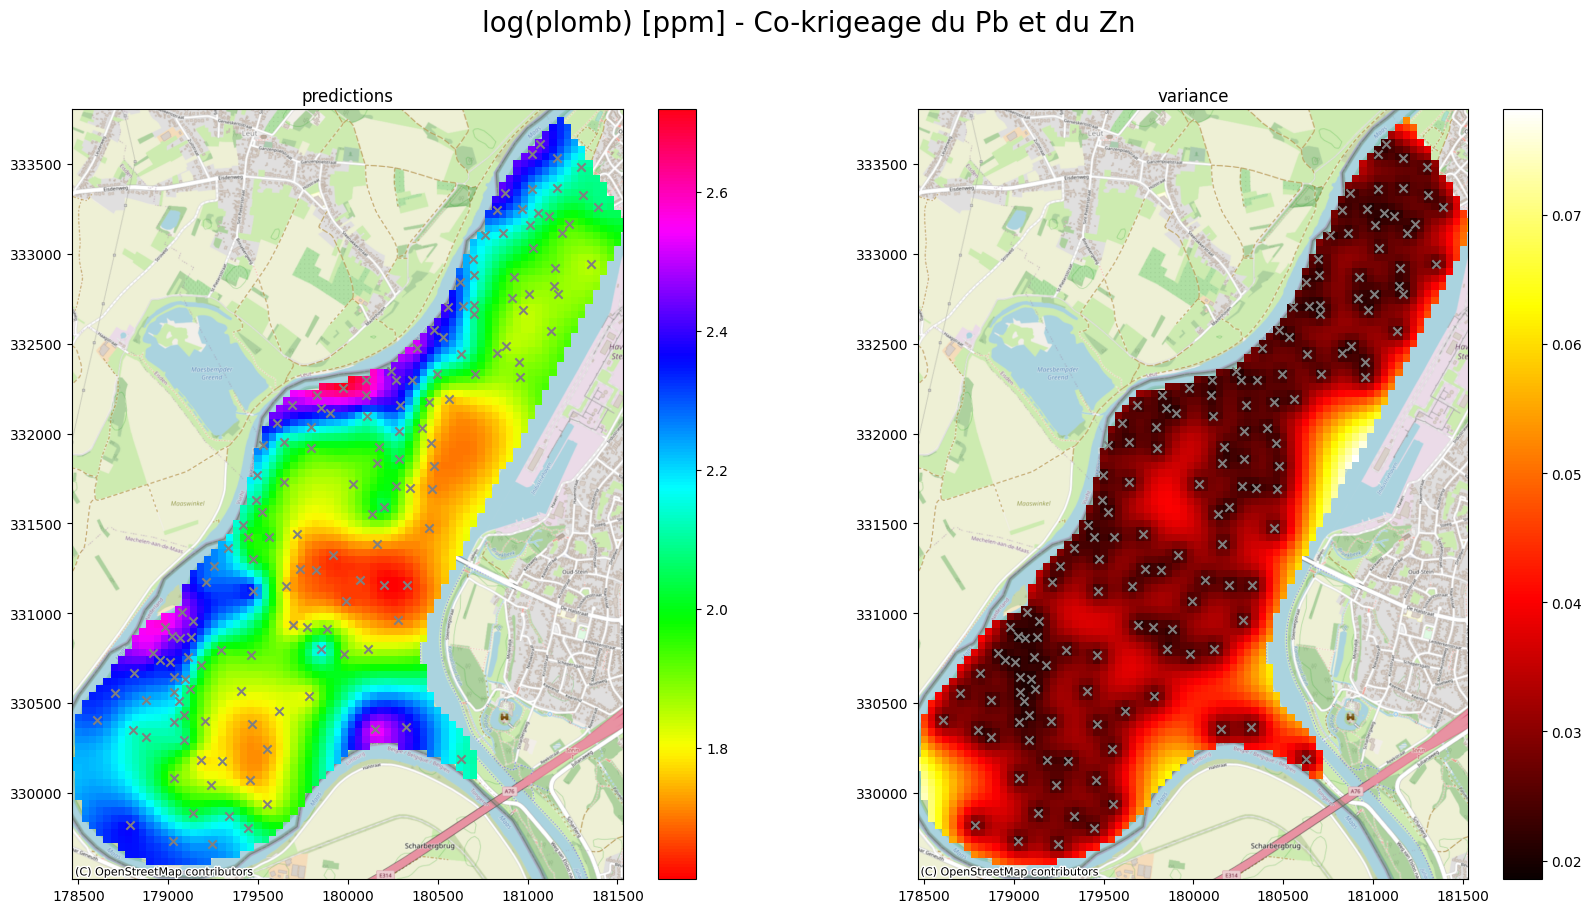

In [ ]:
# Résultat attendu ci-dessous...

- Carte des logs des teneurs en <b>zinc</b> et de la variance d'estimation

/home/q/.local/share/virtualenvs/ModGeo-1d7LMbOH/lib/python3.8/site-packages/matplotlib/colors.py:1254: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)
/home/q/.local/share/virtualenvs/ModGeo-1d7LMbOH/lib/python3.8/site-packages/matplotlib/image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


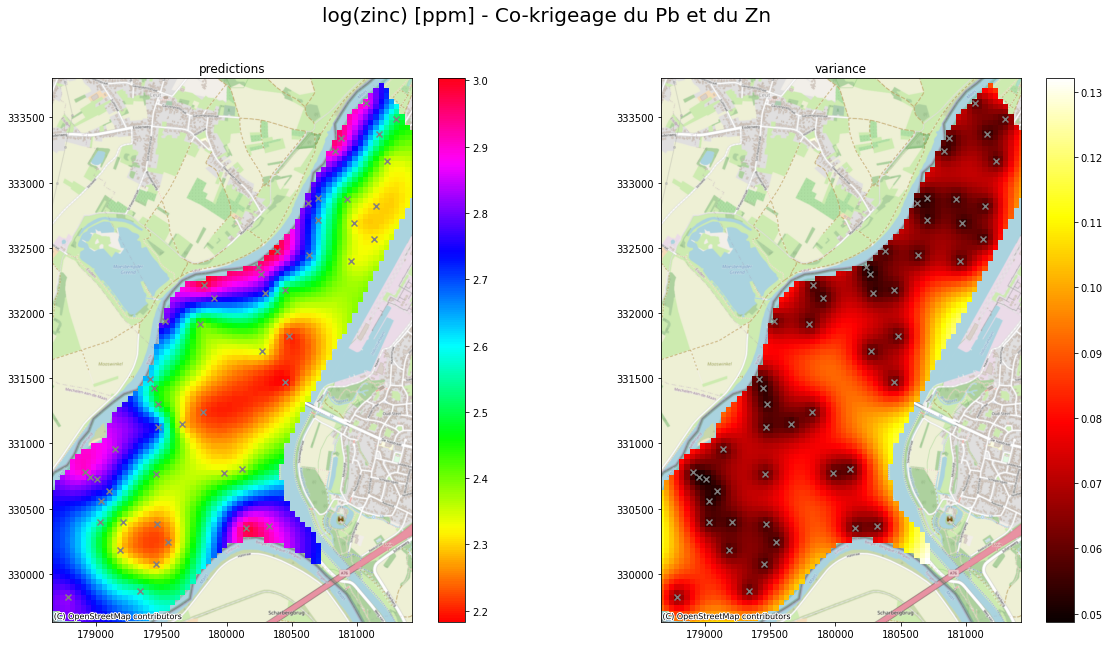

In [ ]:
# Résultat attendu ci-dessous...

<div class="alert alert-block alert-success">
	<img align="right" src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABmJLR0QA/wD/AP+gvaeTAAAACXBIWXMAAAbmAAAG5gFFAfPZAAAAB3RJTUUH3gwMFiIaKb3l3gAACBFJREFUeNrtW31sVWcZ/z23pSKtCYqXjW3R4DqEdpNVgzaKAXUE3ew2xRLHRKMuk3WajbQ6DW65M4jgGIiLZP5lxGmyofhBl8lWsMBWKBPWdC4zHRAj8lFoN6al68c9z88/7rnnnnPvOee+5/Z2O8a+bdP3vufet+f5Pc/v+TpvgakxNabG//OQydz85p90XDY+xuUk5wNIUpkkOZtkEqqzSU4nOUhiQKEDCYuDCgworAFR7R2aNv3Jo6mm4f8pAJpTL1UN1/S3KbEC1AaQQhLZHzhzLVzT3DV7bVjJXemE1da9YVV/7AG4aev+BbD0NySvR56QXuELBPV5n+uzyguk9bVDD32pPbYAND/xRMXwP5N/B1nLPC0bCVnwvoLPjhPaePih1cfKCUCiXBsNn0re5hZeiQNQ3CLUW0gccAsJHzAM1qZB8aulqV9MLycAleXaiMpPwhGeF6tGRj6z23ZgTandHW9UJE6DnOlvCcZrdcP/TtwAoD12FgBgDkEABIhdu13ee3eqaRjkrkINI0Tr8LcExYdjSQFSk9kbBazFIMV1UUguDtJwNFpYC2NJASEqNae9ecs3PPVg5Y/atwLAyA/a1xKcB9tC3F9AJAoAirfFEgDNi+tK3D+altaMRXBGqIZdYHgA8rMEEPF0gv5mO6O4k0Ow1vPsxfYv8QQgnMOYaAj0WEtMLUB3EjwMAqKEAlBbi2BWewQVUBD25CMErw8X3AfcOALw9Lobfxj1Mx/9zuMbYQNgnA+ovjUA3PRw5yeo2qDUBSCvAinM3kwm+QGhoNraZUbTtGjfswVQ7fBPQAmLOk+K5gPeNcfi+ltboViWd5uXkGAPVP6Ky9+xRySlEwagacu+JVTZqKqNICEej4wAhwav1xY6/ouusCcl+ANX8XIdBMsLuYjPAwqcfe0Znv3W7TLnkQslJ0JNWzpbVKWTZOPEkheftYJ8ACEUgCH3s9ZnAdBlsPQwz7VVlwRA08P7VqjiERNuolxrQfmAiefPCk51gWC9D+mhByMDcOvWv8wkEjtATZjk7xMscIzADdd6geCu1+l7+I875kYCwFL5MqkzvAmIqTZR1nwg1PQdITVPaIcGALUSSH8hEgBKfMMvAfHwFZNBi0KAfMZFW0szMwKGad+ei5oDcOPmve8ltc5IgEC+locC/gYvRzPVl7XIK6iP4Llri3iq+e1GAKhILVzaKFnDUQocn7UQs3+ep9ZeCdUrHMHhIzg8oAhGE1cbAZBQrTXOy8tW4Jimutzf8+ia/UiMLc8J7RIcIdYAvcYoESJZSzv/fjMLHINw90ZC9A6euyuJtGxyAHBif/5c7ejhXKs1o4CidvJjP6KGu1dILj22/e7jsPAoYL07hO8BlEhfY0YBYa1HHyVRoLS1PFu8APApCL+v1TMaetb1vch/rdkO1c8FJD1FKOFvAZWFFsC5Hs3Bx6EV0zB4VIh2Jbp1RI8c+dlXBidUap+5+4PQ9K9Bne8x9ayZO/MAGkT0Aa+DrA51aPn5QM7Dj4G8v6u6bzNSKeX5lhqkqxvwQOssI0kty56kAWA2yEbQaoQ1Ph9Q8XDaM88HpYD/AHW2WTVIniB5RQlcv2Apb+jevKqXZ9uWYk3rNiiuRUITRVP57M3CRKshjs4jdME+rxr5AJInS3NyaOnevKqX59rWQ7gXwAeM2u6FMTvPkUVxdGEJkQ6Y+QDihER2aPp4149v/y37W1eDXGfI7ADzLWrKAdrXkD0VIM8aASAZCkQqcNLpigd4/tuXg7rN8DlaOGcjOTpTUNhlRAELOBEx9g8e2fLFPlBvBfFOI62jSP5uWuQUpYTrtaY7jSygSiteGUeaAMUTAgMooGS3Ldsic5PP12oE7Yc6ukBKDKOm8rCRBexJffpVwudxNgILnJecHp1xt0Z9tGYFa7/A0Rns4/mb/L3M7Rwx7gfQ4mPGBY4y23mtit6t8RGGJYASBm5GWTsiNUQqx8Z2guw3a26qYbcmhMOBaWxEUPKtIzP6cG1XRyQAOjatfJ3AnSb5QGGSw4AbNIjZxUzZNPa7b0oSLSLQyF3hA+tX/EmATUXzAc/eNNRaEKcNQQkD1xPT5adSf3Bvyc8FDmxo/q5SP0vwdGA+oDbcWmJ4oiEoRSnhMcX/gPJ1qX/2ngk/GeradNuTAK5afN+O94xbFQ1UzrFzxsy38IWSw5xaf0CCezL3rs6enrrASZzUaVhk5pbrtWOBQ6hAD/525cuycqf1ph6T45lv9oBcaFiaZo+7fE+u3rkRb+EoHwCn78oA4CtoIChDIC8FJjlgTuPZfUT3Sd3BVTE8IBGlNHXmNaDWRCpxFe+K6QkRg8ZEaWms6zpR7uPN5QXAvDQt5icswPojyFkAl3jDW3mPiJQPAFg5jU6syBkDWS/1+48DAF/82DIInnYH93ICUL6ToqoDZYn90N9JfedxR9zrnnsGwAsuCxiMJwBId0V6UhMISnrUp6YadTGgO6YWgA7zfD4s88NKHvt40pG3d/GHIGjM3TEPxjIPAACebP45qHdG6+W53+eMIYA7IDIrc+YH0+x+3Tap77o3pk4QwDTci1F9P6hLojU4Cxx7DSAtect/xvmqtthmgjmKphLoO7YWYq0HdXqRXr3JlpcAuQ/1z24XKfdB2Un8rzGevPkyjI6sBvhVwD5wka/98NEL4S+RxmOysOt87GuBUDBe/tQsaLoOYB2gCzK/UQciCeAiBK9B0Q/weQgOoVIOyfznzmBqTI2pMTUmefwX5Mz8p5zVbn8AAAAASUVORK5CYII=" width="24"/>	<b>4.3 Comparaison entre le krigeage ordinaire et le co-krigeage</b>
</div>

- Calculez la différence entre le krigeage ordinaire du plomb et son co-krigeage et sauvegardez les résultats sous forme d'une image géoréférencée multi-bandes

In [139]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e2525523c62723e0a203c62723e0a3c62723e0a636f6b7269676561676524646966662e70726564203c2d206d657573652e70625f6f6b24766172312e70726564202d20636f6b72696765616765246c6f675f70622e707265643c62723e0a636f6b7269676561676524646966662e766172203c2d206d657573652e70625f6f6b24766172312e766172202d20636f6b72696765616765246c6f675f70622e7661723c62723e0a3c62723e0a696d6167655f66696c65203c2d20272e2f6d5f636f6b725f6f6b5f646966662e746966273c62723e0a6d5f636f6b725f6f6b5f64696666203c2d20737461636b28617328636f6b726967656167655b27646966662e70726564275d2c20225261737465724c6179657222292c20617328636f6b726967656167655b27646966662e766172275d2c20225261737465724c617965722229293c62723e0a7772697465526173746572286d5f636f6b725f6f6b5f646966662c20696d6167655f66696c652c206f76657277726974653d54525545293c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions


- Affichez les résultats avec la fonction python <b>plot_krige_results</b>

/home/q/.local/share/virtualenvs/ModGeo-1d7LMbOH/lib/python3.8/site-packages/matplotlib/image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


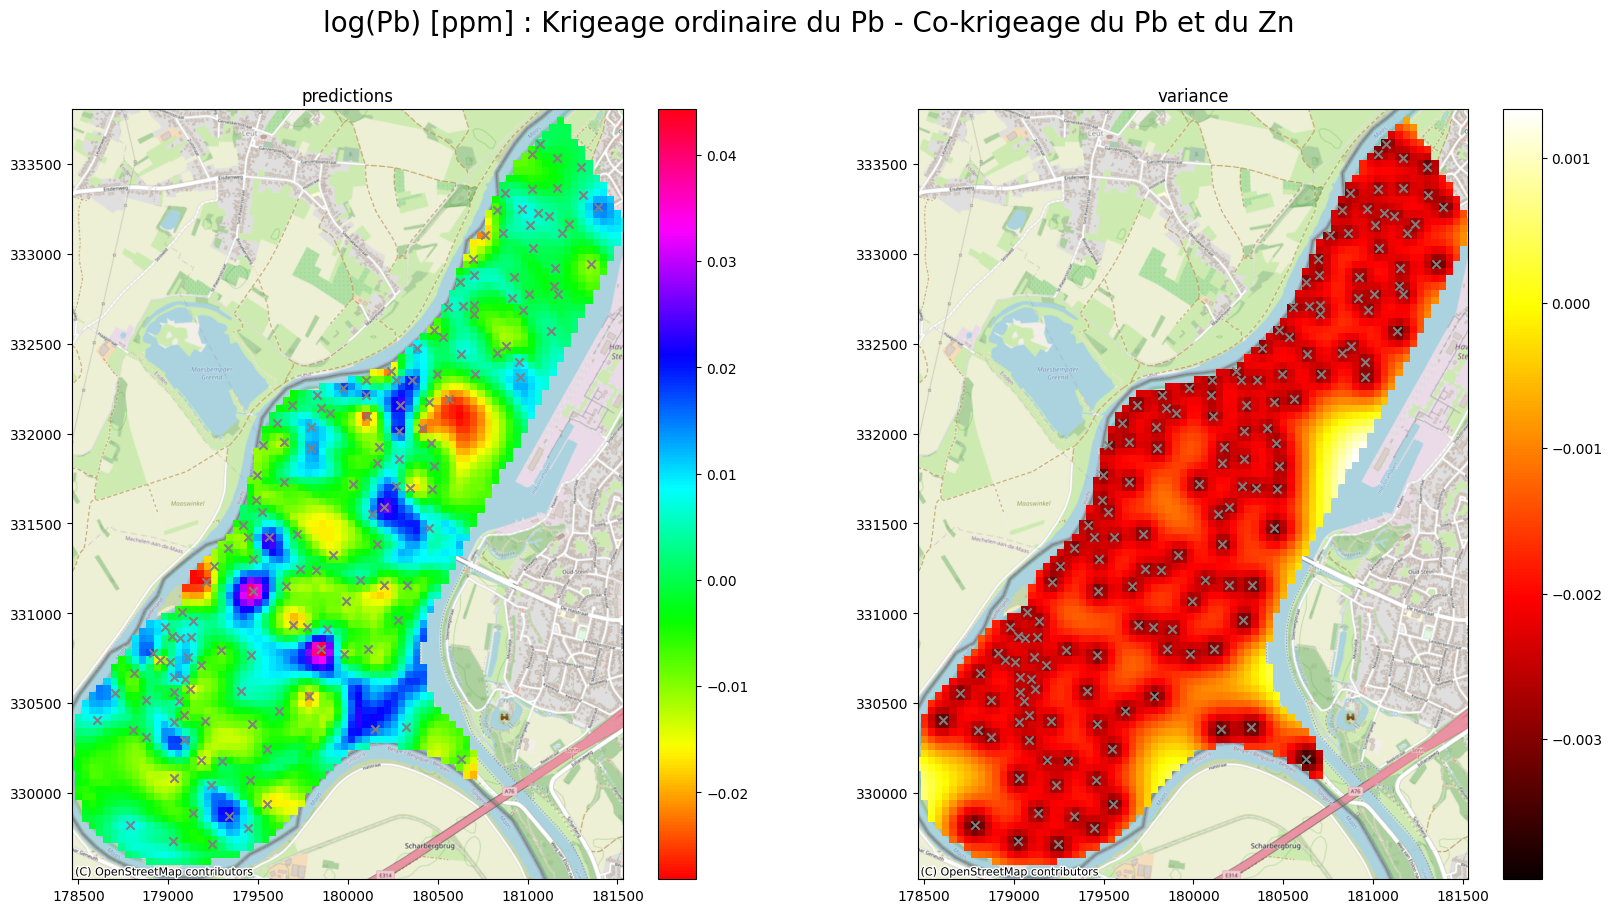

In [ ]:
# Résultat attendu ci-dessous...

***
<div class="alert alert-block alert-danger" align="center">
    <b>FIN DE LA SIXIEME SEANCE</b>
</div>